In [1]:
from google.colab import drive
drive.mount('/gdrive')


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [42]:
!pip install keract

In [40]:
!pip install numpy==1.16.1


     |████████████████████████████████| 14.5MB 5.7MB/s 
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.16.1
    Uninstalling numpy-1.16.1:
      Successfully uninstalled numpy-1.16.1


In [3]:
import numpy as np
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
import keras
from keras.layers import Input, Flatten, Dense
from keras.models import Model
import sys
import os

import matplotlib.pyplot as plt
import matplotlib as mpl


def escape():
    sys.exit()


In [4]:
import_directory = "/gdrive/My Drive/ISIDS2012/"
data_array = np.empty((0, 2))
files = os.listdir(import_directory)
for file in files:
    print('Opening File : ', file)
    data_set = np.load(import_directory+file)
    data_array = np.vstack((data_array, data_set))

#separated = np.array([x for x in data_array if x[1] == 0])

Opening File :  is2020dataset\destinationPayload_TestbedTueJun15-1Flows.xml.npy
Opening File :  is2020dataset\destinationPayload_TestbedThuJun17-2Flows.xml.npy
Opening File :  is2020dataset\destinationPayload_TestbedSatJun12Flows.xml.npy
Opening File :  is2020dataset\destinationPayload_TestbedWedJun16-3Flows.xml.npy
Opening File :  is2020dataset\destinationPayload_TestbedWedJun16-2Flows.xml.npy
Opening File :  is2020dataset\destinationPayload_TestbedTueJun15-3Flows.xml.npy
Opening File :  is2020dataset\destinationPayload_TestbedThuJun17-3Flows.xml.npy
Opening File :  is2020dataset\destinationPayload_TestbedSunJun13Flows.xml.npy
Opening File :  is2020dataset\destinationPayload_TestbedTueJun15-2Flows.xml.npy
Opening File :  is2020dataset\destinationPayload_TestbedWedJun16-1Flows.xml.npy
Opening File :  is2020dataset\destinationPayload_TestbedMonJun14Flows.xml.npy


In [5]:
#np.random.shuffle(separated)
np.random.shuffle(data_array)
print("ok")

ok


In [6]:
img_row = 50
img_col = 50

N = np.shape(data_array)[0]
train_test_split_percentage = 0.75

X_train = data_array[:int(N * train_test_split_percentage), 0]
X_test = data_array[int(N * train_test_split_percentage):, 0]

X_train = np.array([x.reshape(img_row, img_col, 3) for x in X_train])
X_test = np.array([x.reshape(img_row, img_col, 3) for x in X_test])

In [7]:
y_train = data_array[:int(N * train_test_split_percentage), 1]
y_test = data_array[int(N * train_test_split_percentage):, 1]

y_train = np.array([[x] for x in y_train])
y_test = np.array([[x] for x in y_test])

In [8]:
model_vgg19_conv = VGG19(include_top=False, weights='imagenet', input_shape=(img_col, img_row, 3))

80142336/80134624 [==============================] - 6s 0us/step


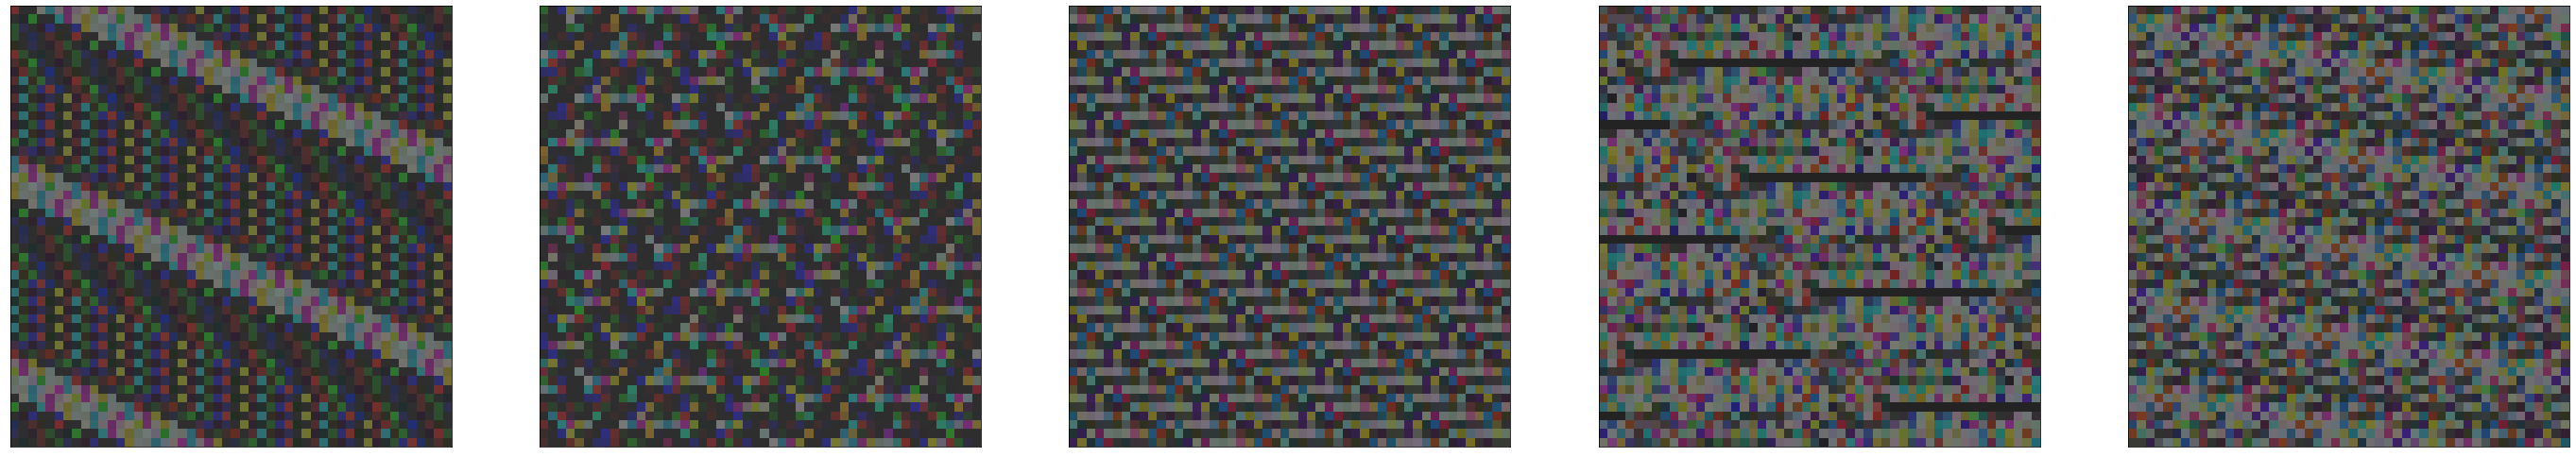

In [9]:
#ploting images for data
%matplotlib inline
n = 40  # how many digits we will display
plt.figure(figsize=(400, 150))
for i in range(6,11):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(X_train[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.close()

In [10]:
for layer in model_vgg19_conv.layers:
    layer.trainable = False
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [13]:
x = model_vgg19_conv.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid', name='predictions')(x)

my_model = Model(model_vgg19_conv.input,x)
my_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)      

In [14]:
my_model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

batch_size = 32
epochs = 2

In [15]:
hist = my_model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=0.2)
score = my_model.evaluate(X_test, y_test, verbose=0)

Epoch 1/2
15053/15053 [==============================] - 182s 12ms/step - loss: 0.0414 - accuracy: 0.9899 - val_loss: 0.0325 - val_accuracy: 0.9910
Epoch 2/2
15053/15053 [==============================] - 181s 12ms/step - loss: 0.0378 - accuracy: 0.9908 - val_loss: 0.0377 - val_accuracy: 0.9909


In [16]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.03999332711100578
Test accuracy: 0.991215705871582


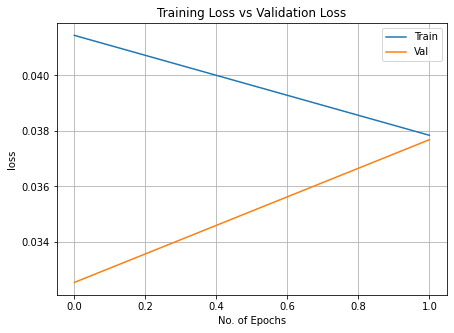

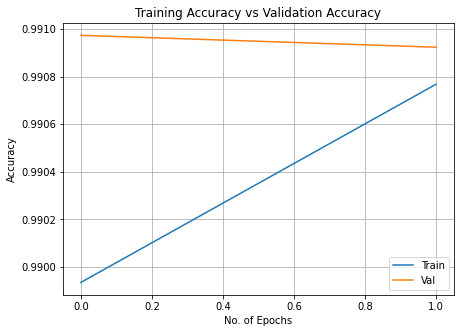

In [18]:
training_loss= hist.history['loss']
val_loss= hist.history['val_loss'] 
training_acc= hist.history['accuracy'] 
val_acc= hist.history['val_accuracy']
xc=range(epochs)

plt.figure(1,figsize=(7,5)) 
plt.plot(xc,training_loss)
plt.plot(xc,val_loss) 
plt.xlabel('No. of Epochs') 
plt.ylabel('loss') 
plt.title('Training Loss vs Validation Loss') 
plt.grid(True) 
plt.legend(['Train','Val'])

plt.figure(2,figsize=(7,5)) 
plt.plot(xc,training_acc) 
plt.plot(xc,val_acc) 
plt.xlabel('No. of Epochs') 
plt.ylabel('Accuracy') 
plt.title('Training Accuracy vs Validation Accuracy') 
plt.grid(True) 
plt.legend(['Train','Val'],loc=4)

total length =  200699
Anomolies =  9511
Normal =  191188


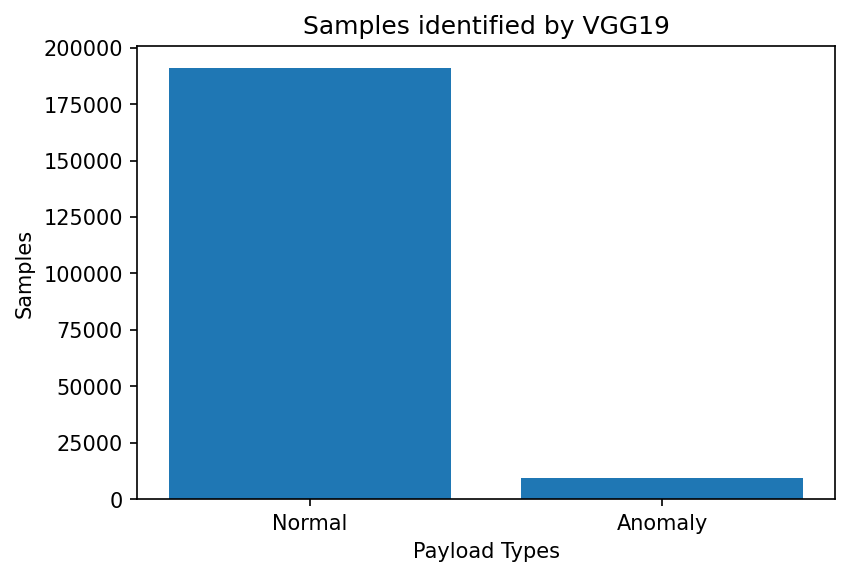

In [19]:
checking_occurences = [x for x in y_test if x == 1]
print("total length = ",len(y_test))
print("Anomolies = ",len(checking_occurences))
print("Normal = ", (len(y_test) - len(checking_occurences)))

n = len(y_test) - len(checking_occurences)
a = len(checking_occurences)

label = ['Normal', 'Anomaly']
samples = [n, a]

default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = default_dpi * 1.5

# this is for plotting purpose
index = np.arange(len(label))
plt.bar(index, samples)
plt.xlabel('Payload Types', fontsize=10)
plt.ylabel('Samples', fontsize=10)
plt.xticks(index, label, fontsize=10, rotation=0)
plt.title('Samples identified by VGG19')
plt.show()

In [20]:
predictions = my_model.predict(X_test)
print("Predictions = ",predictions)

Predictions =  [[3.9343021e-08]
 [2.8051357e-23]
 [7.8578265e-19]
 ...
 [7.6696533e-19]
 [5.4575794e-13]
 [9.1319969e-30]]


In [21]:
rounded = [[round(x[0])] for x in predictions]
from sklearn.metrics import f1_score
result = f1_score(y_test,rounded, average=None, labels = [0,1])
print("F1 = ",result)

F1 =  [0.99537303 0.9134554 ]


In [22]:
result = f1_score(y_test,rounded, average='macro')
print("F1 macro = ",result)

F1 macro =  0.9544142167975291


In [23]:
result = f1_score(y_test,rounded, average='micro')
print("F1 Micro= ",result)

F1 Micro=  0.9912157011245696


In [24]:
result = f1_score(y_test,rounded, average='weighted')
print("F1 Weighted= ",result)

F1 Weighted=  0.9914910061374195


In [25]:
import sklearn.metrics
target_names = ['normal','anomaly']
print(sklearn.metrics.classification_report(y_test,rounded,labels = [0,1], target_names=target_names))

              precision    recall  f1-score   support

      normal       1.00      0.99      1.00    191188
     anomaly       0.86      0.98      0.91      9511

    accuracy                           0.99    200699
   macro avg       0.93      0.99      0.95    200699
weighted avg       0.99      0.99      0.99    200699



In [26]:
my_model.save("FYP_Finalhd5.hd5")
my_model.save("FYP_Finalh5.h5")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: FYP_Finalhd5.hd5/assets


In [33]:
import keras.backend as K


def get_activations(model, model_inputs, print_shape_only=False, layer_name=None):
    print('----- activations -----')
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs

    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(0.)
    else:
        list_inputs = [model_inputs, 0.]

    # Learning phase. 0 = Test mode (no dropout or batch normalization)
    # layer_outputs = [func([model_inputs, 0.])[0] for func in funcs]
    layer_outputs = [func(list_inputs)[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations


def display_activations(activation_maps):
    import numpy as np
    import matplotlib.pyplot as plt
    """
    (1, 26, 26, 32)
    (1, 24, 24, 64)
    (1, 12, 12, 64)
    (1, 12, 12, 64)
    (1, 9216)
    (1, 128)
    (1, 128)
    (1, 10)
    """
    batch_size = activation_maps[0].shape[0]
    assert batch_size == 1, 'One image at a time to visualize.'
    for i, activation_map in enumerate(activation_maps):
        print('Displaying activation map {}'.format(i))
        shape = activation_map.shape
        if len(shape) == 4:
            activations = np.hstack(np.transpose(activation_map[0], (2, 0, 1)))
        elif len(shape) == 2:
            # try to make it square as much as possible. we can skip some activations.
            activations = activation_map[0]
            num_activations = len(activations)
            if num_activations > 1024:  # too hard to display it on the screen.
                square_param = int(np.floor(np.sqrt(num_activations)))
                activations = activations[0: square_param * square_param]
                activations = np.reshape(activations, (square_param, square_param))
            else:
                activations = np.expand_dims(activations, axis=0)
        else:
            raise Exception('len(shape) = 3 has not been implemented.')
        plt.imshow(activations, interpolation='None', cmap='jet')
        plt.show()


input_1 (1, 50, 50, 3) 


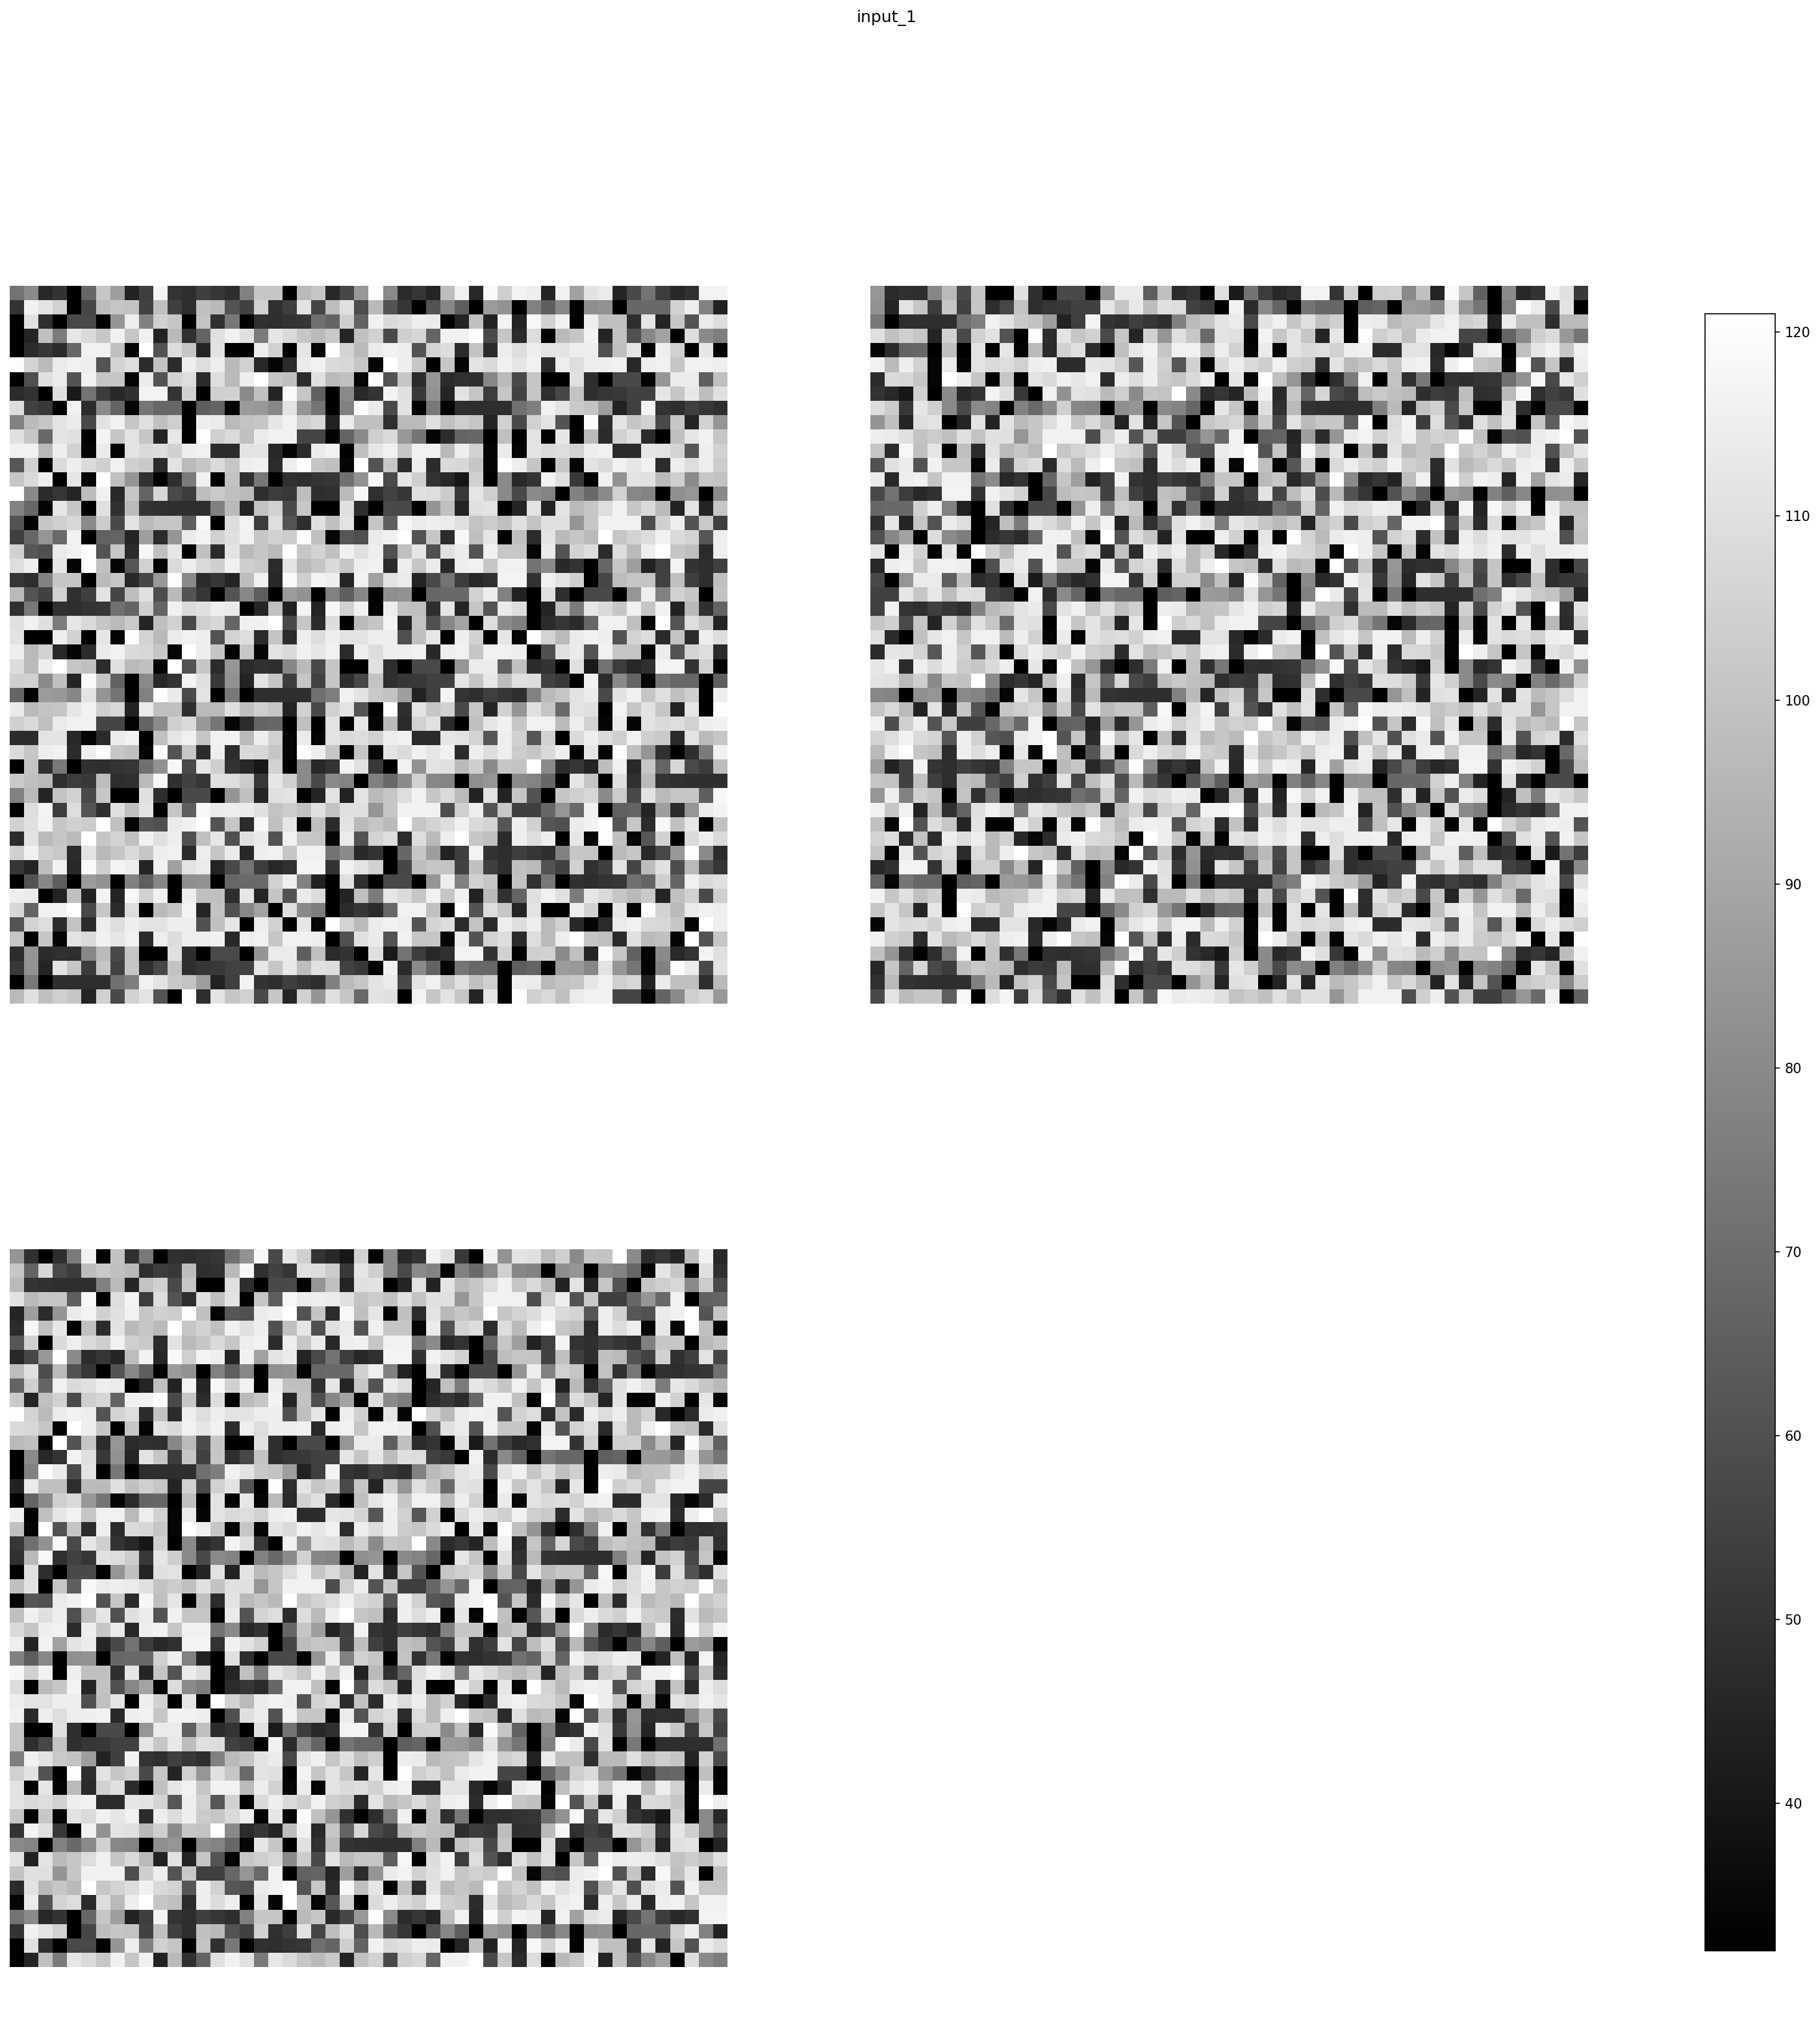

block1_conv1 (1, 50, 50, 64) 


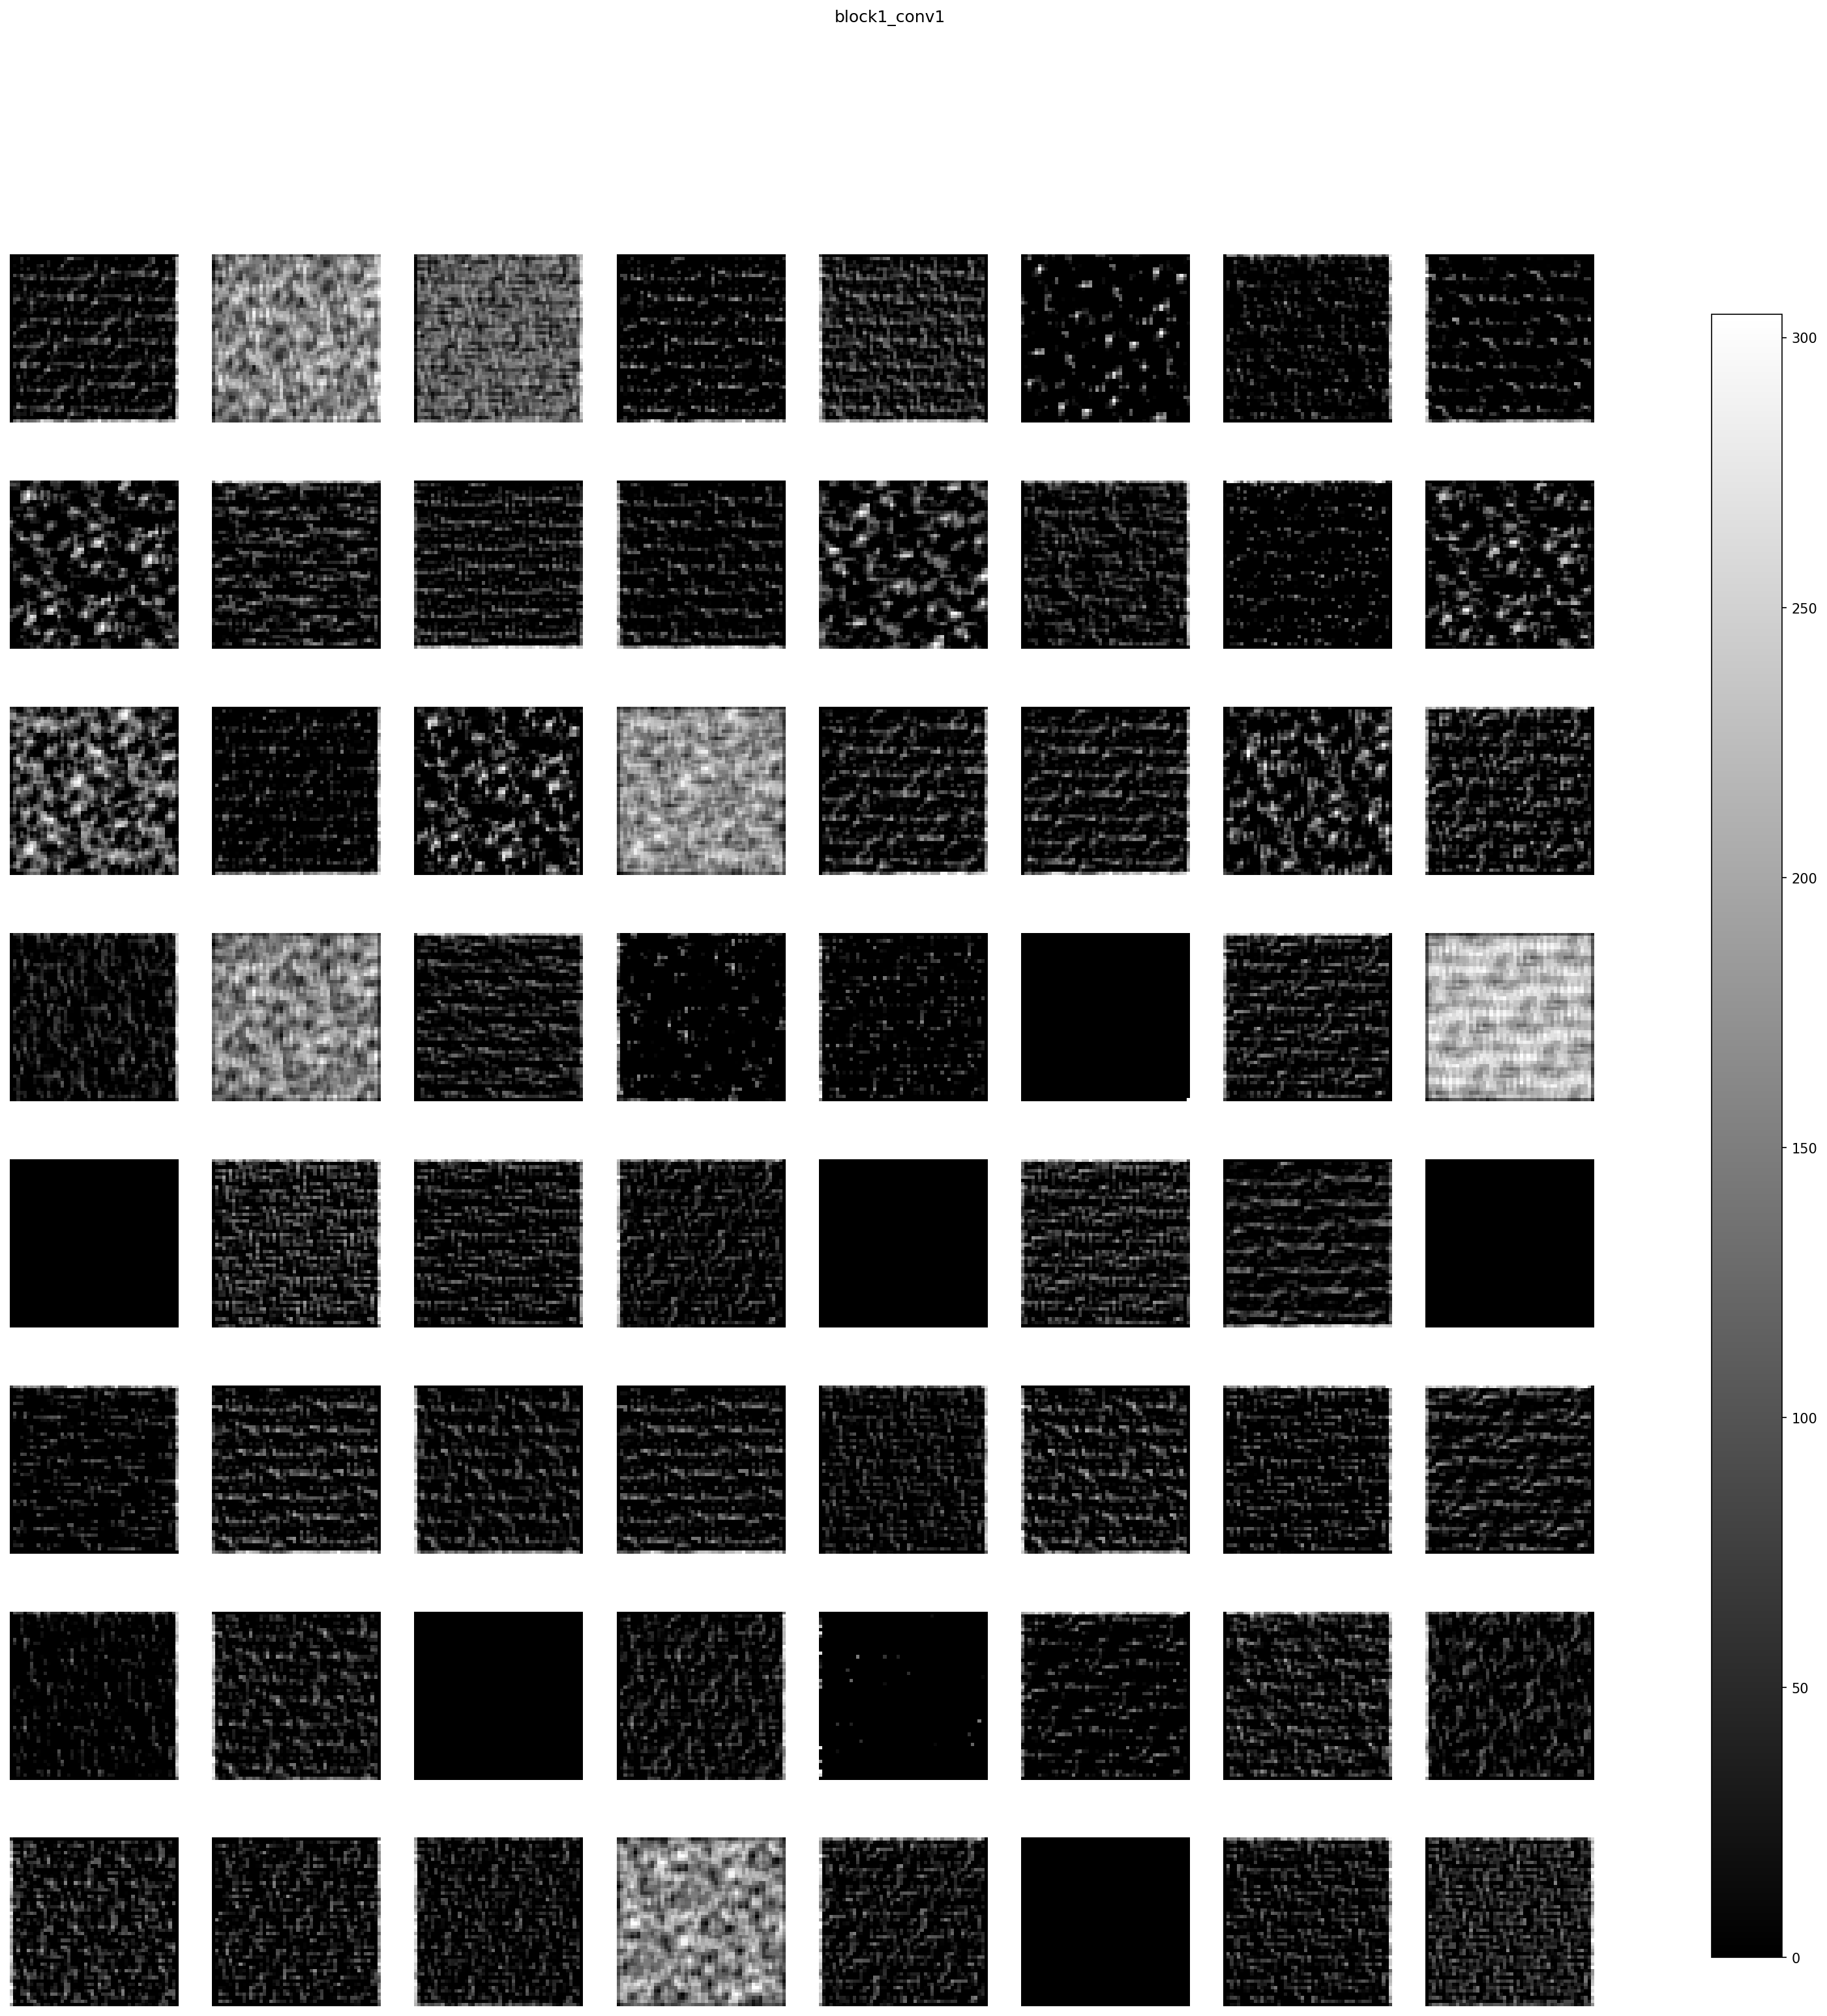

block1_conv2 (1, 50, 50, 64) 


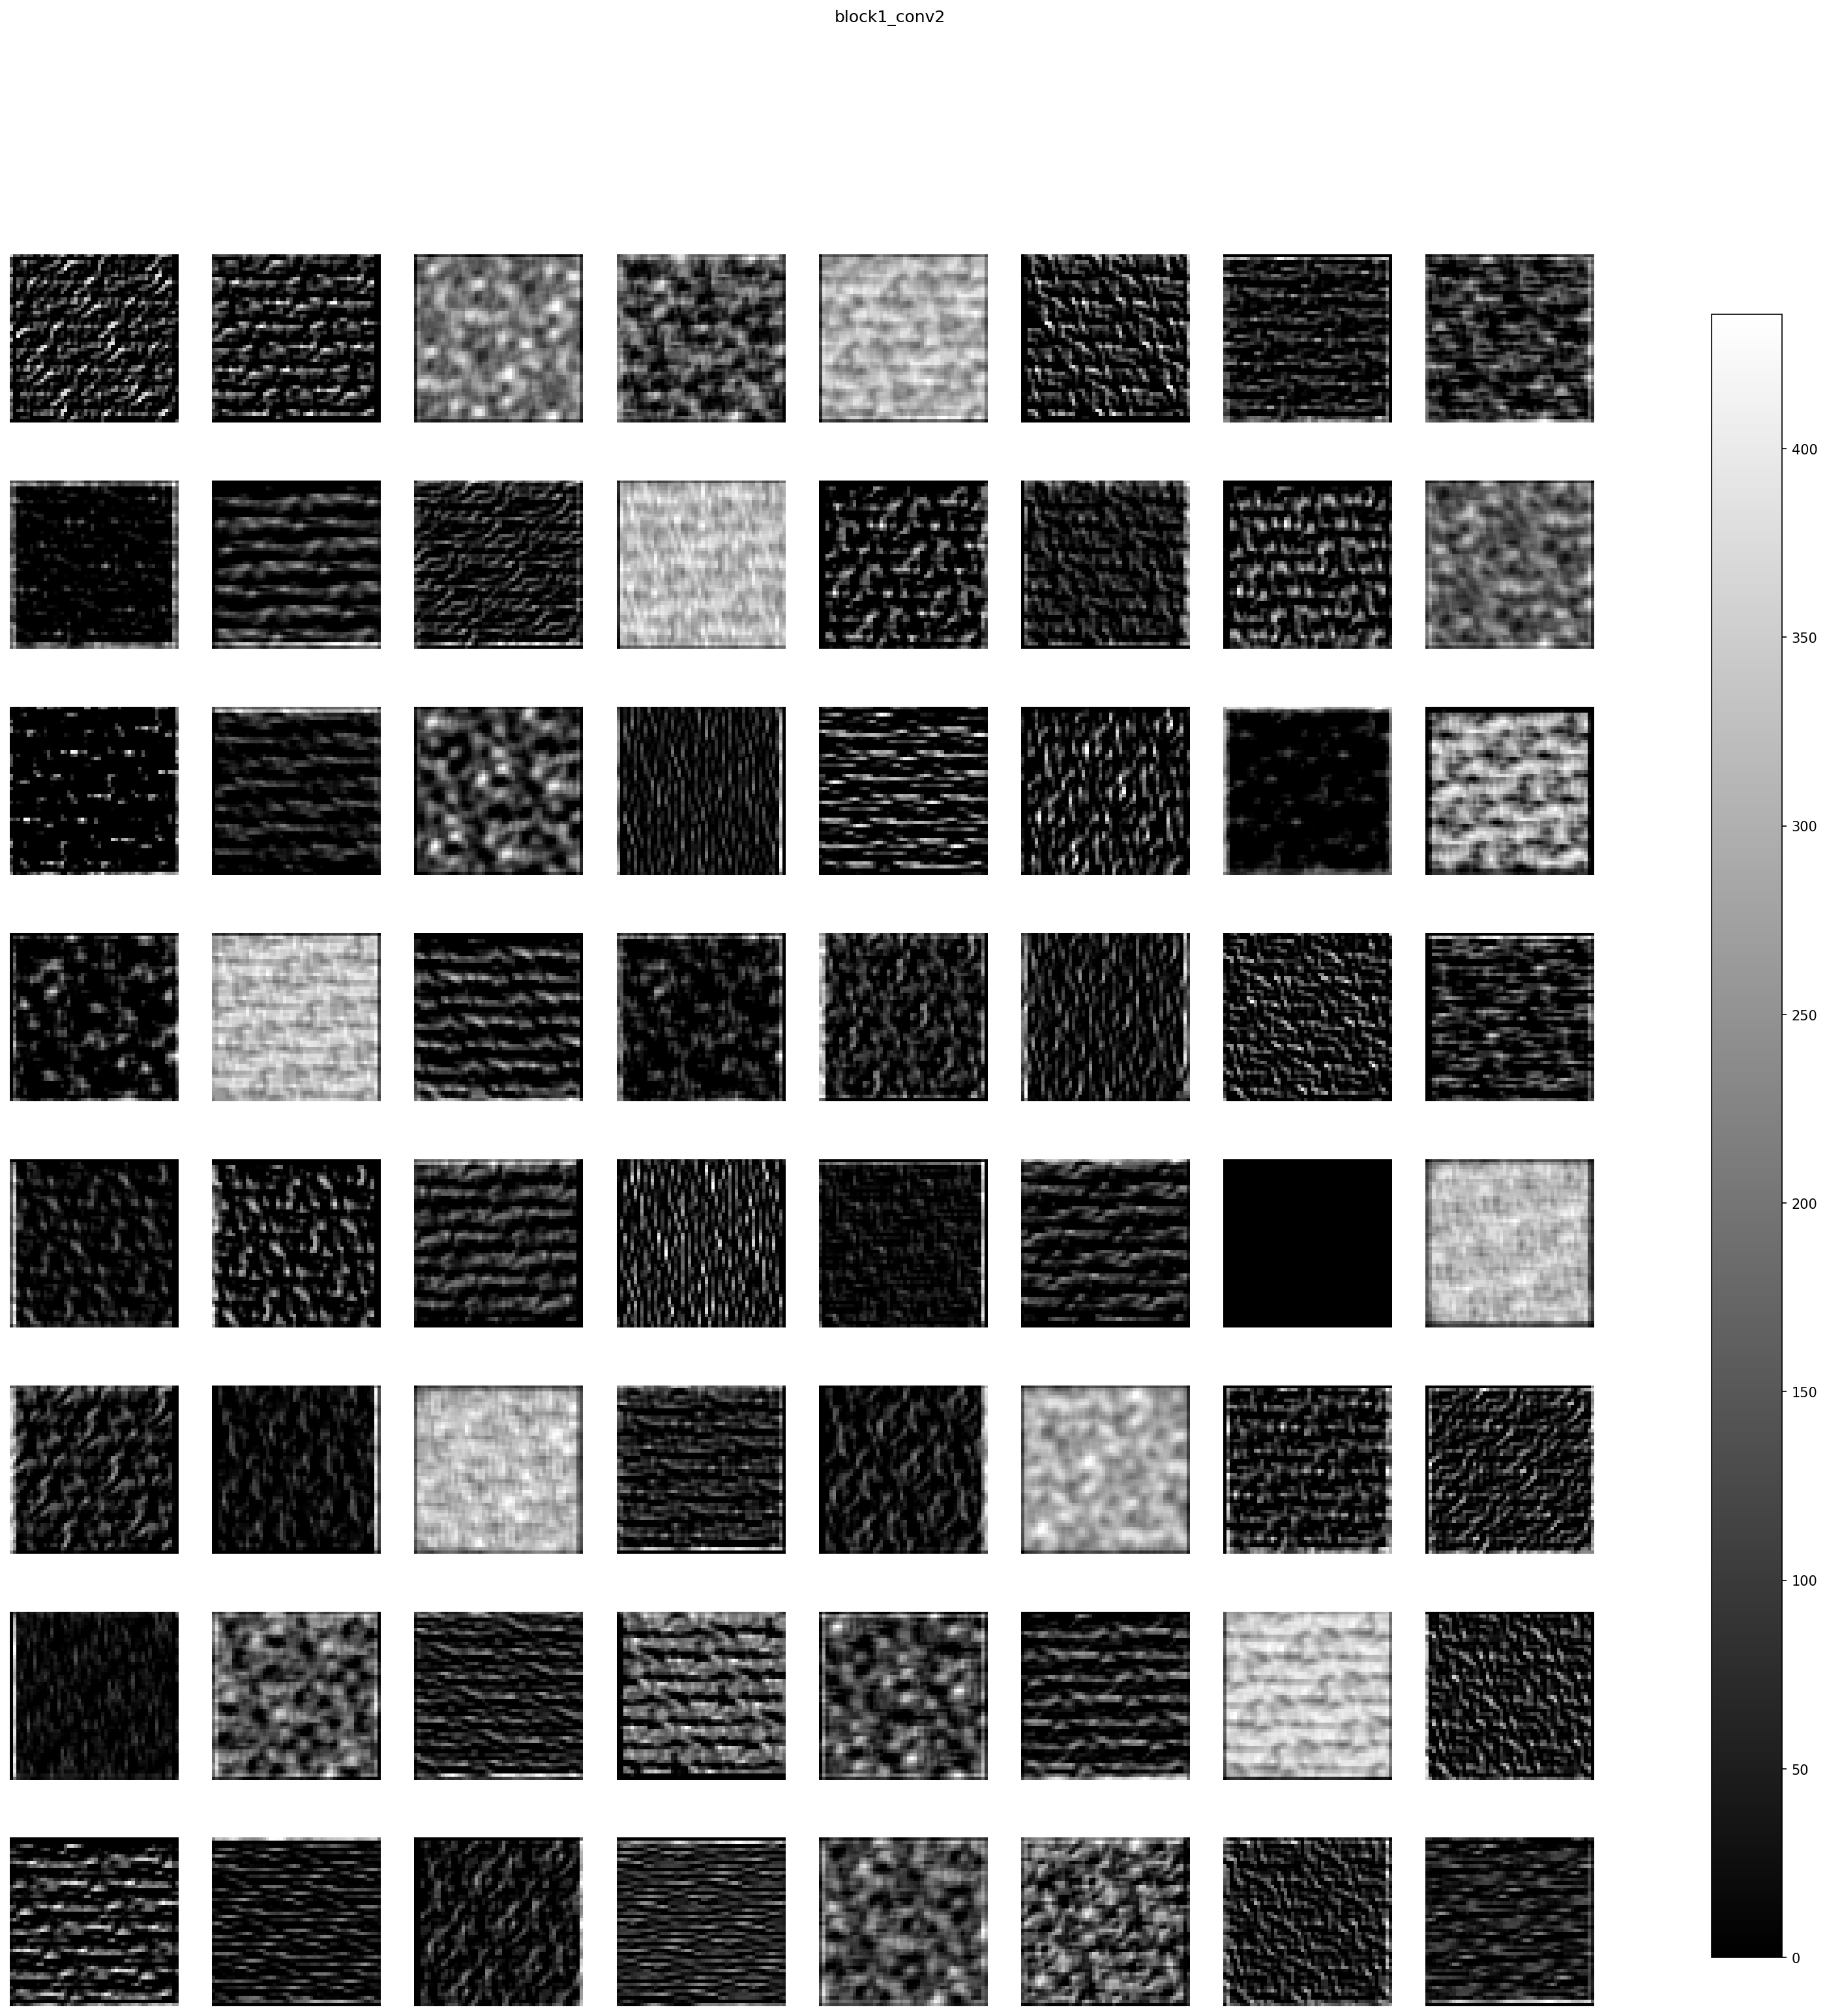

block1_pool (1, 25, 25, 64) 


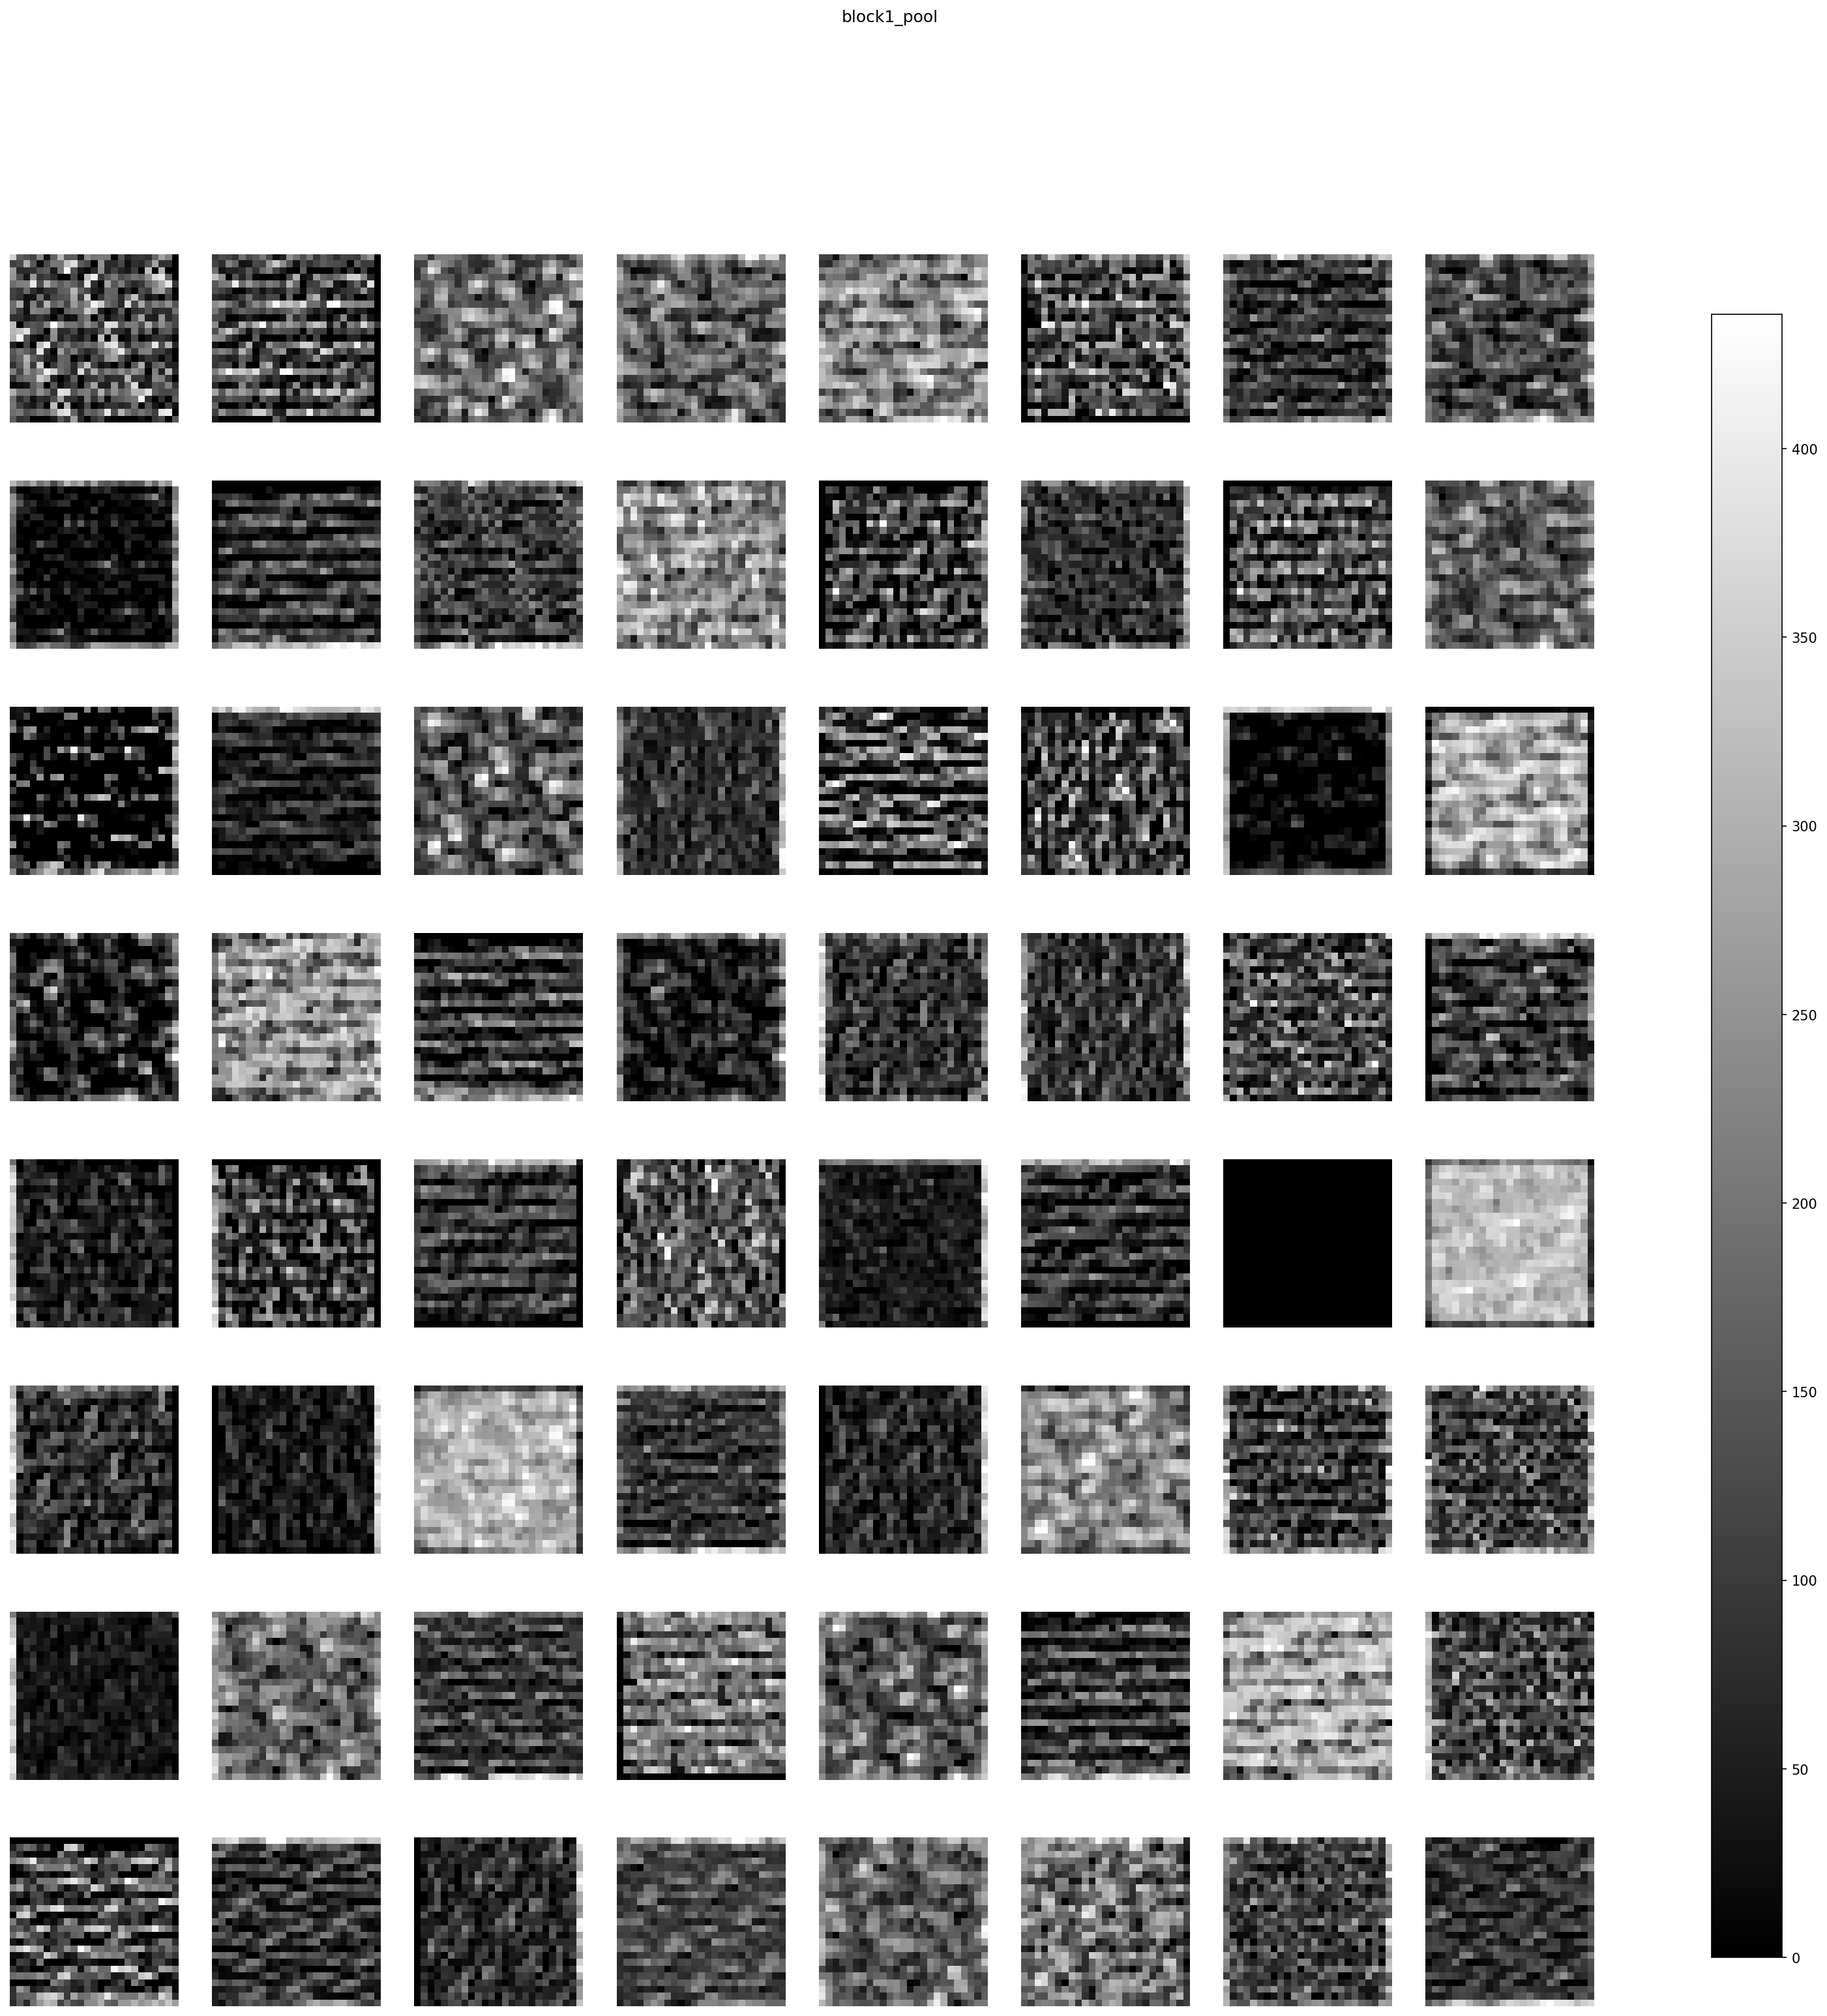

block2_conv1 (1, 25, 25, 128) 


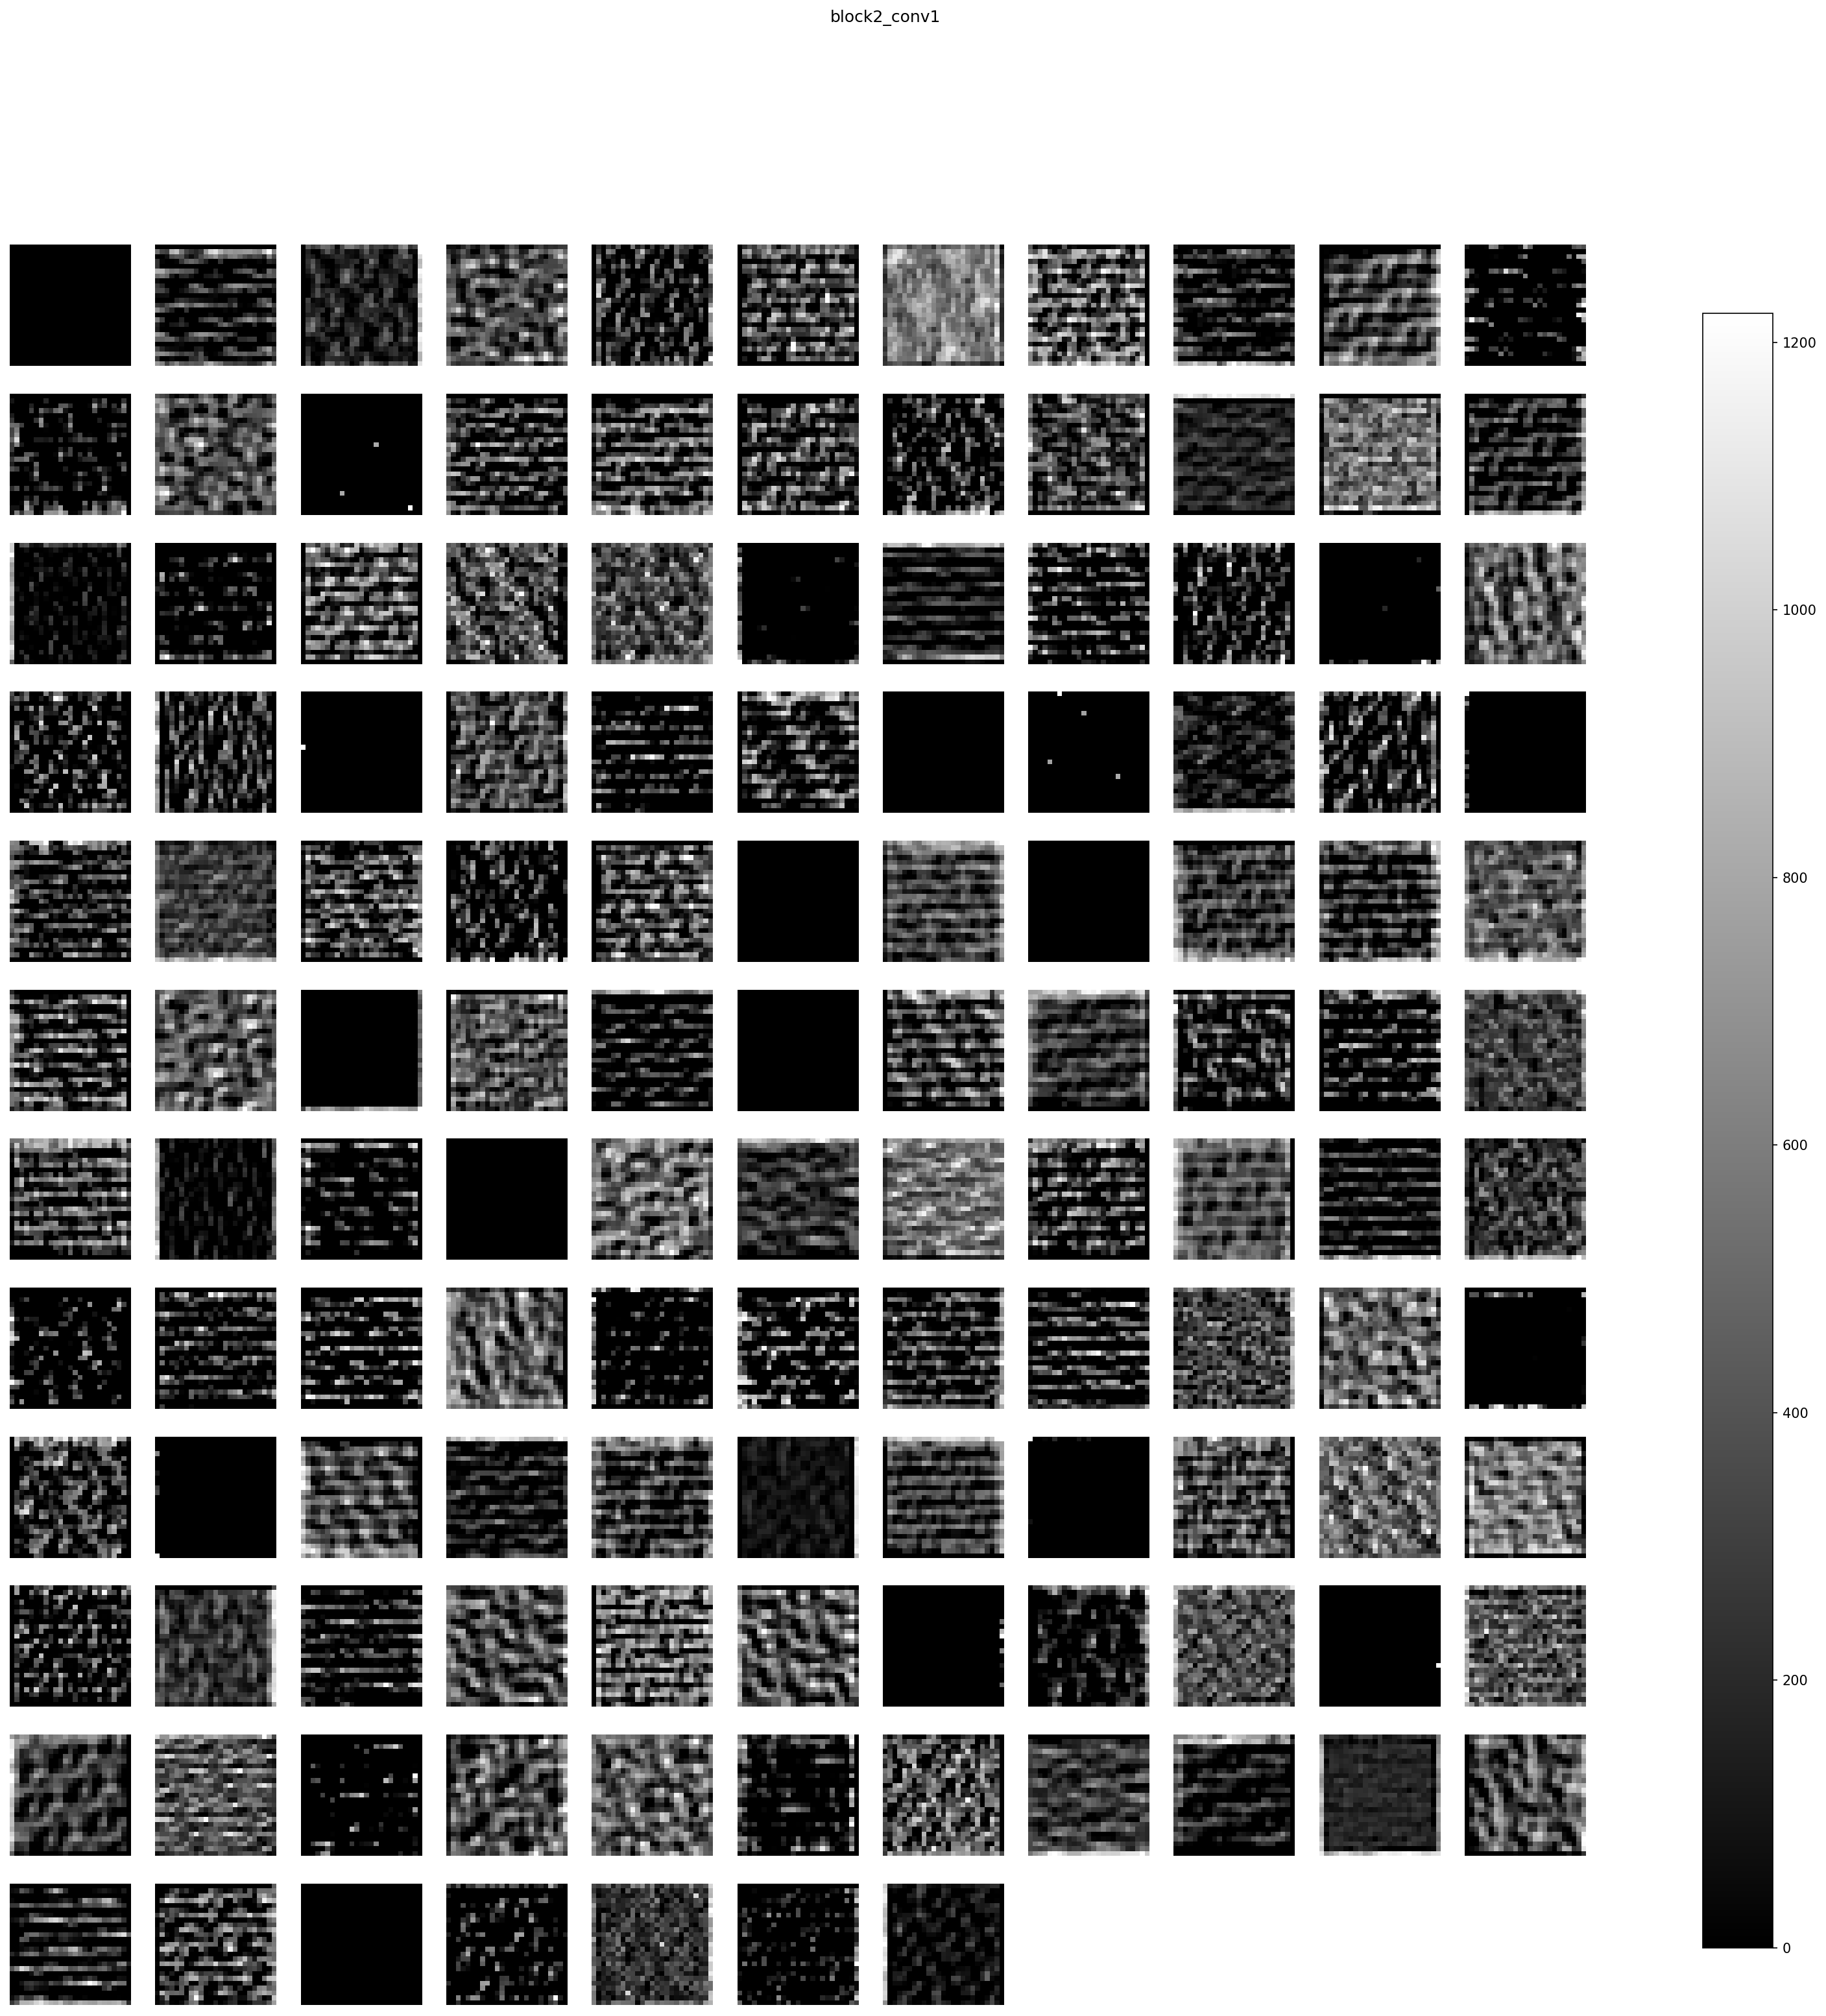

block2_conv2 (1, 25, 25, 128) 


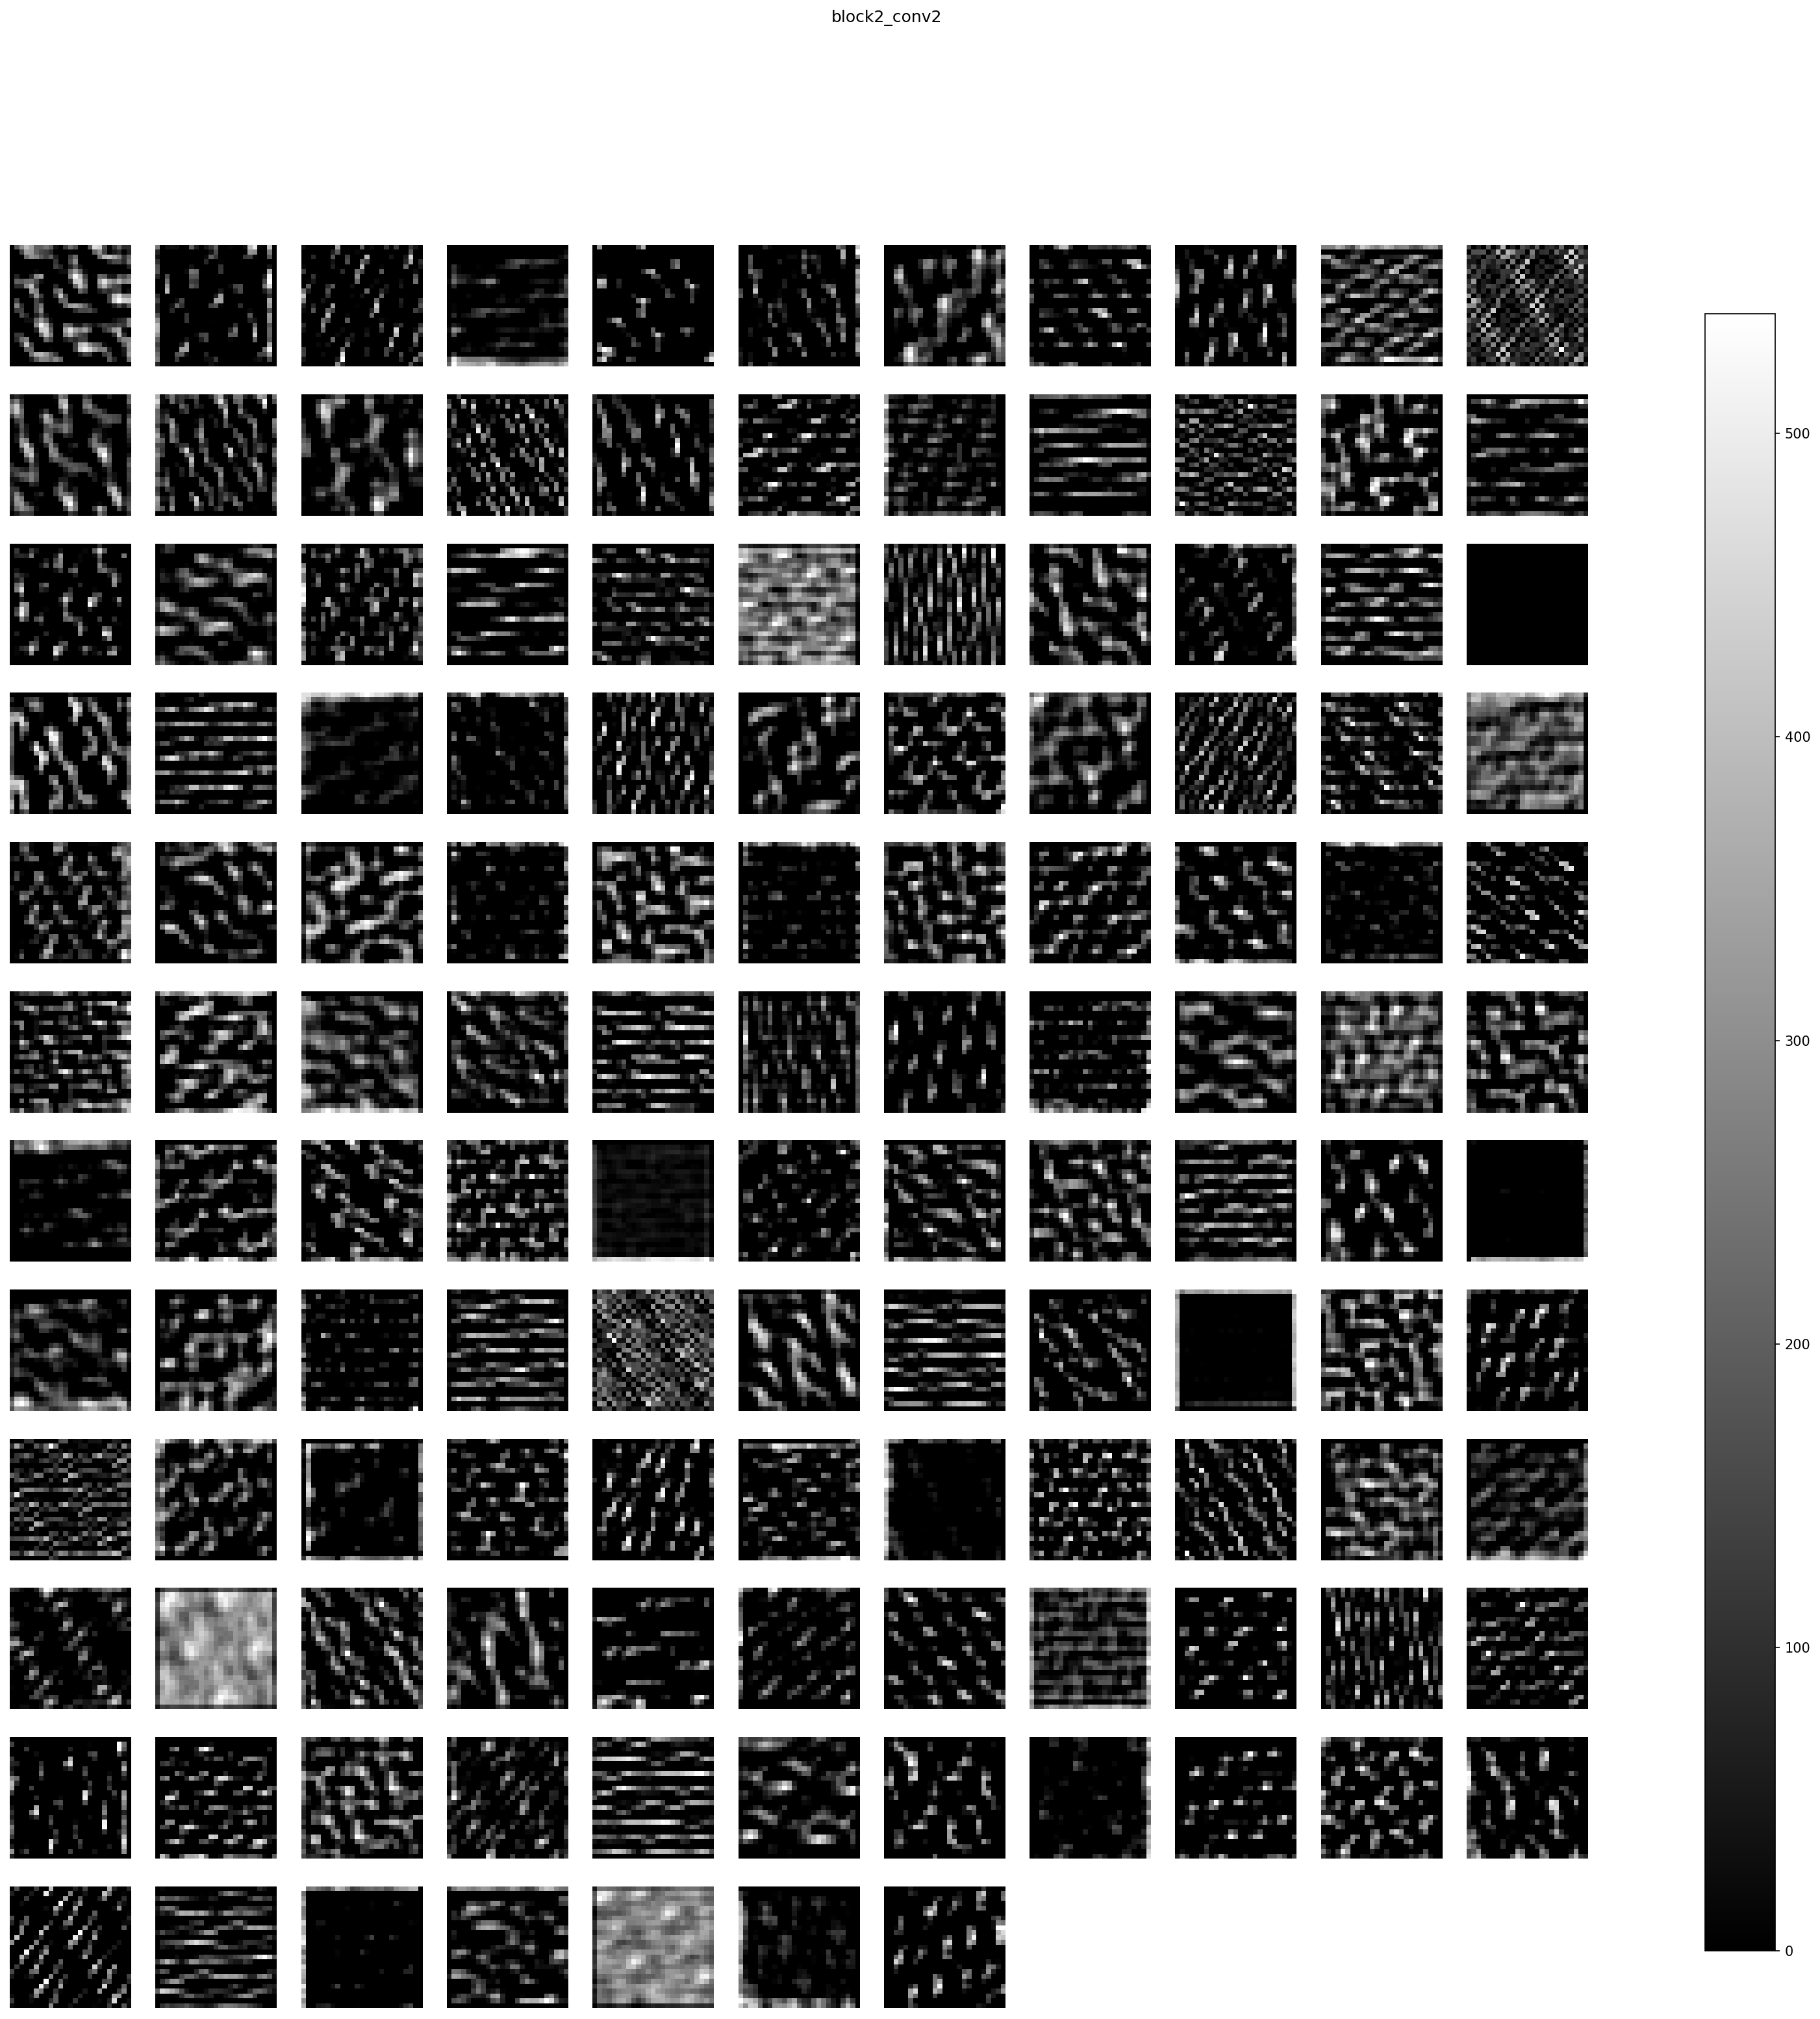

block2_pool (1, 12, 12, 128) 


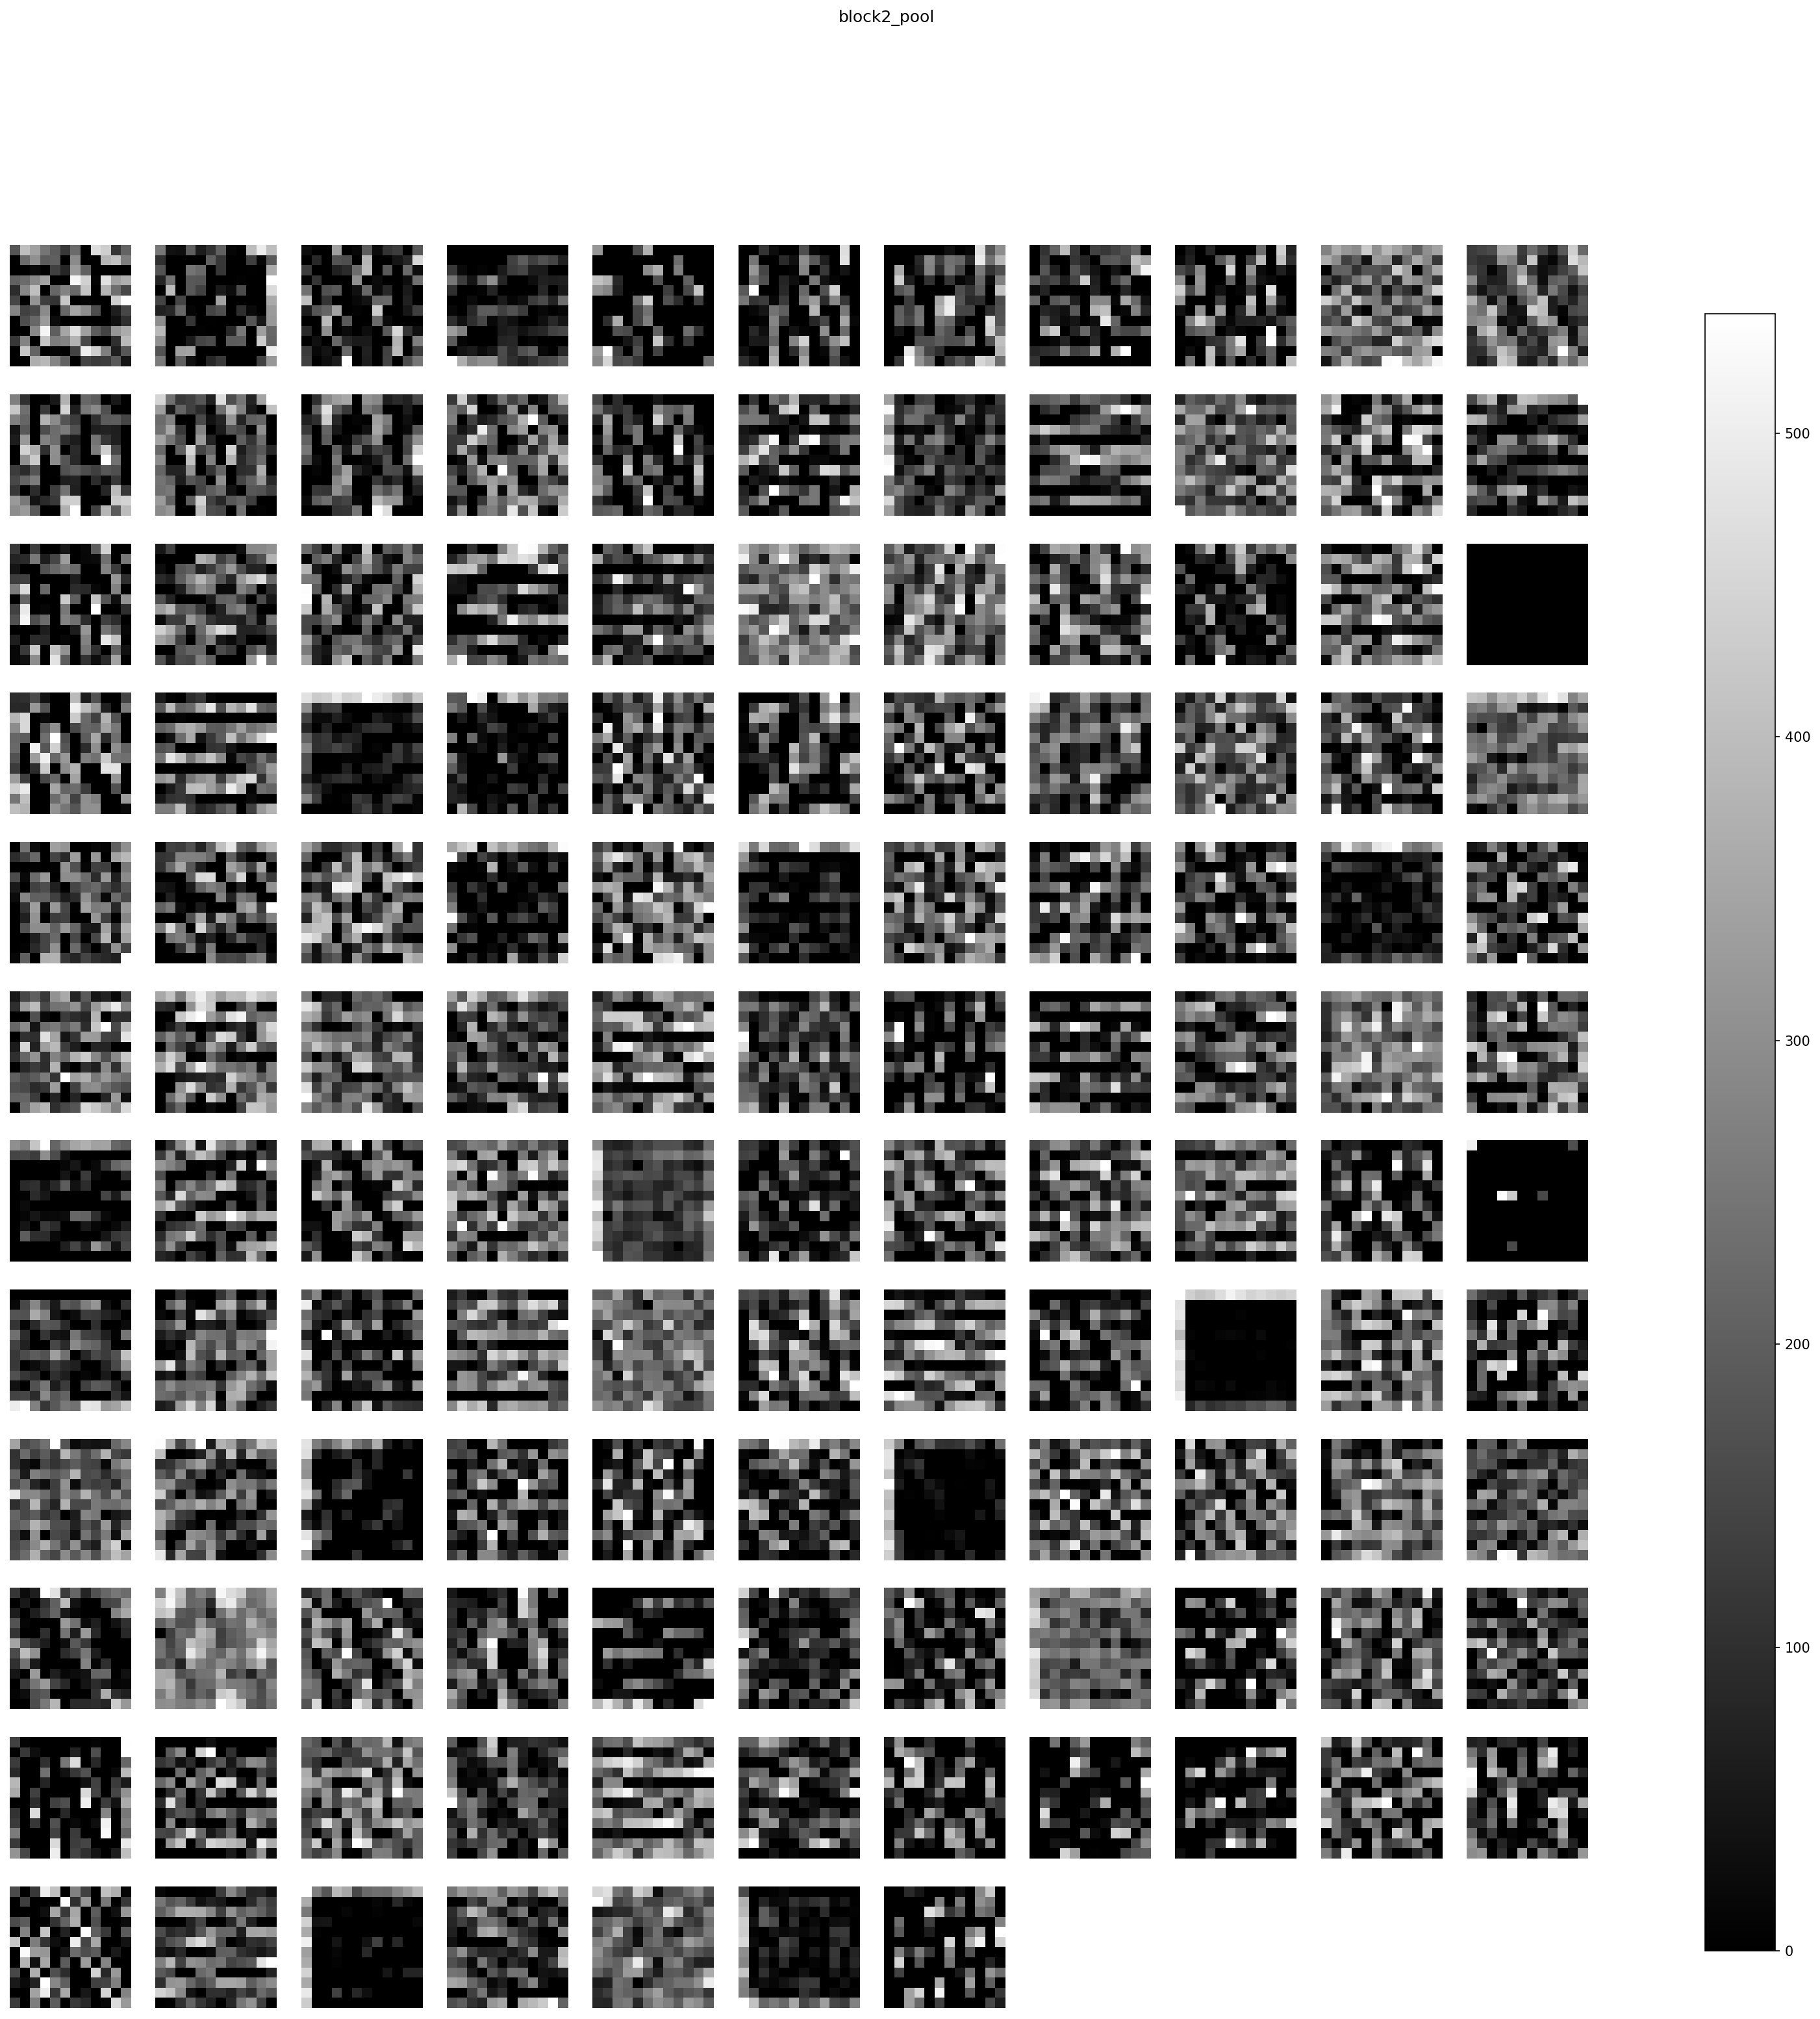

block3_conv1 (1, 12, 12, 256) 


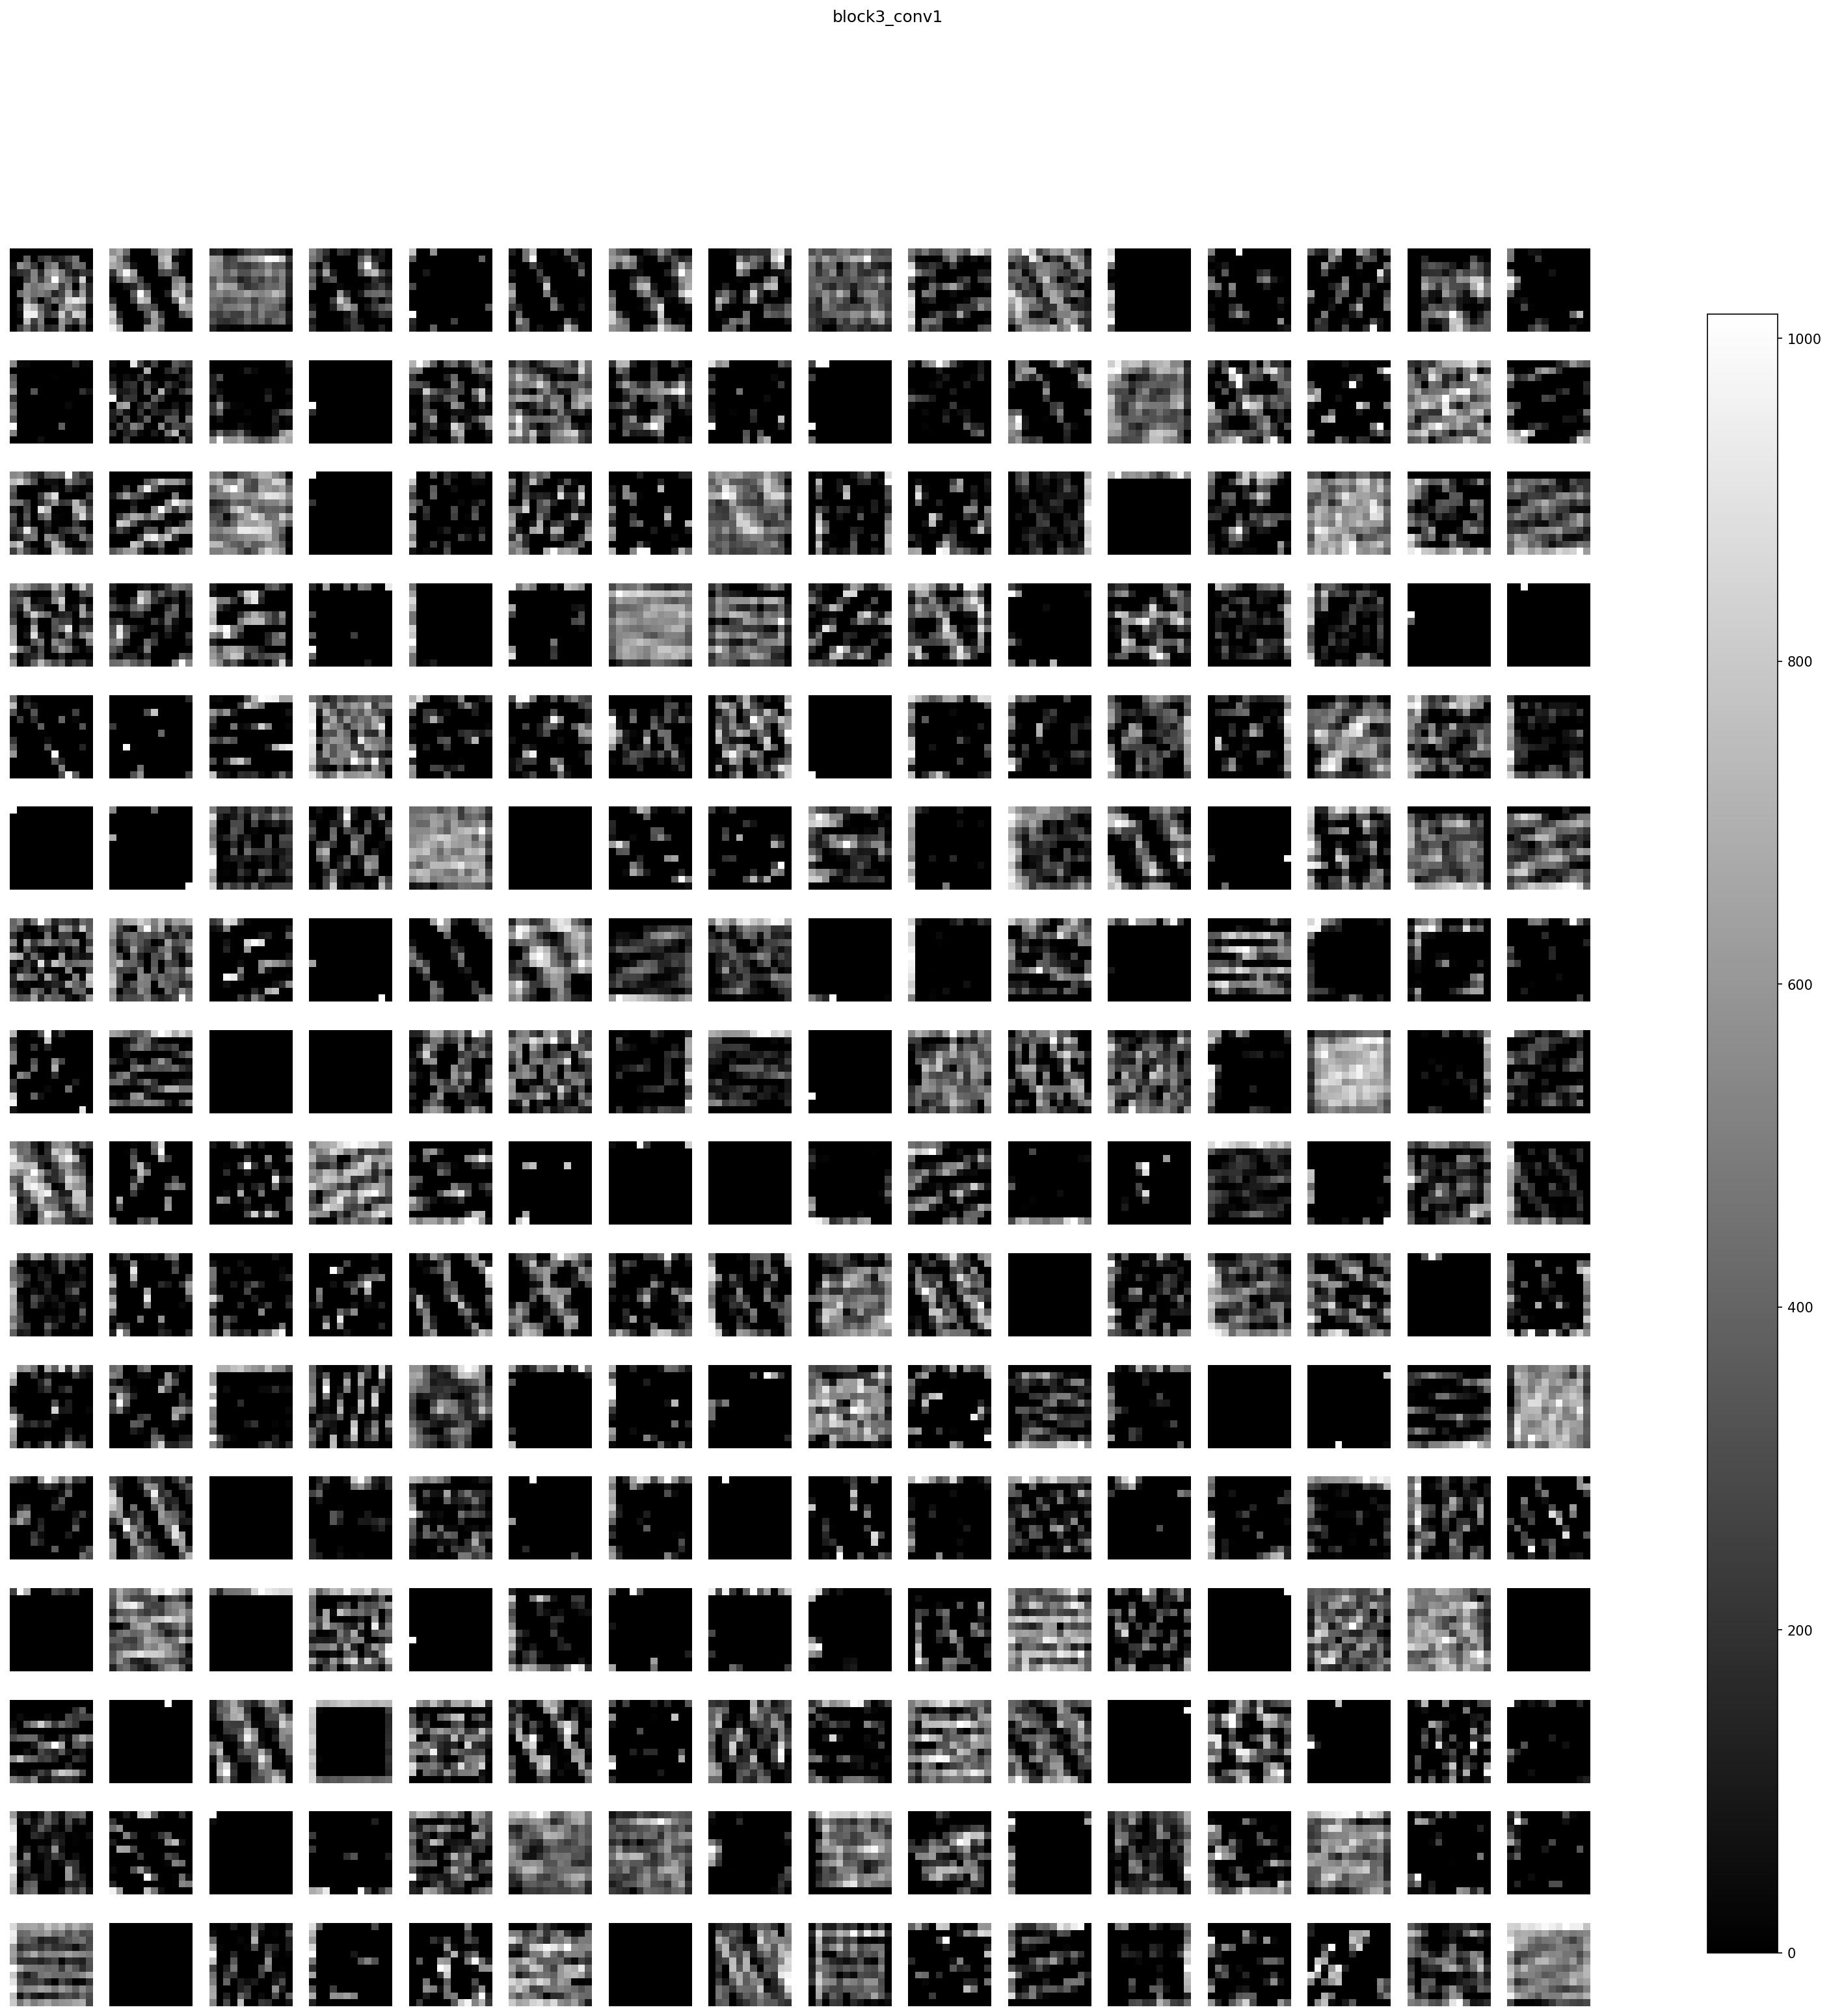

block3_conv2 (1, 12, 12, 256) 


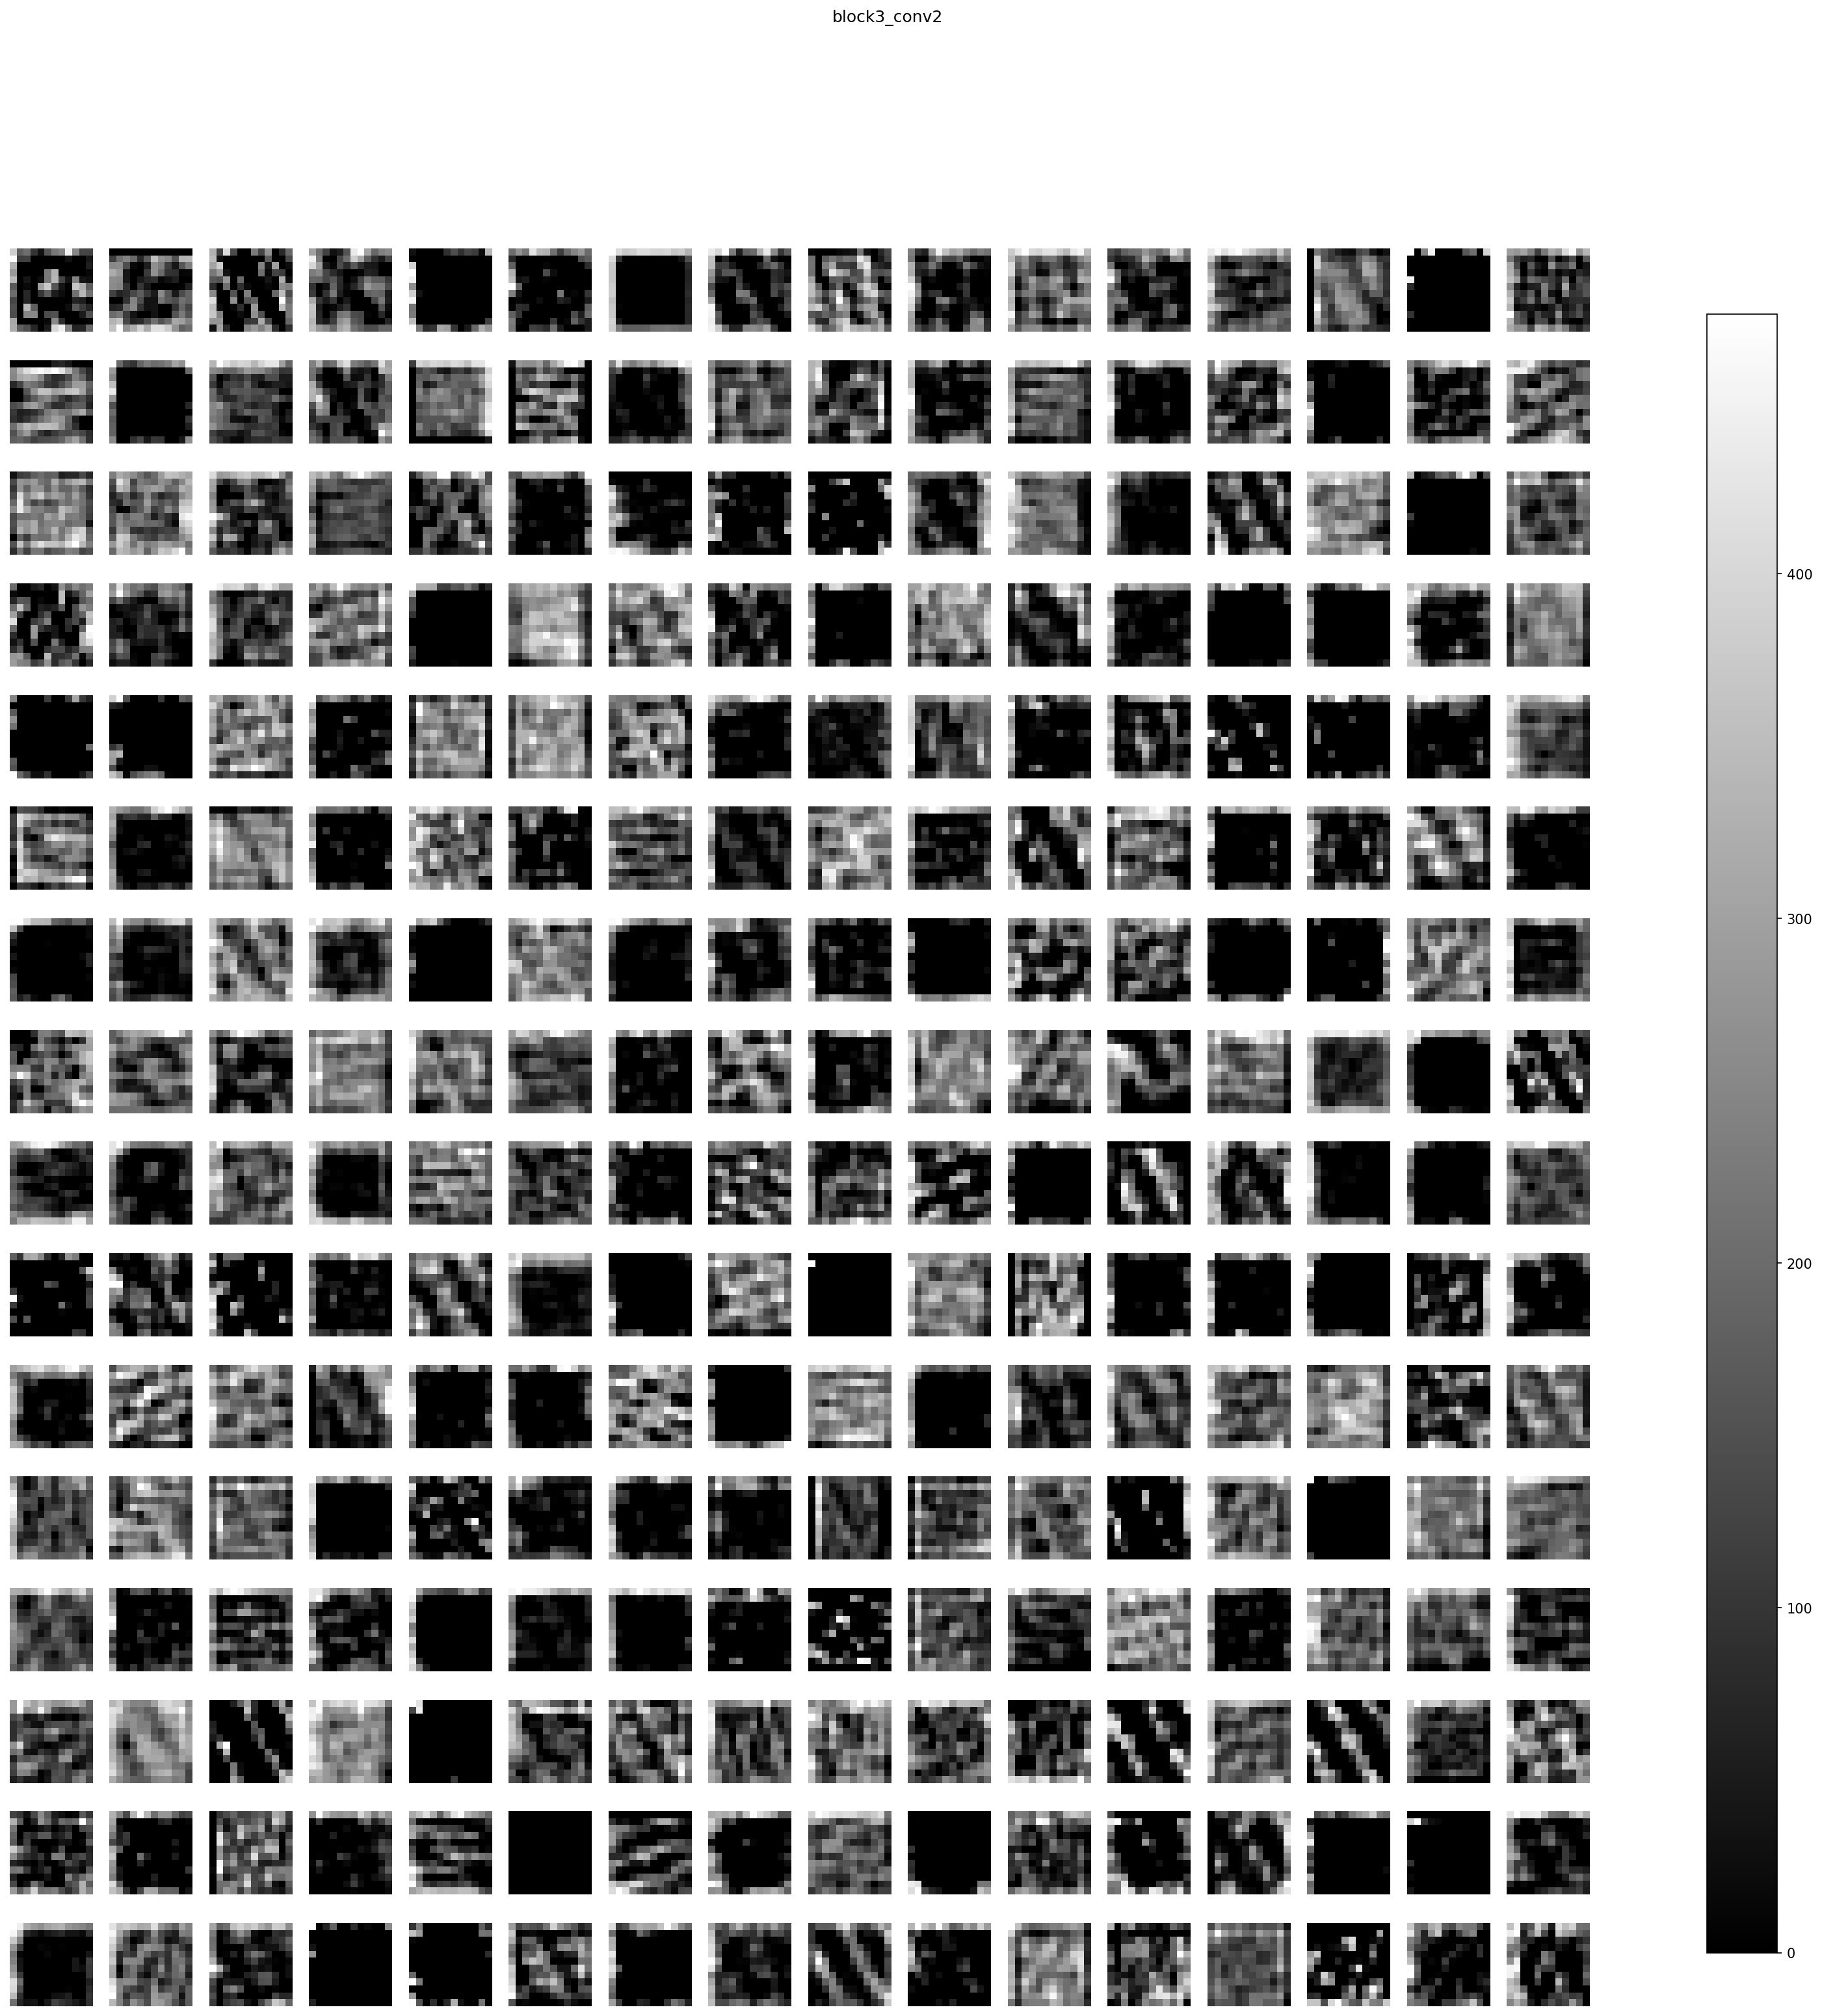

block3_conv3 (1, 12, 12, 256) 


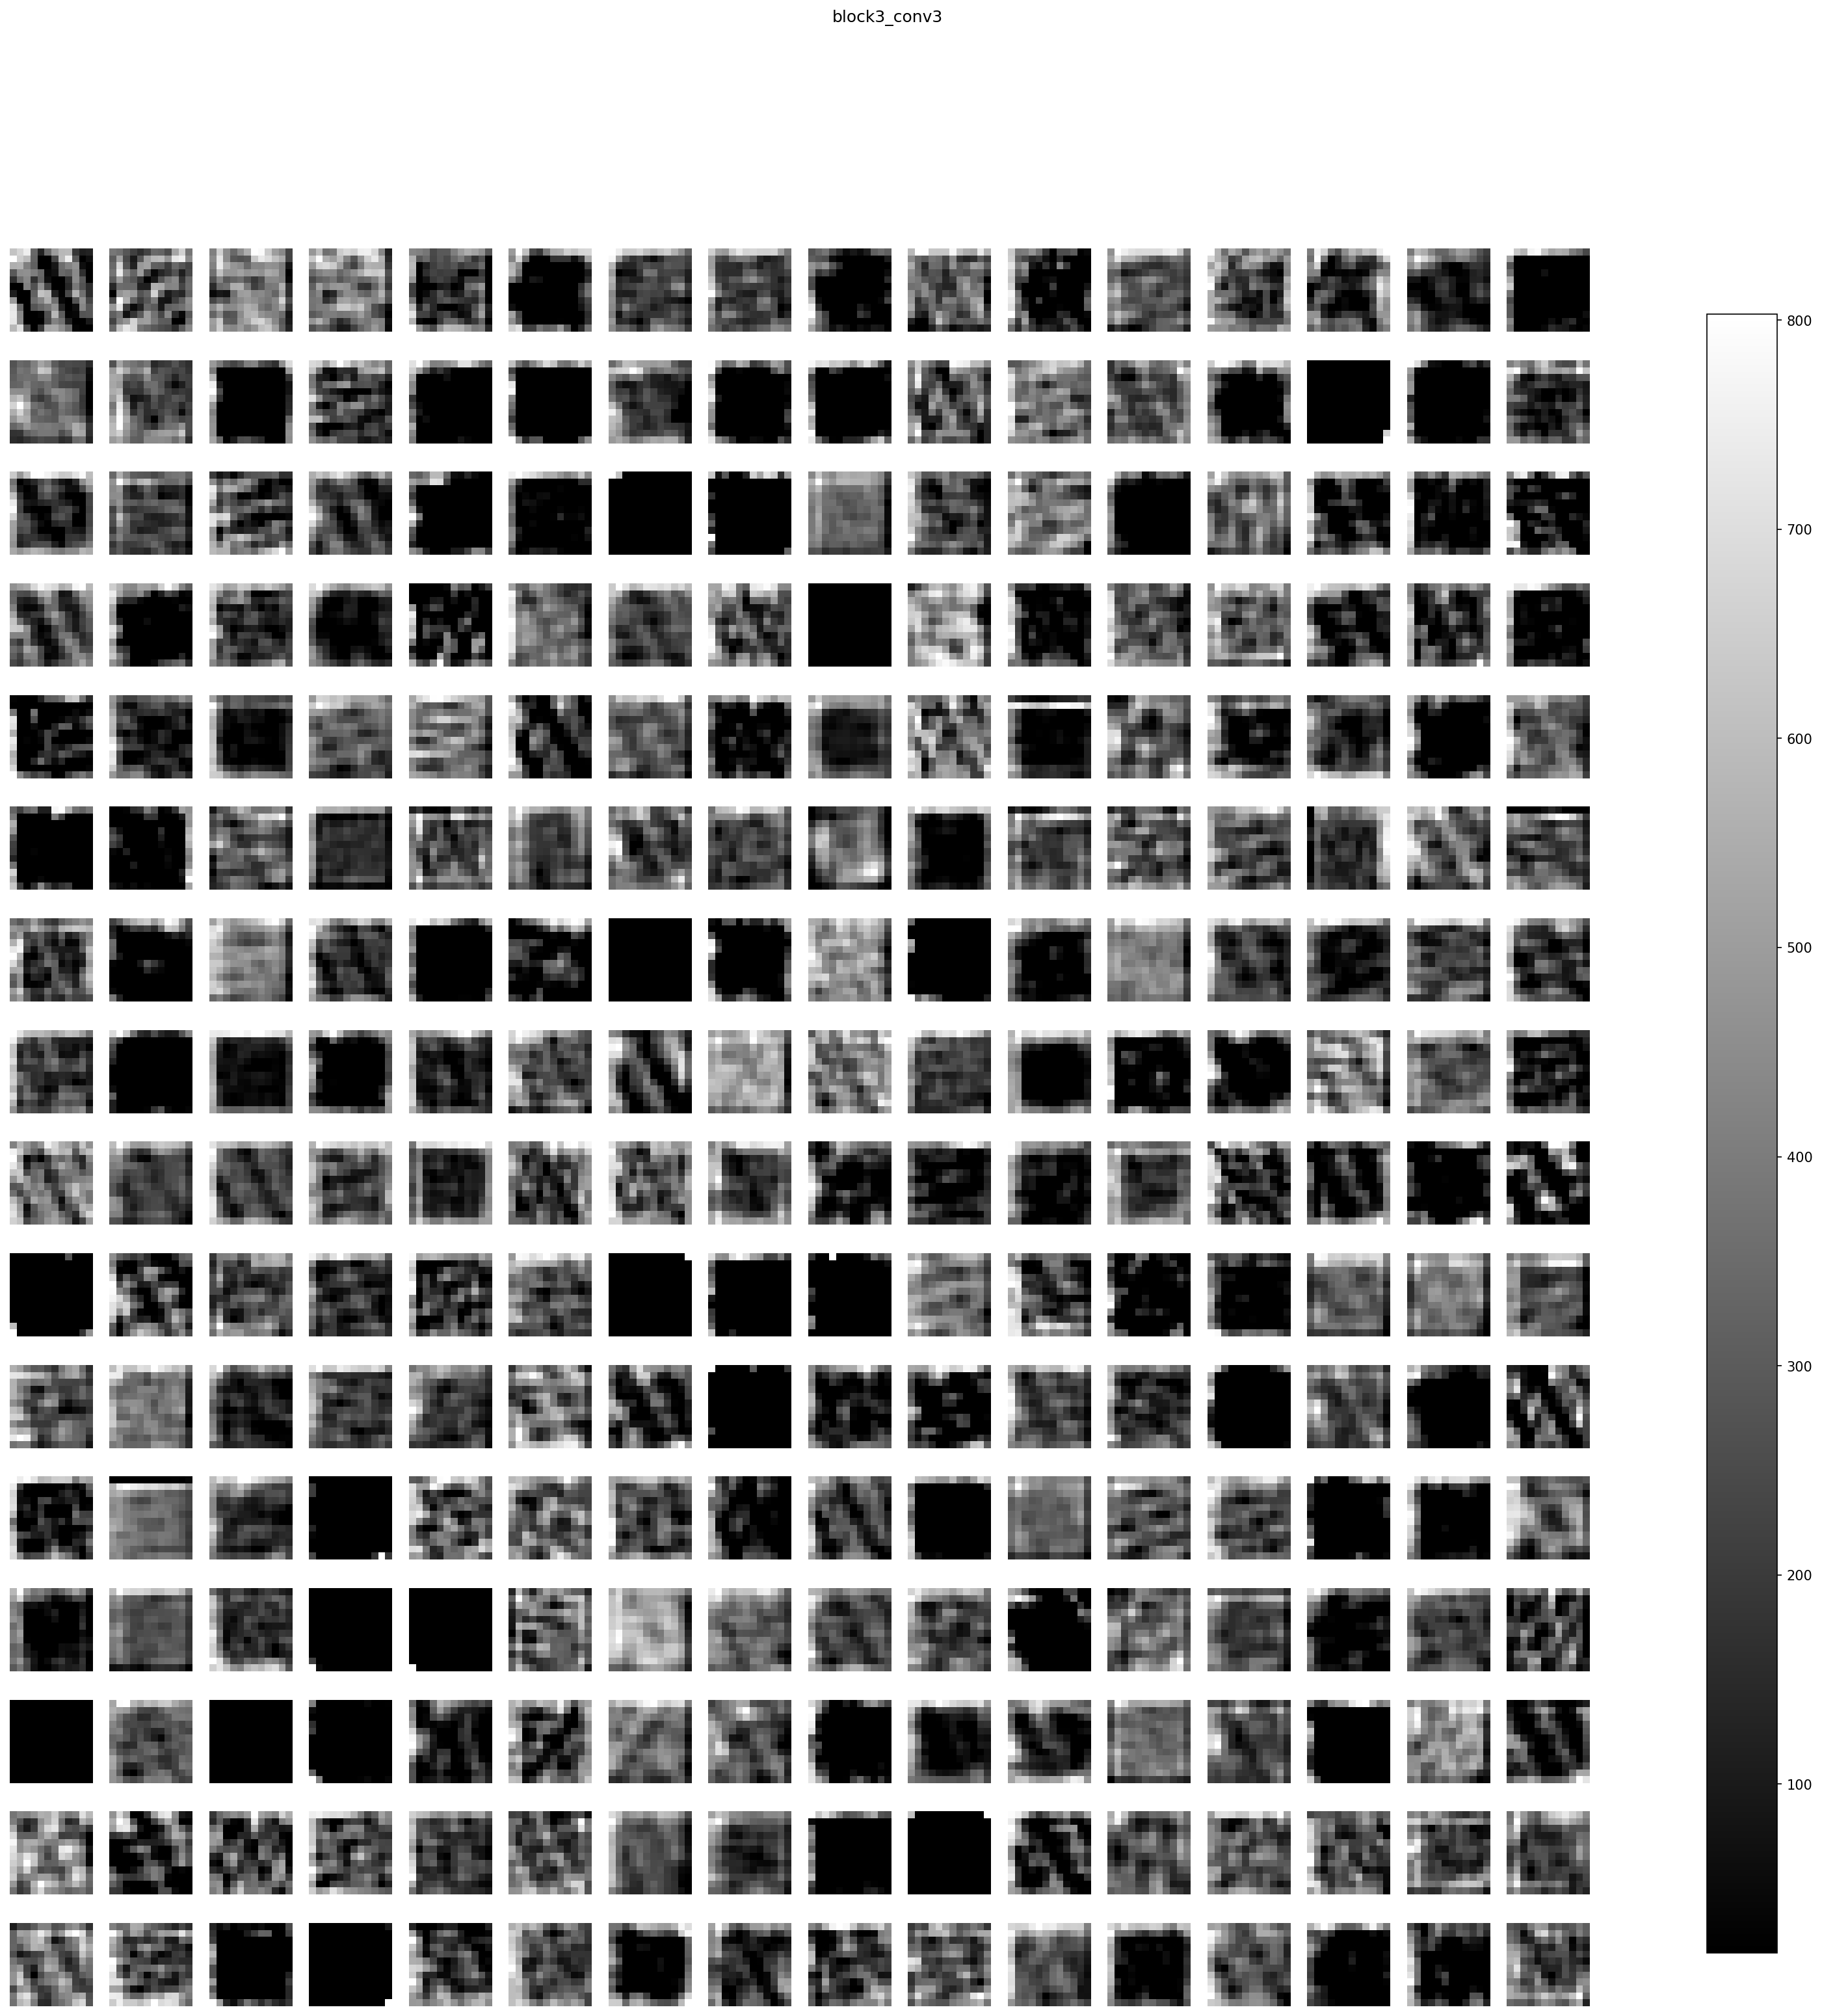

block3_conv4 (1, 12, 12, 256) 


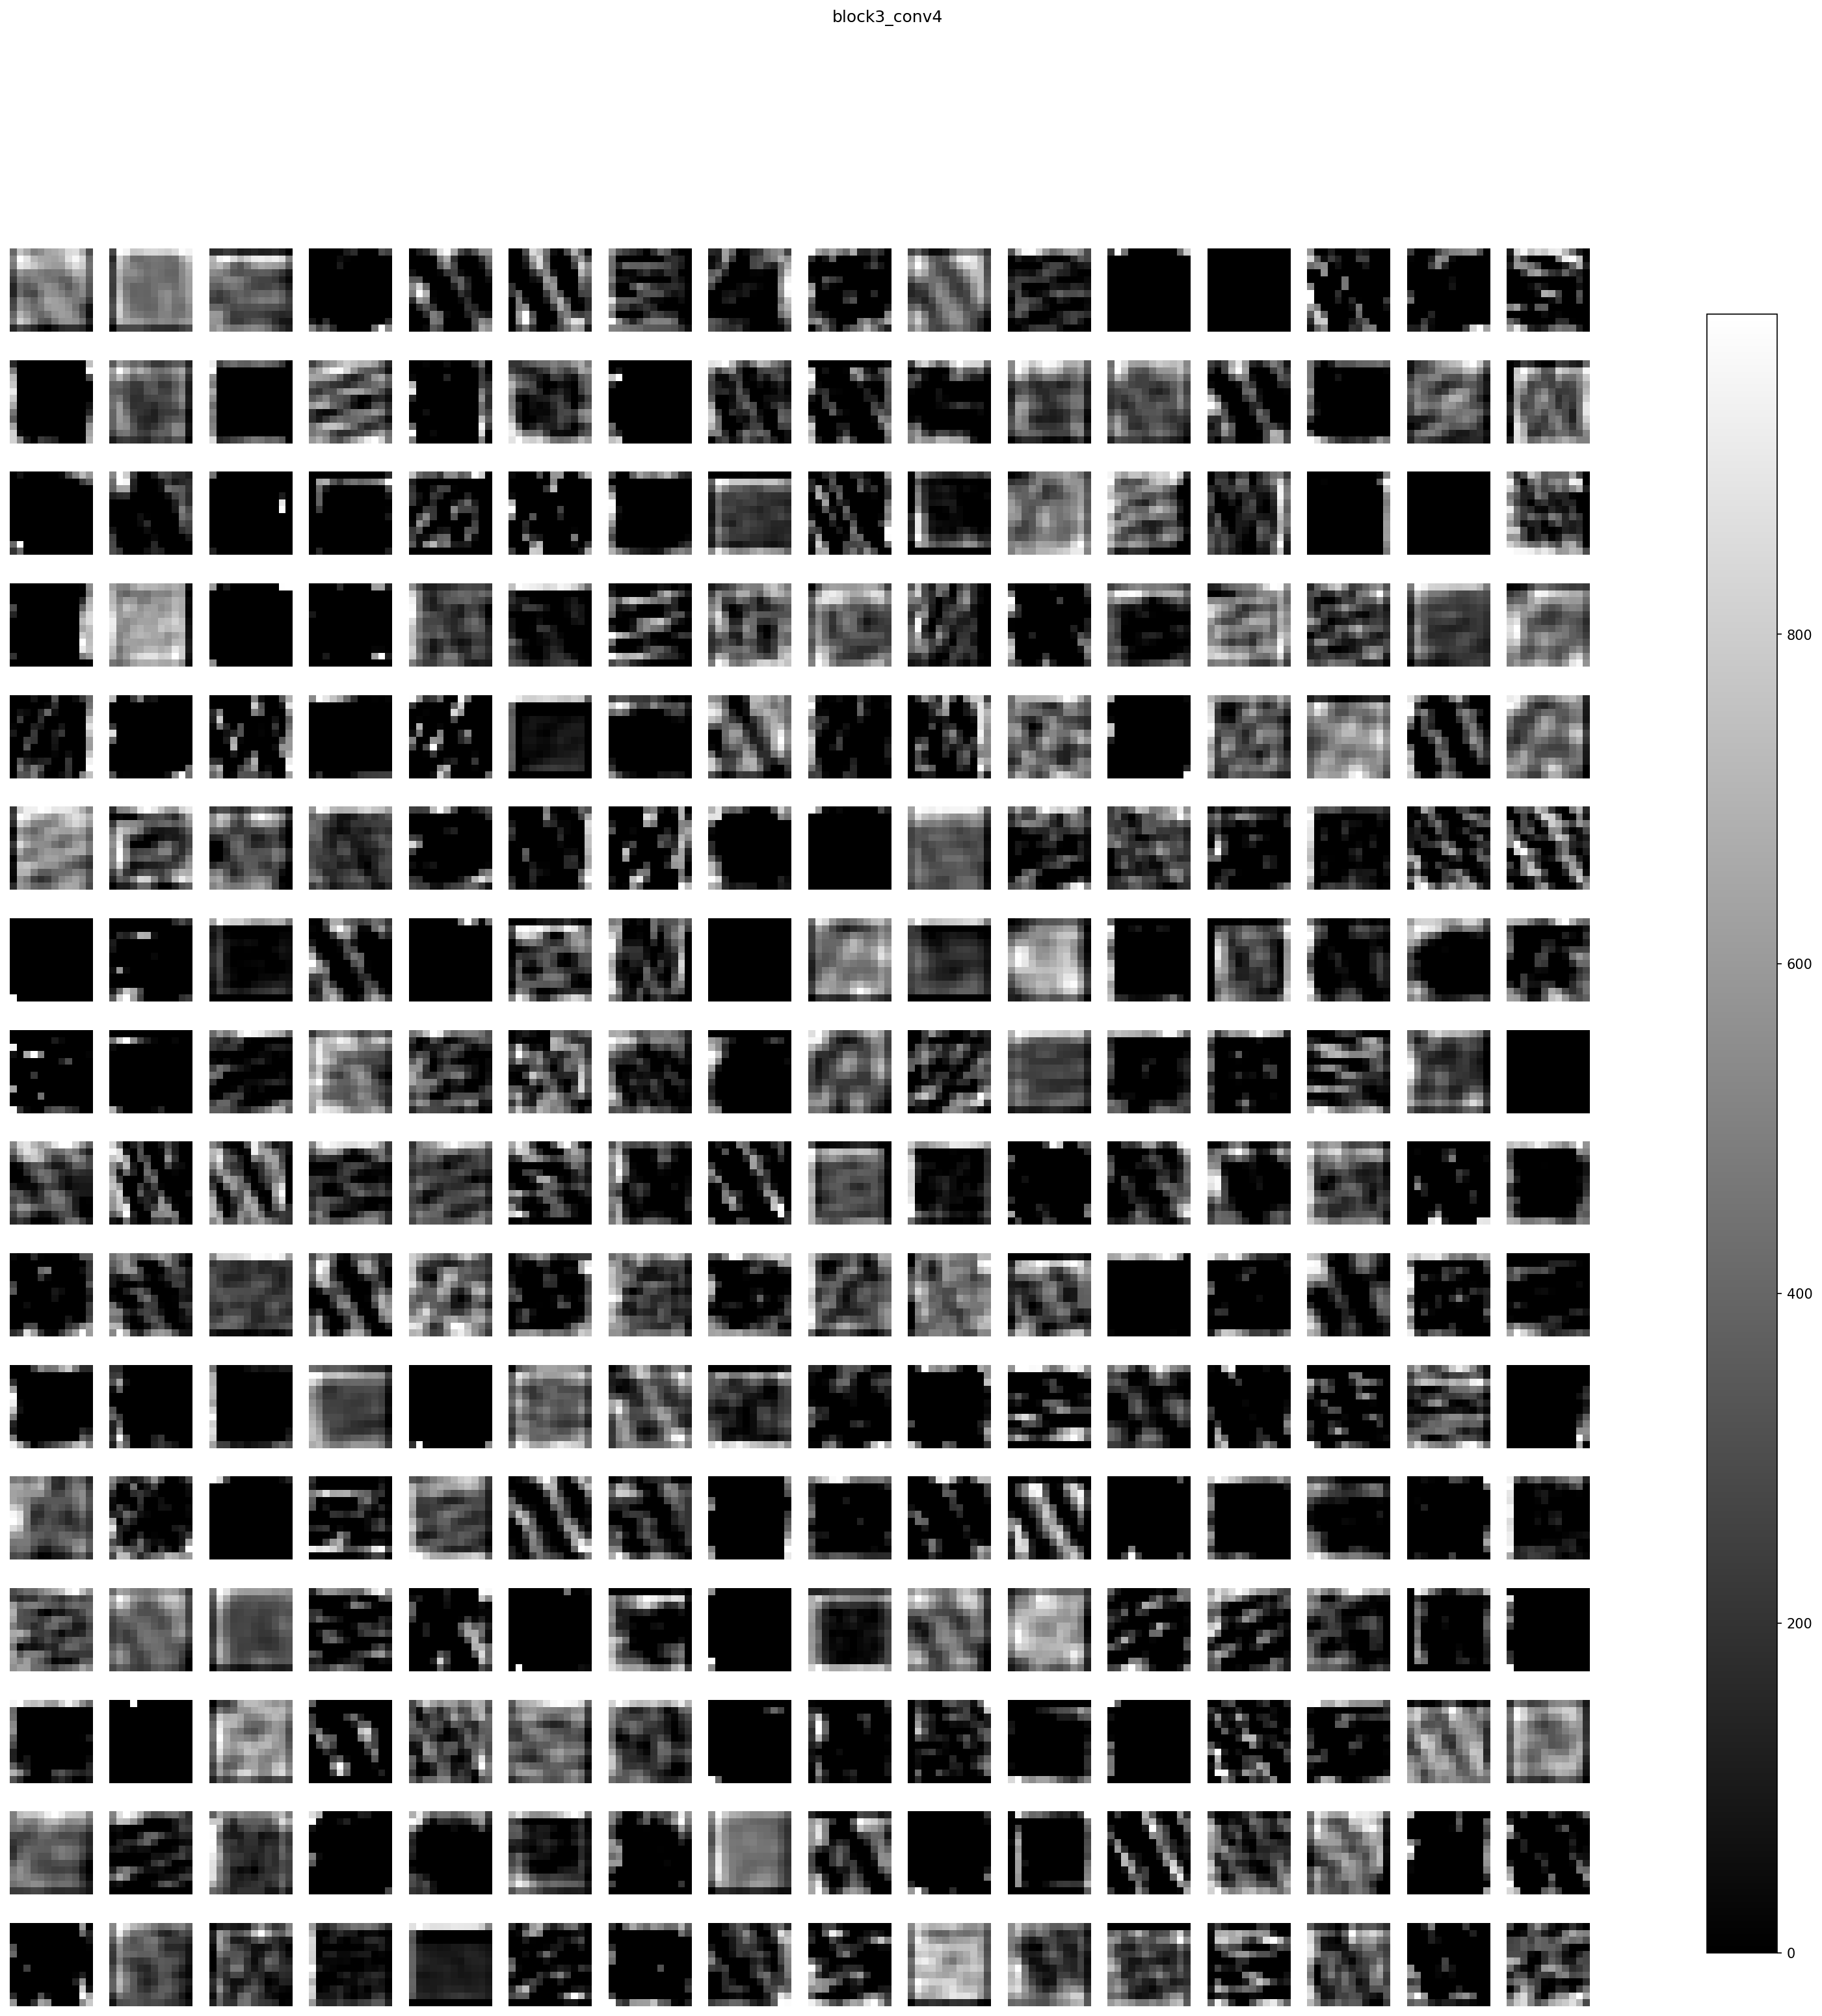

block3_pool (1, 6, 6, 256) 


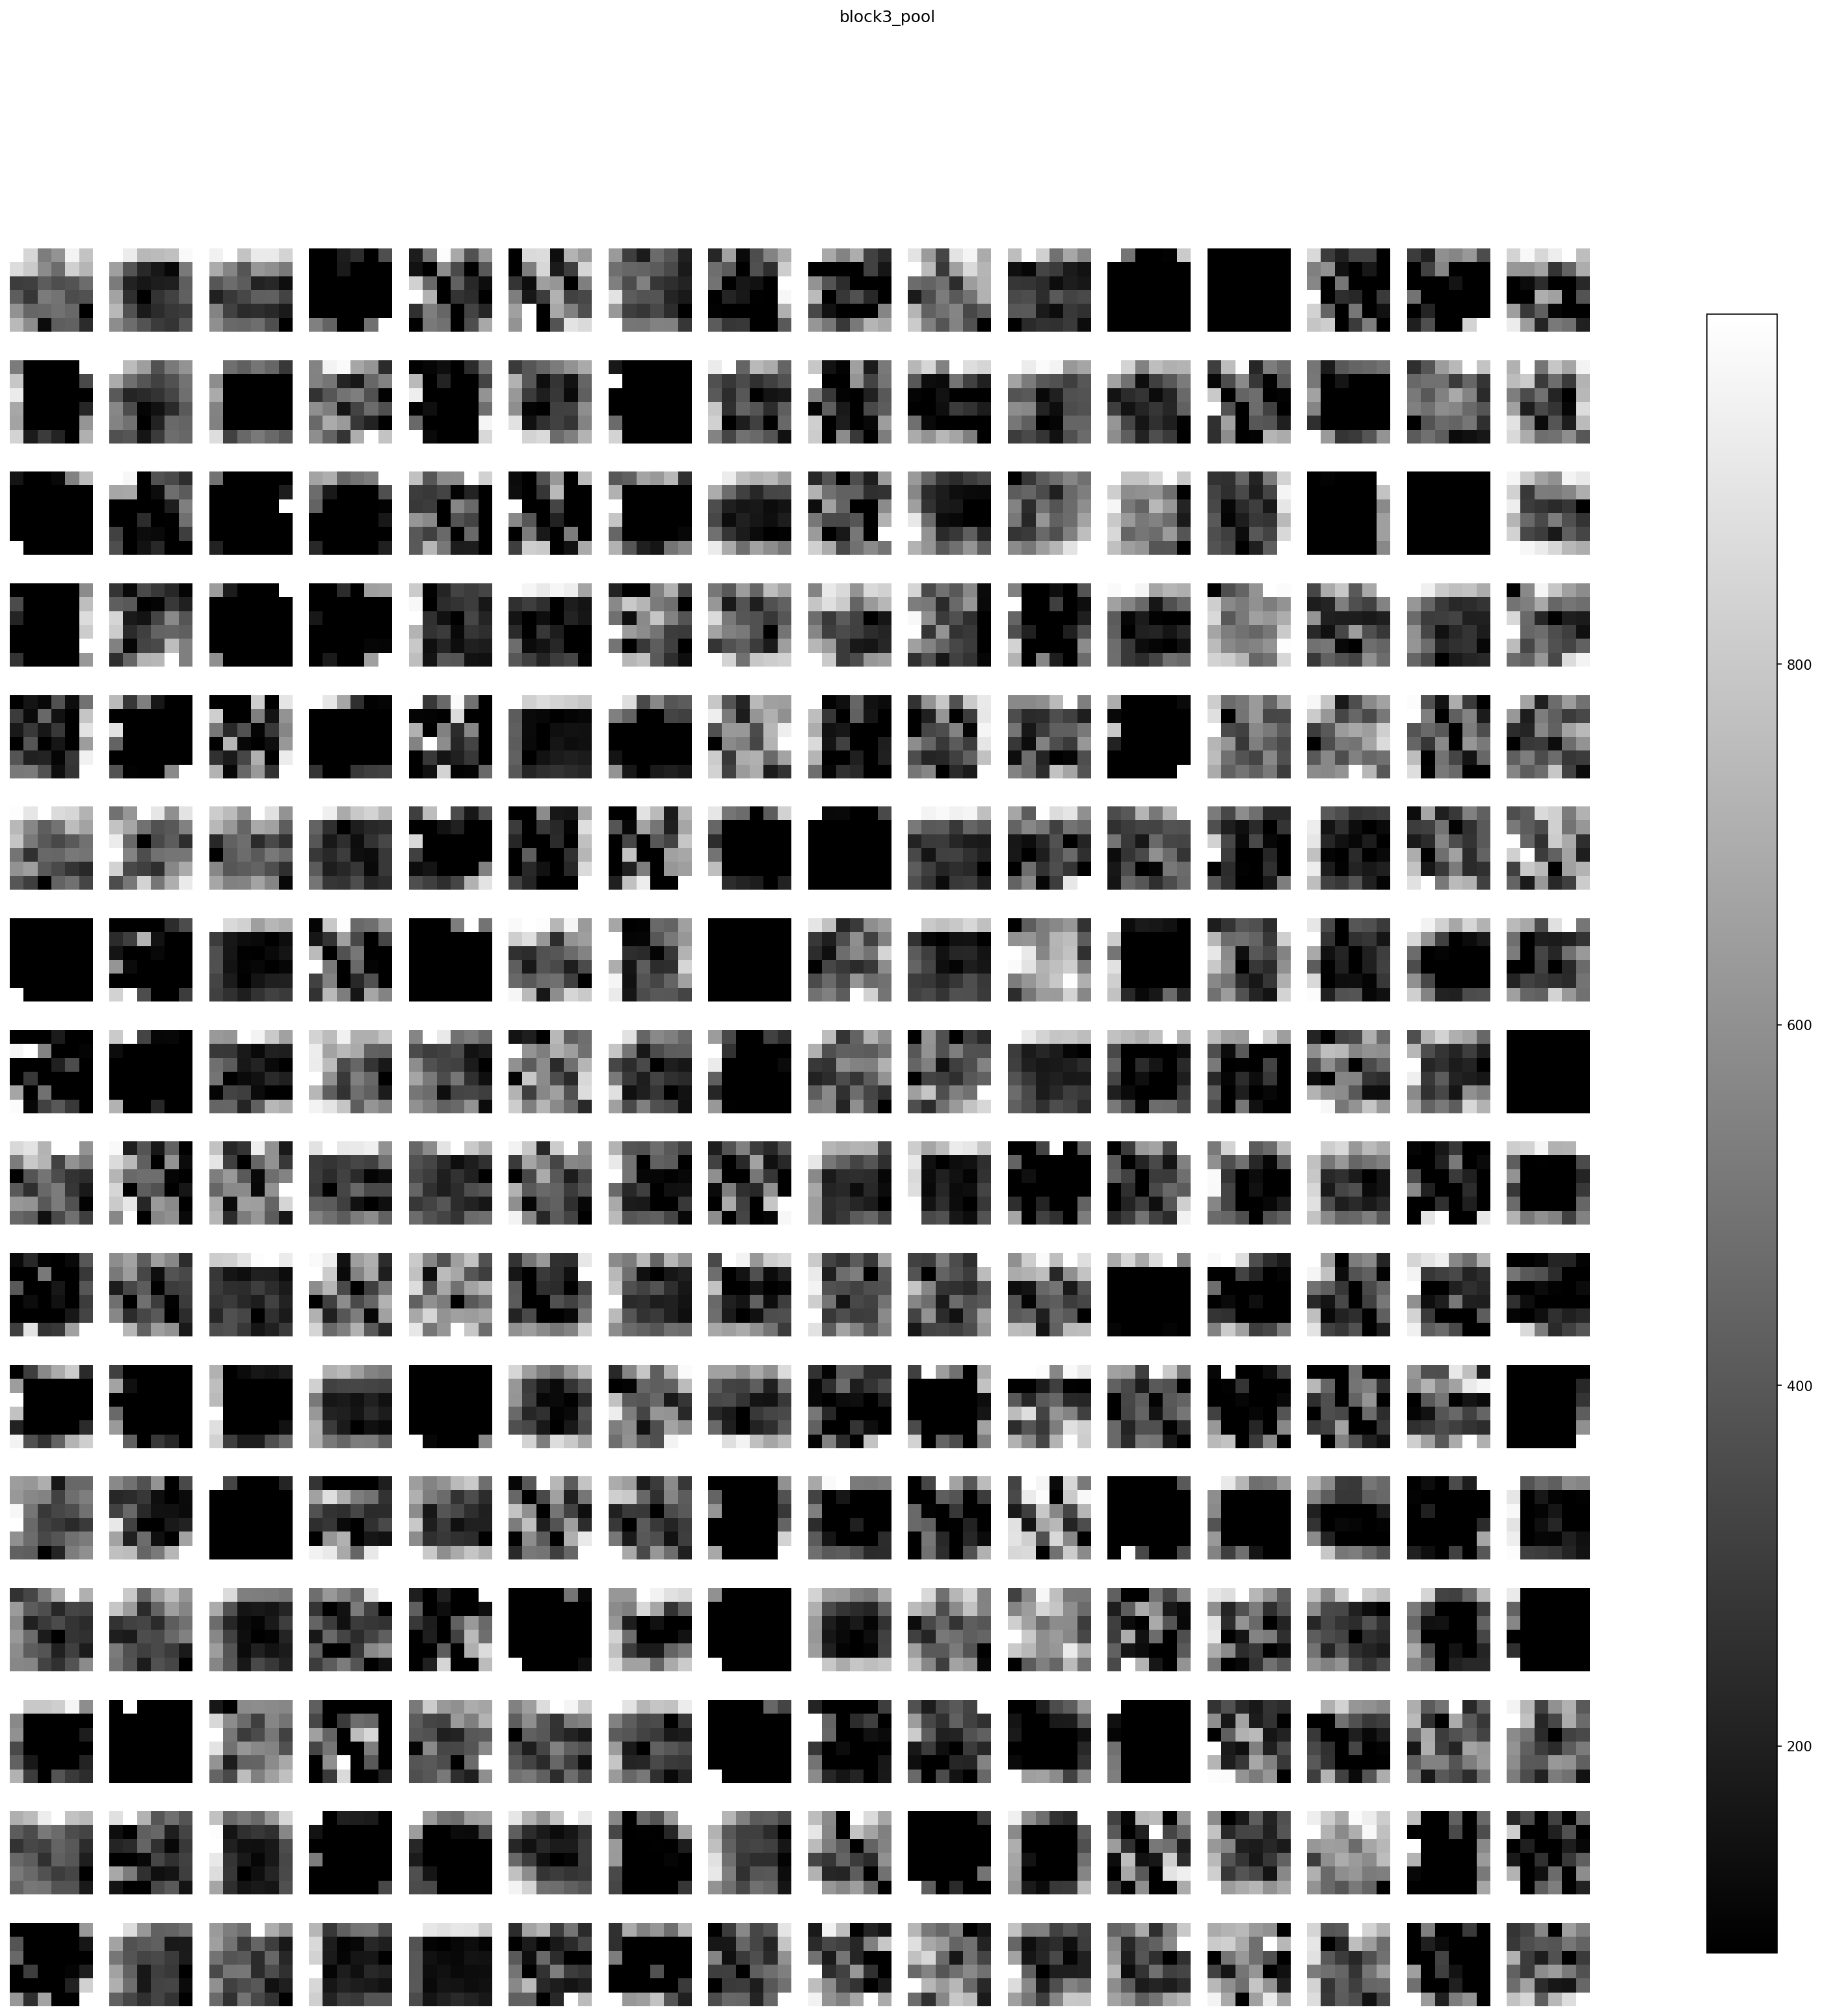

block4_conv1 (1, 6, 6, 512) 


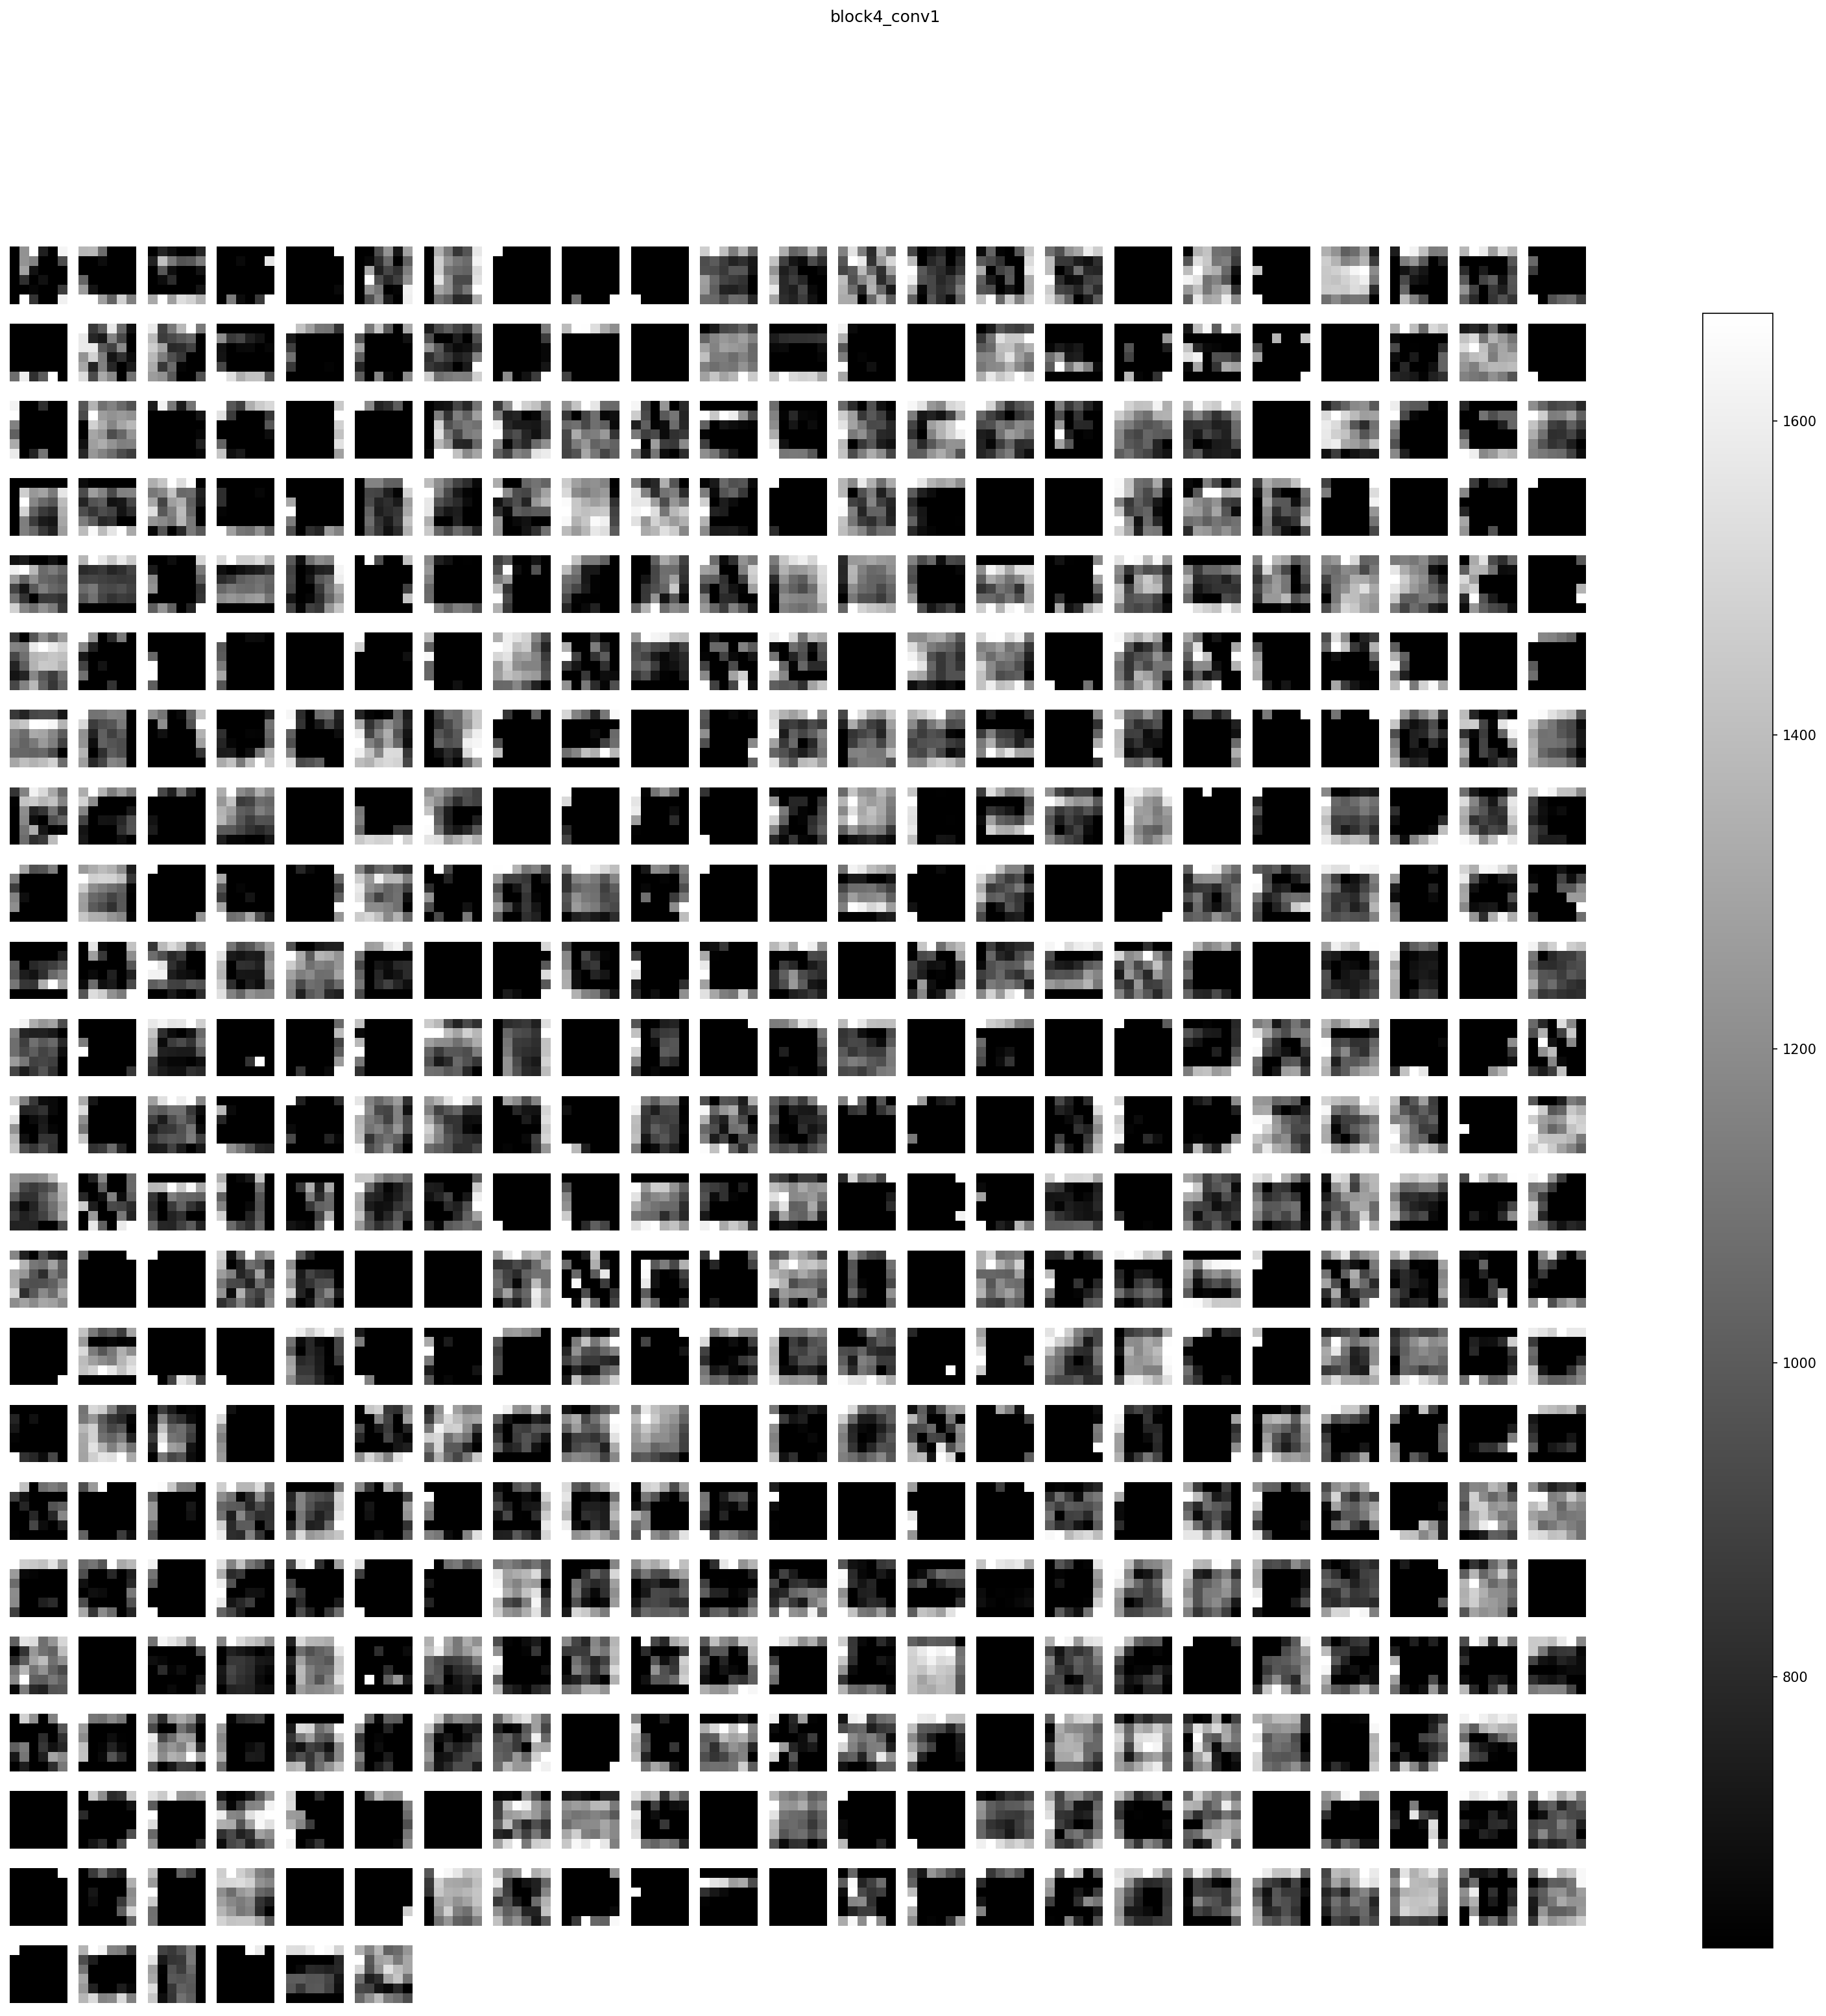

block4_conv2 (1, 6, 6, 512) 


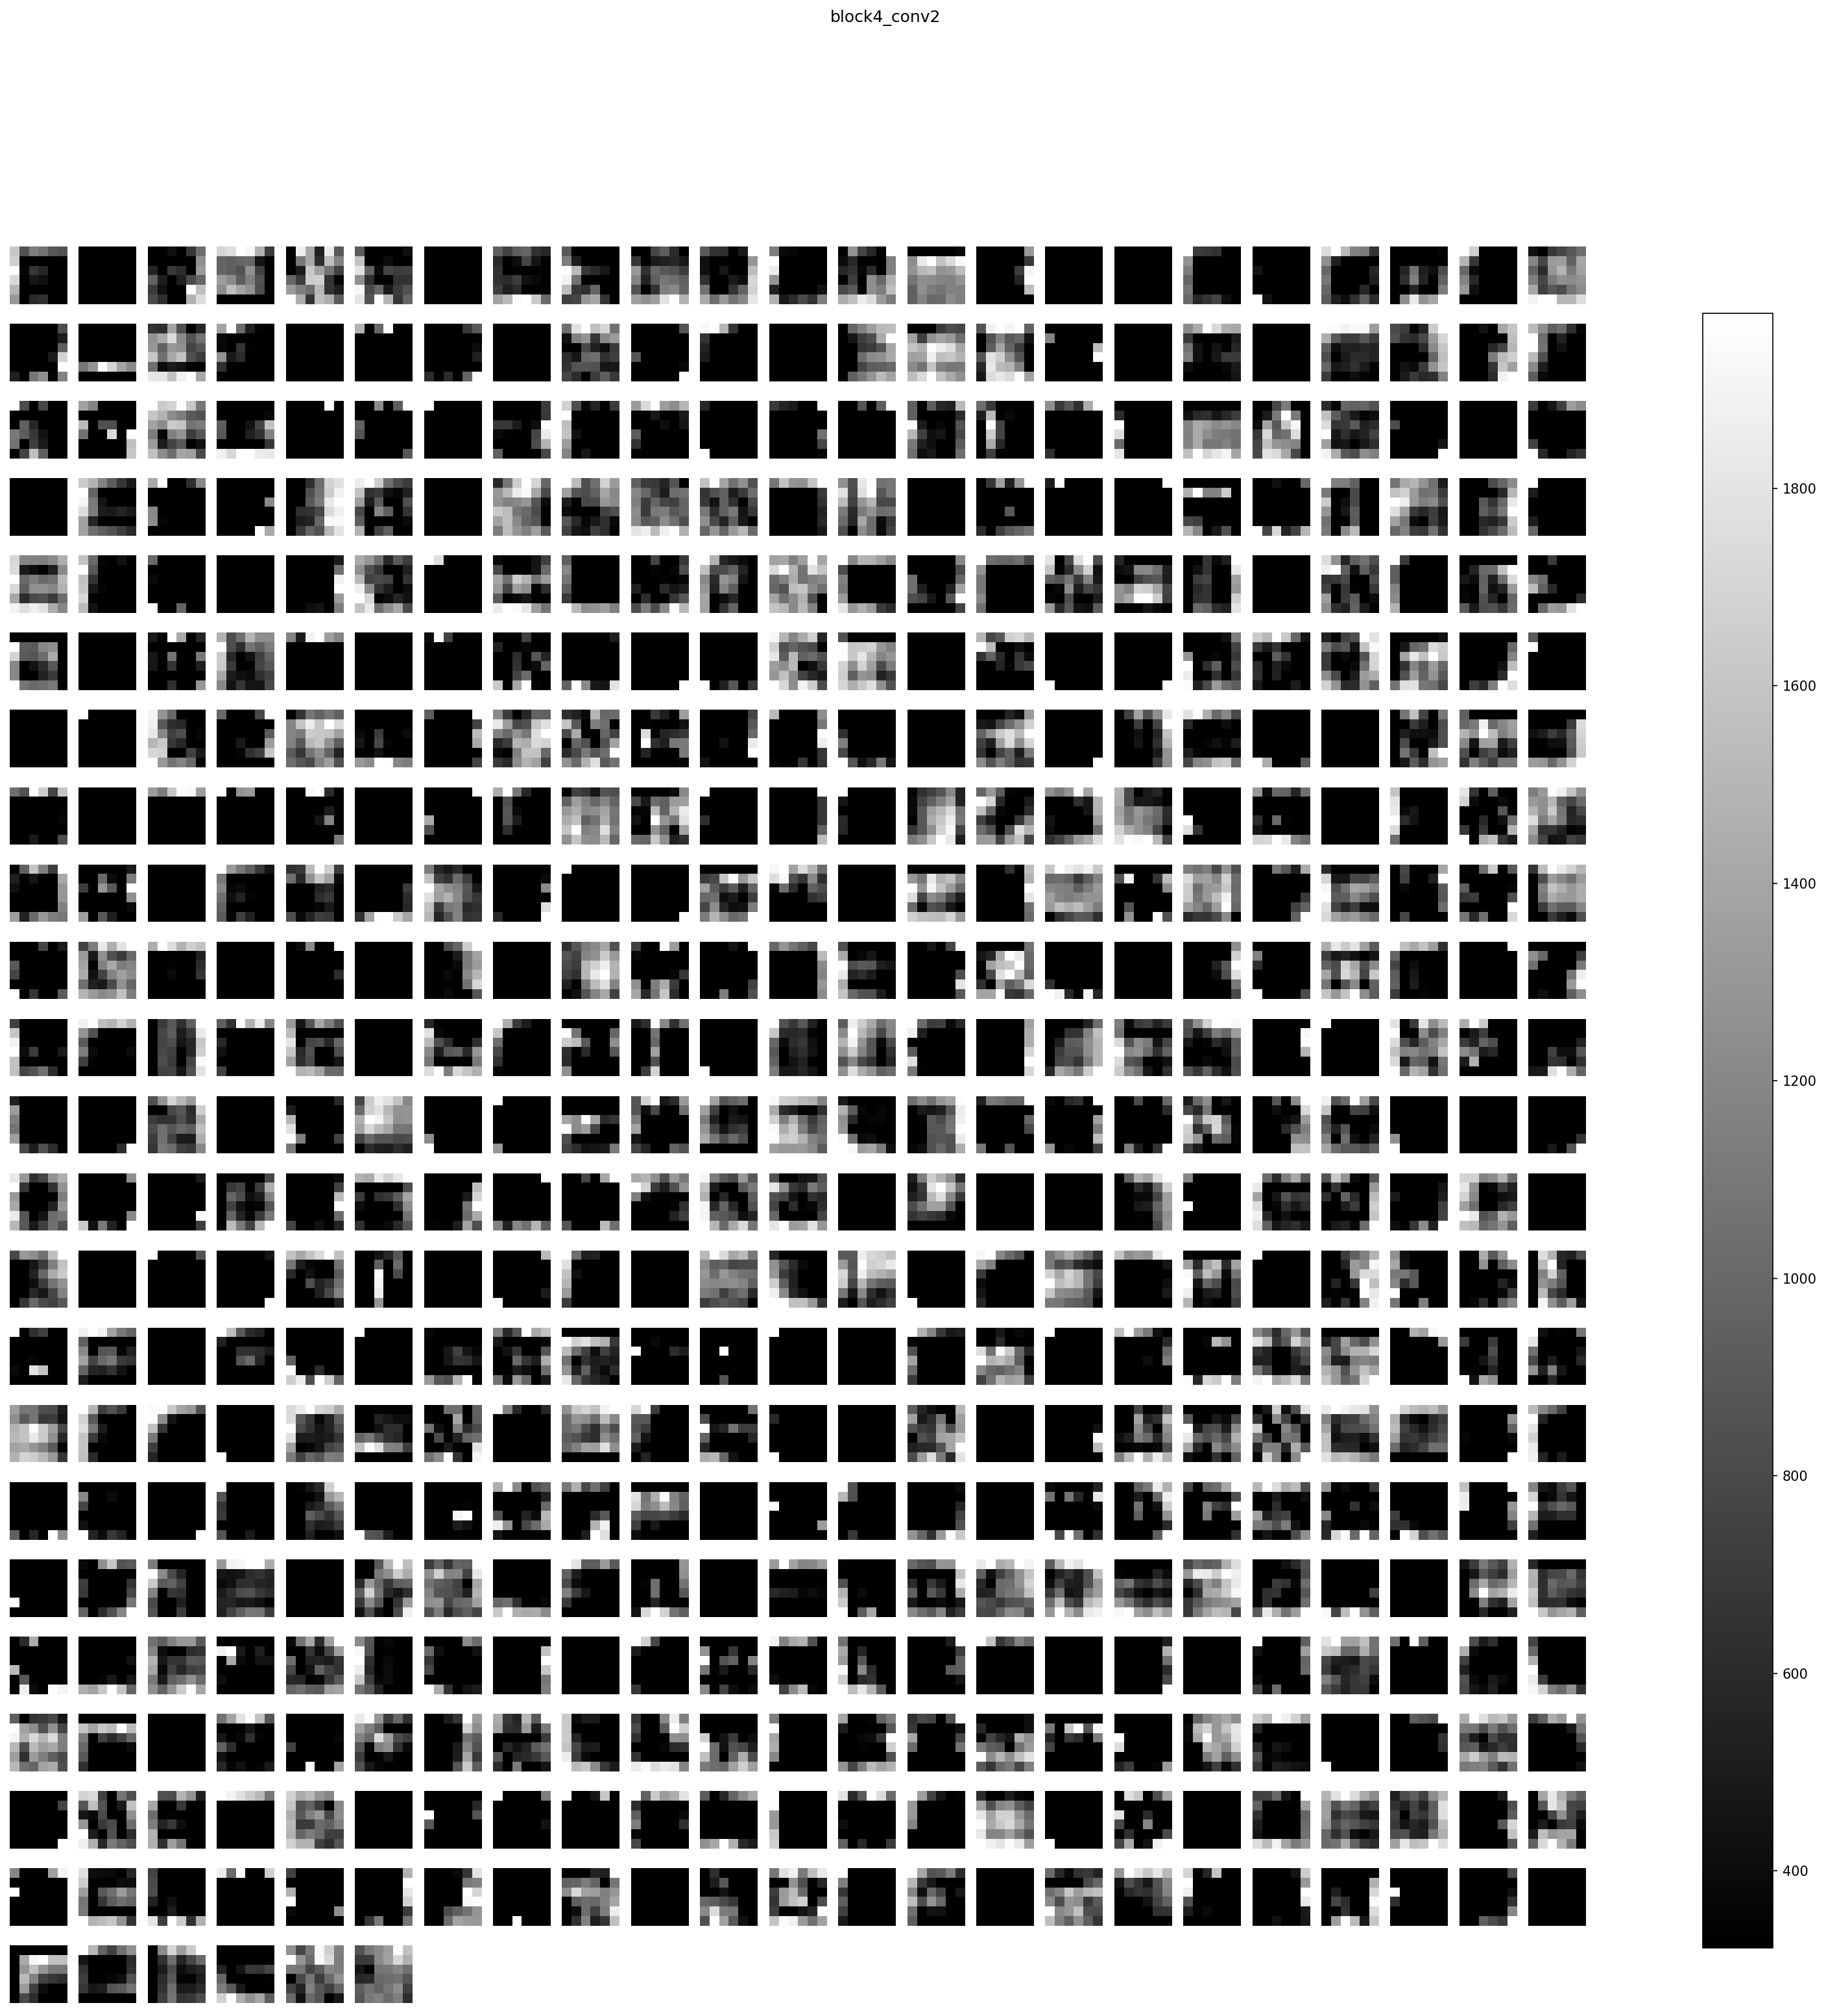

block4_conv3 (1, 6, 6, 512) 


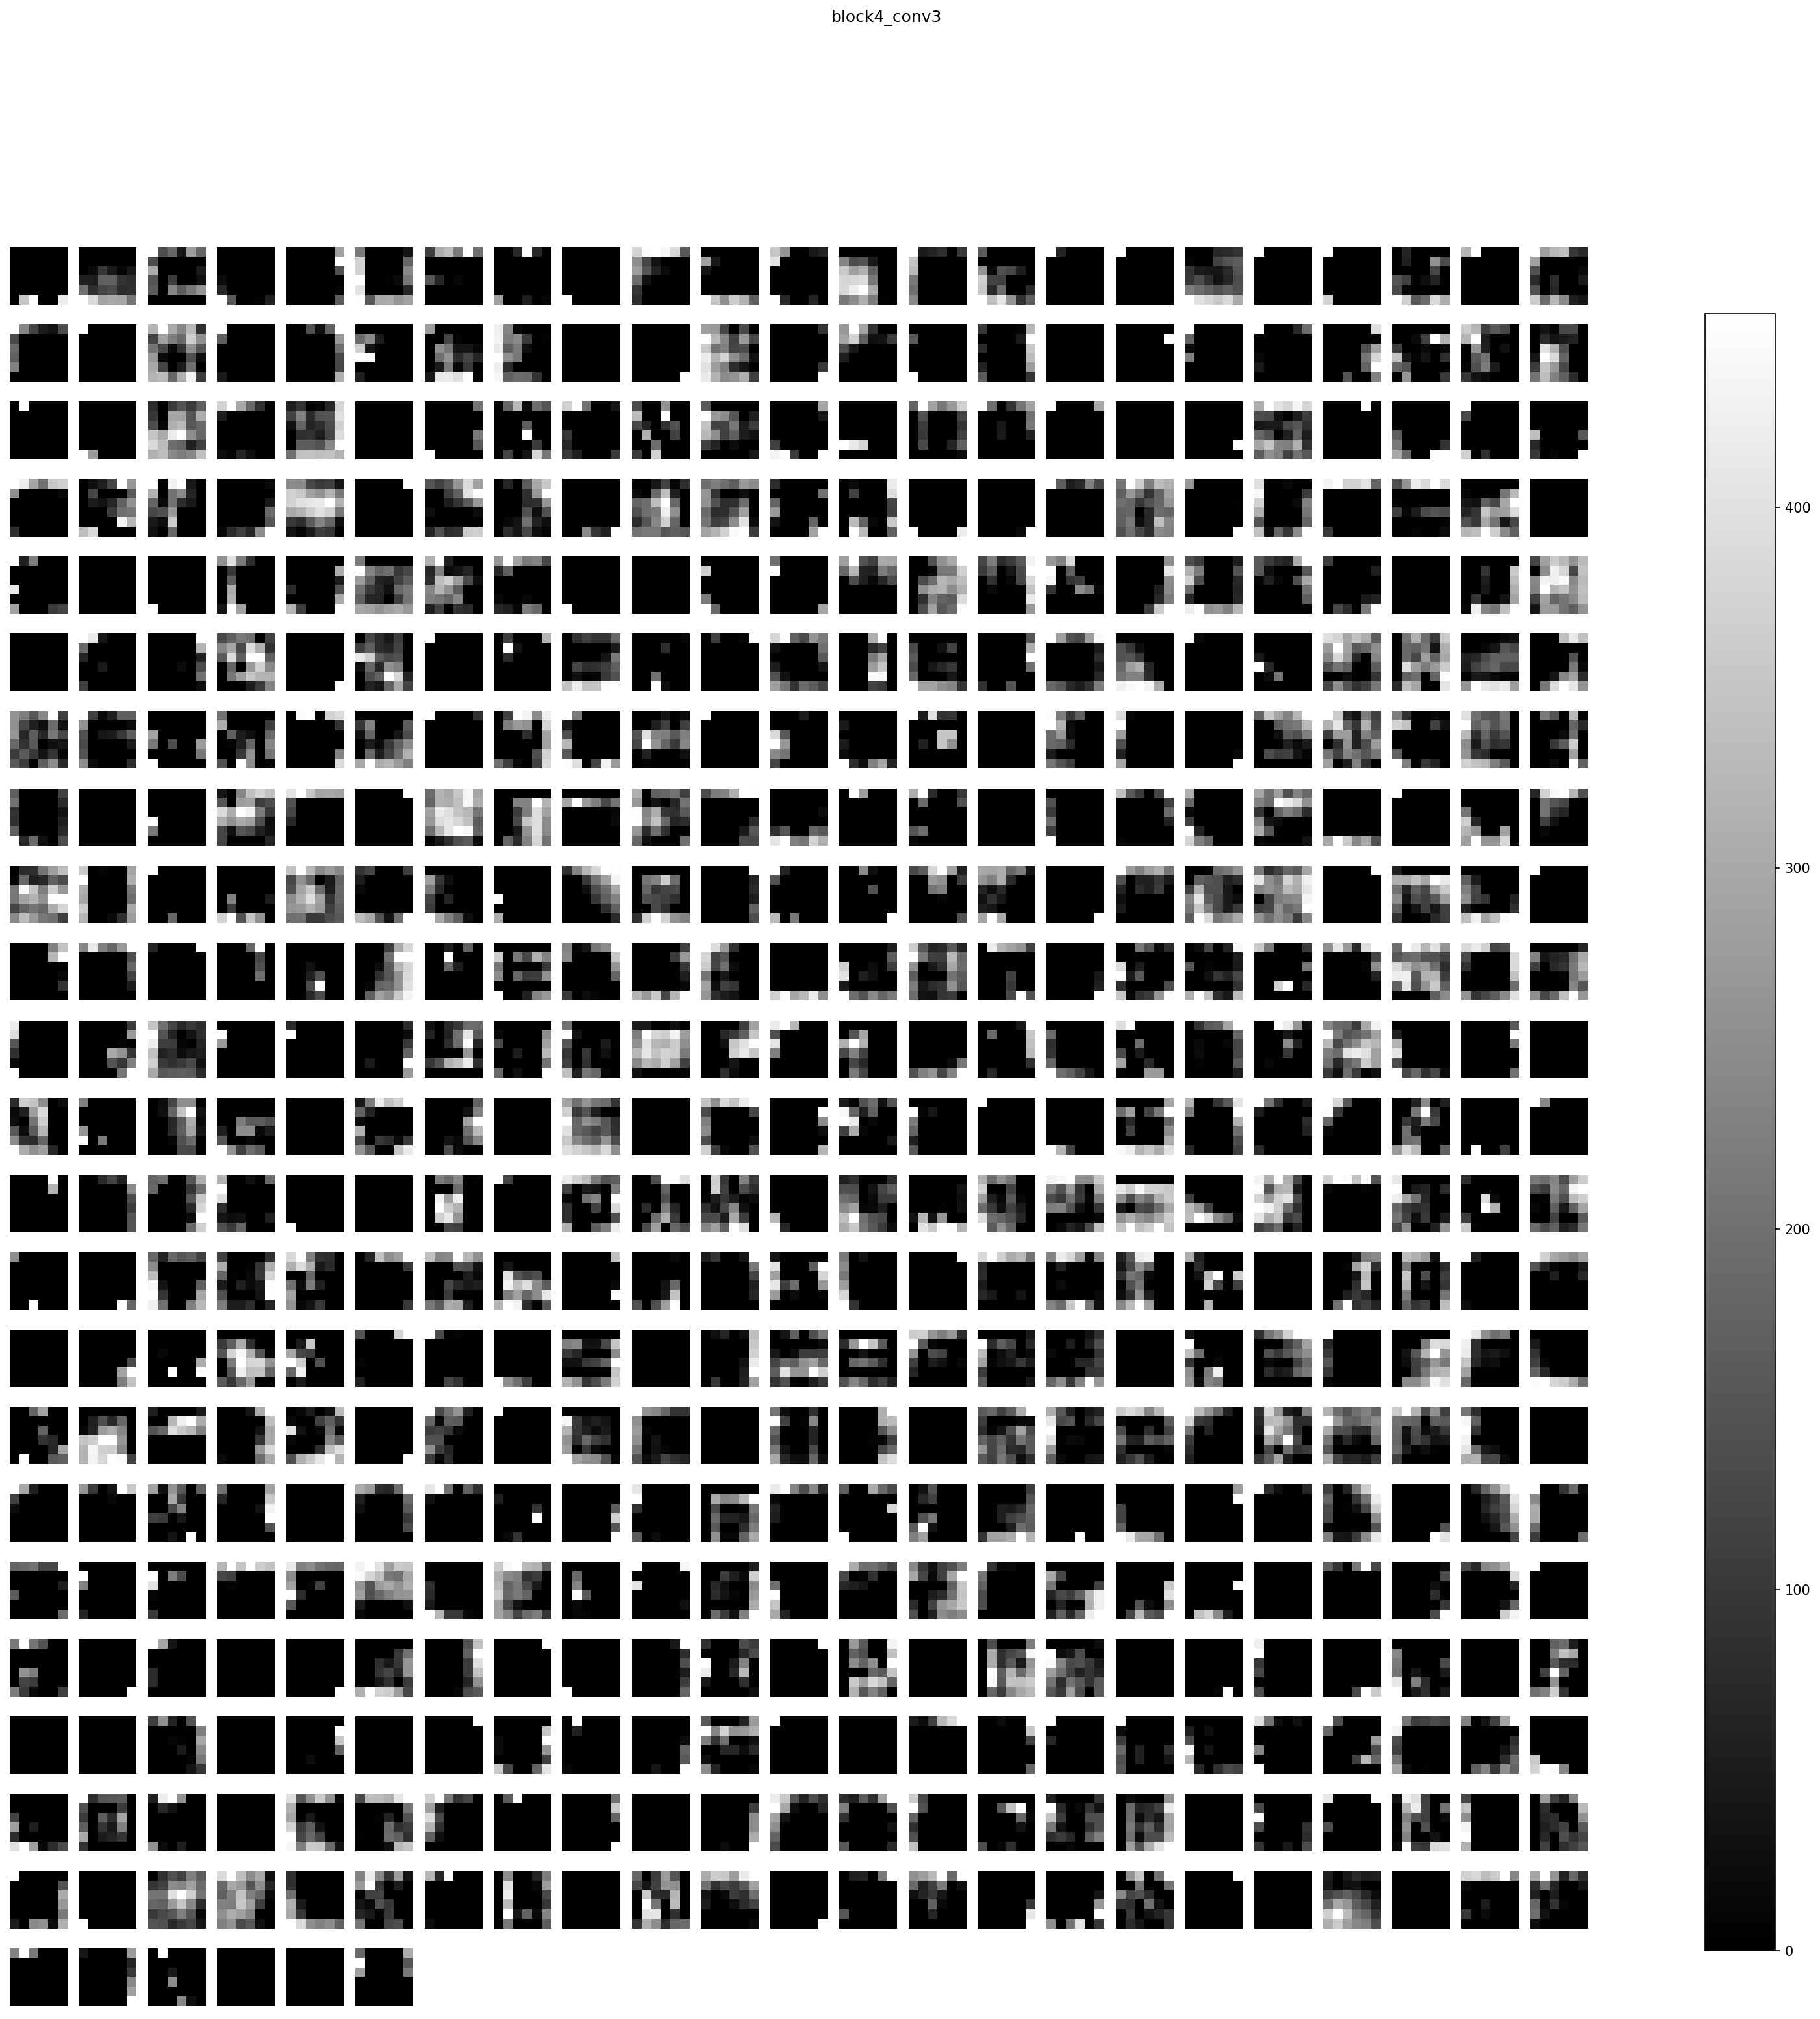

block4_conv4 (1, 6, 6, 512) 


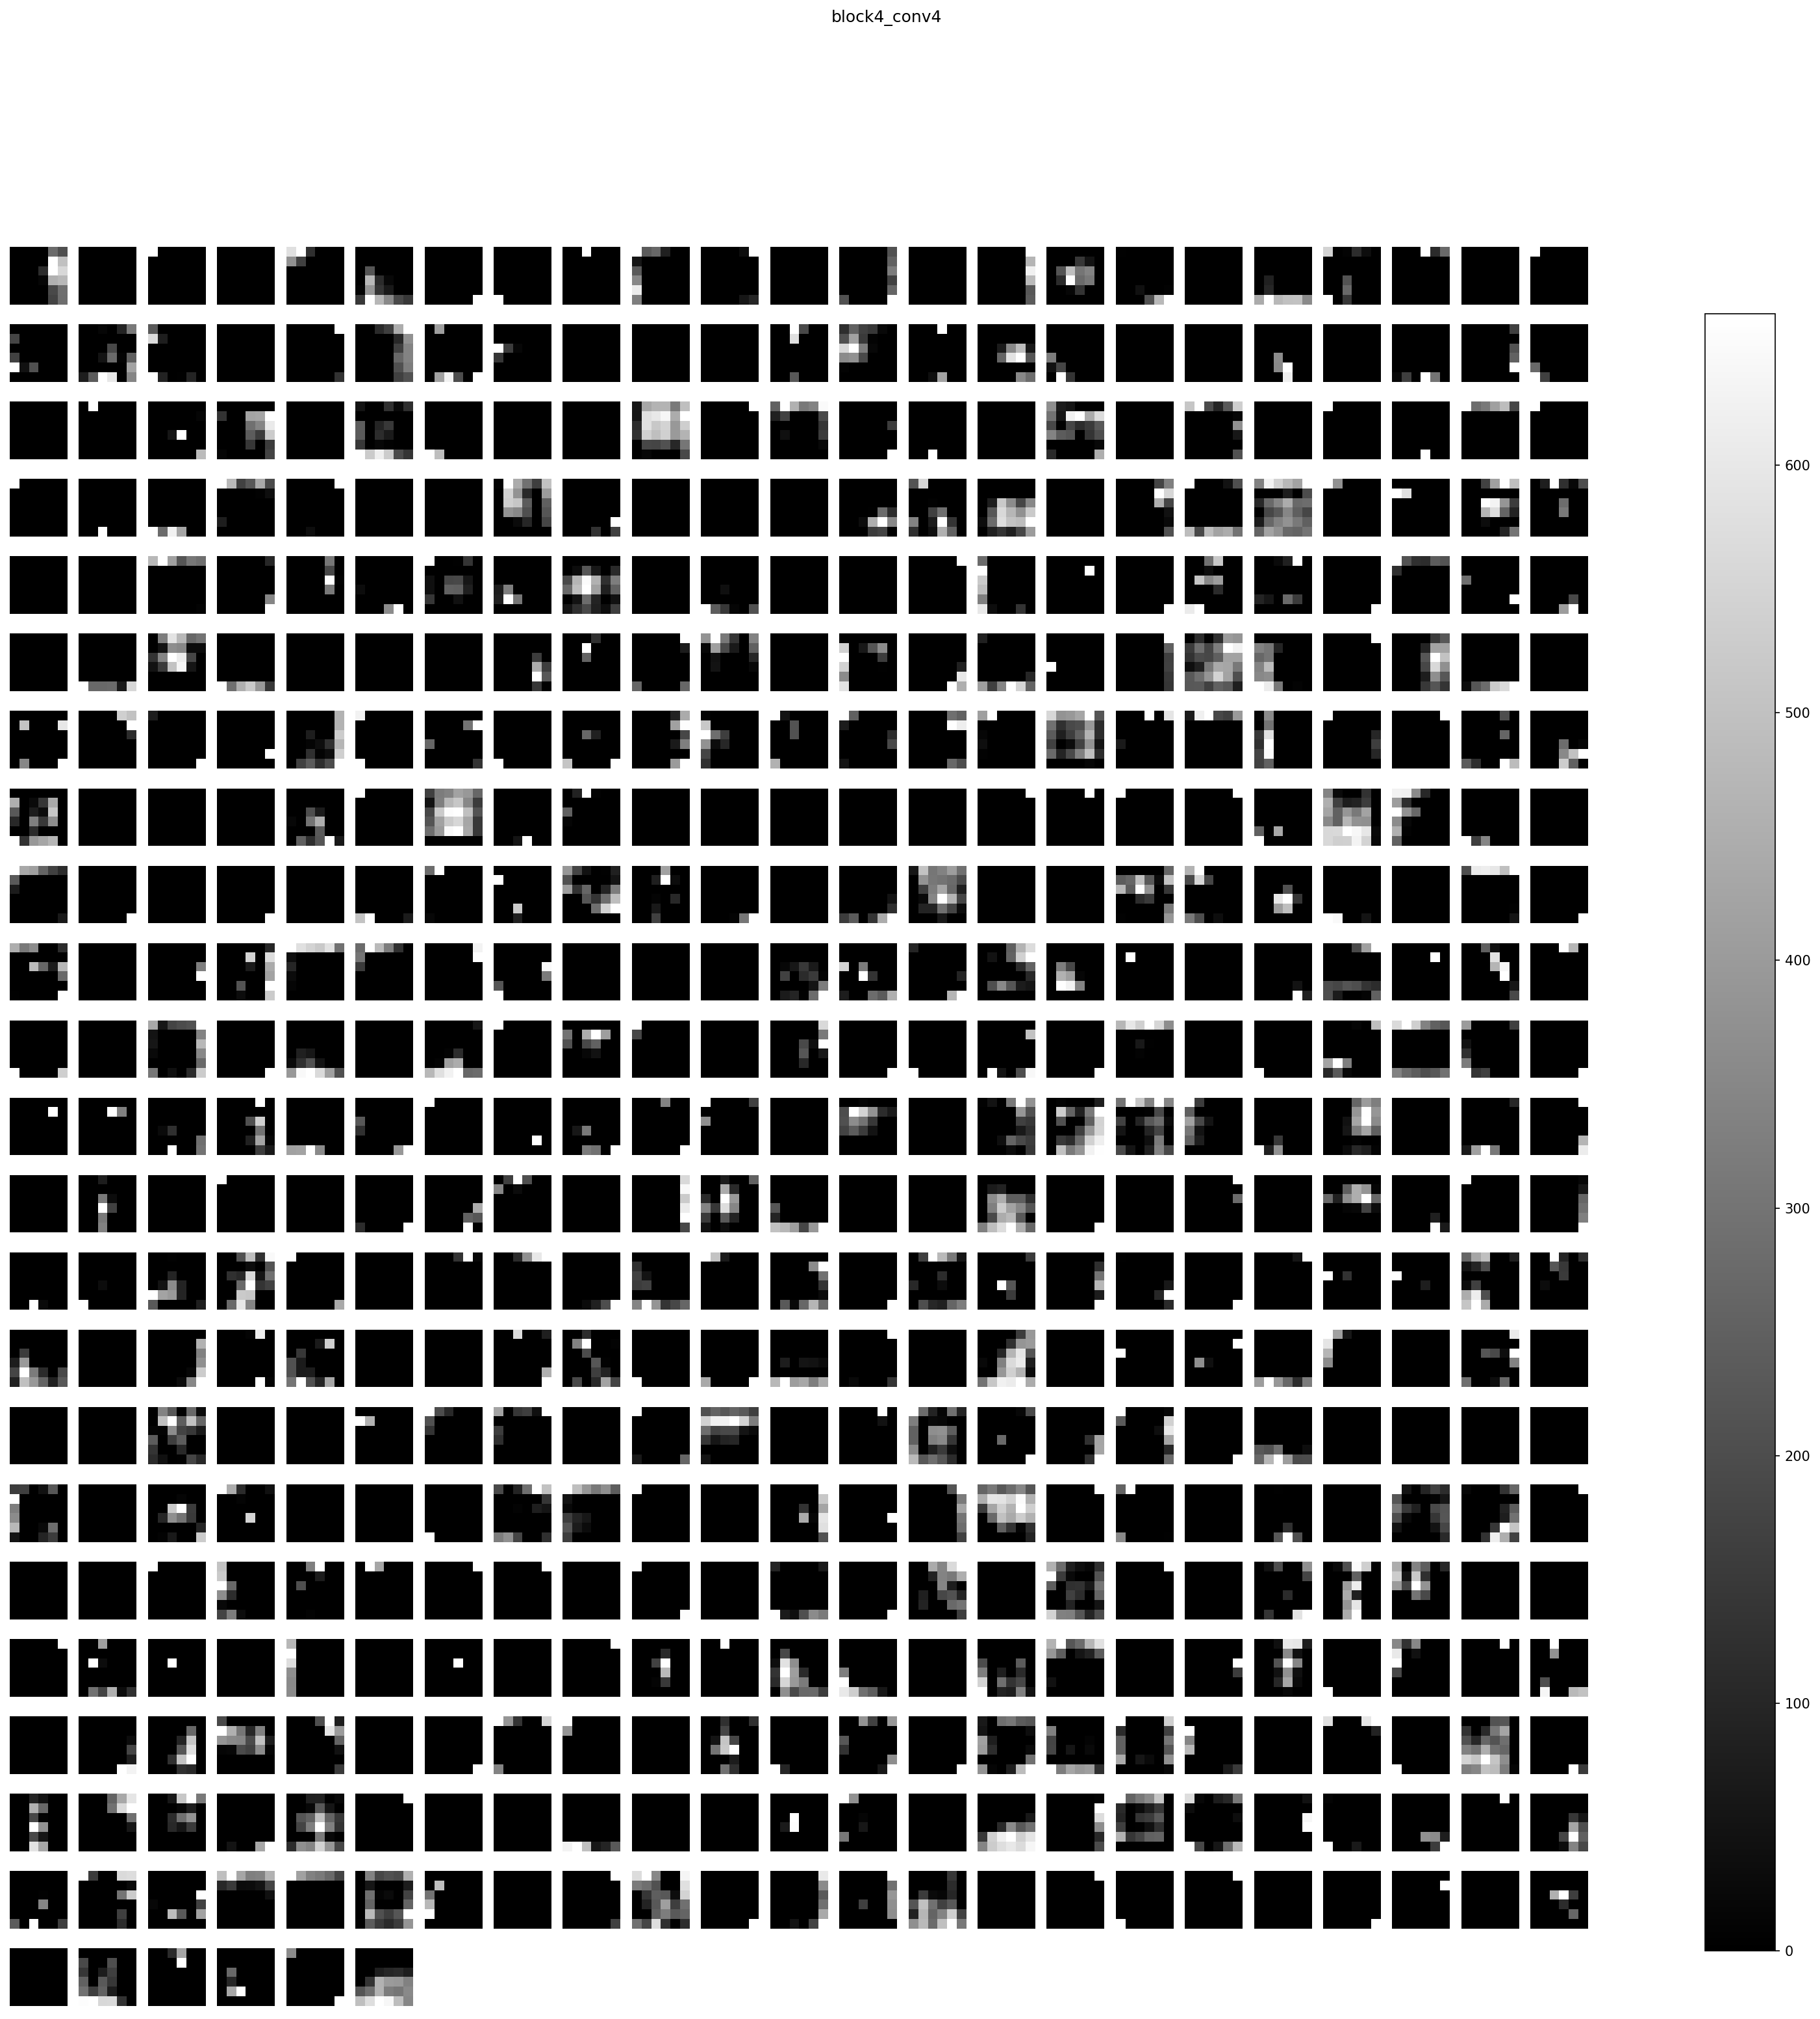

block4_pool (1, 3, 3, 512) 


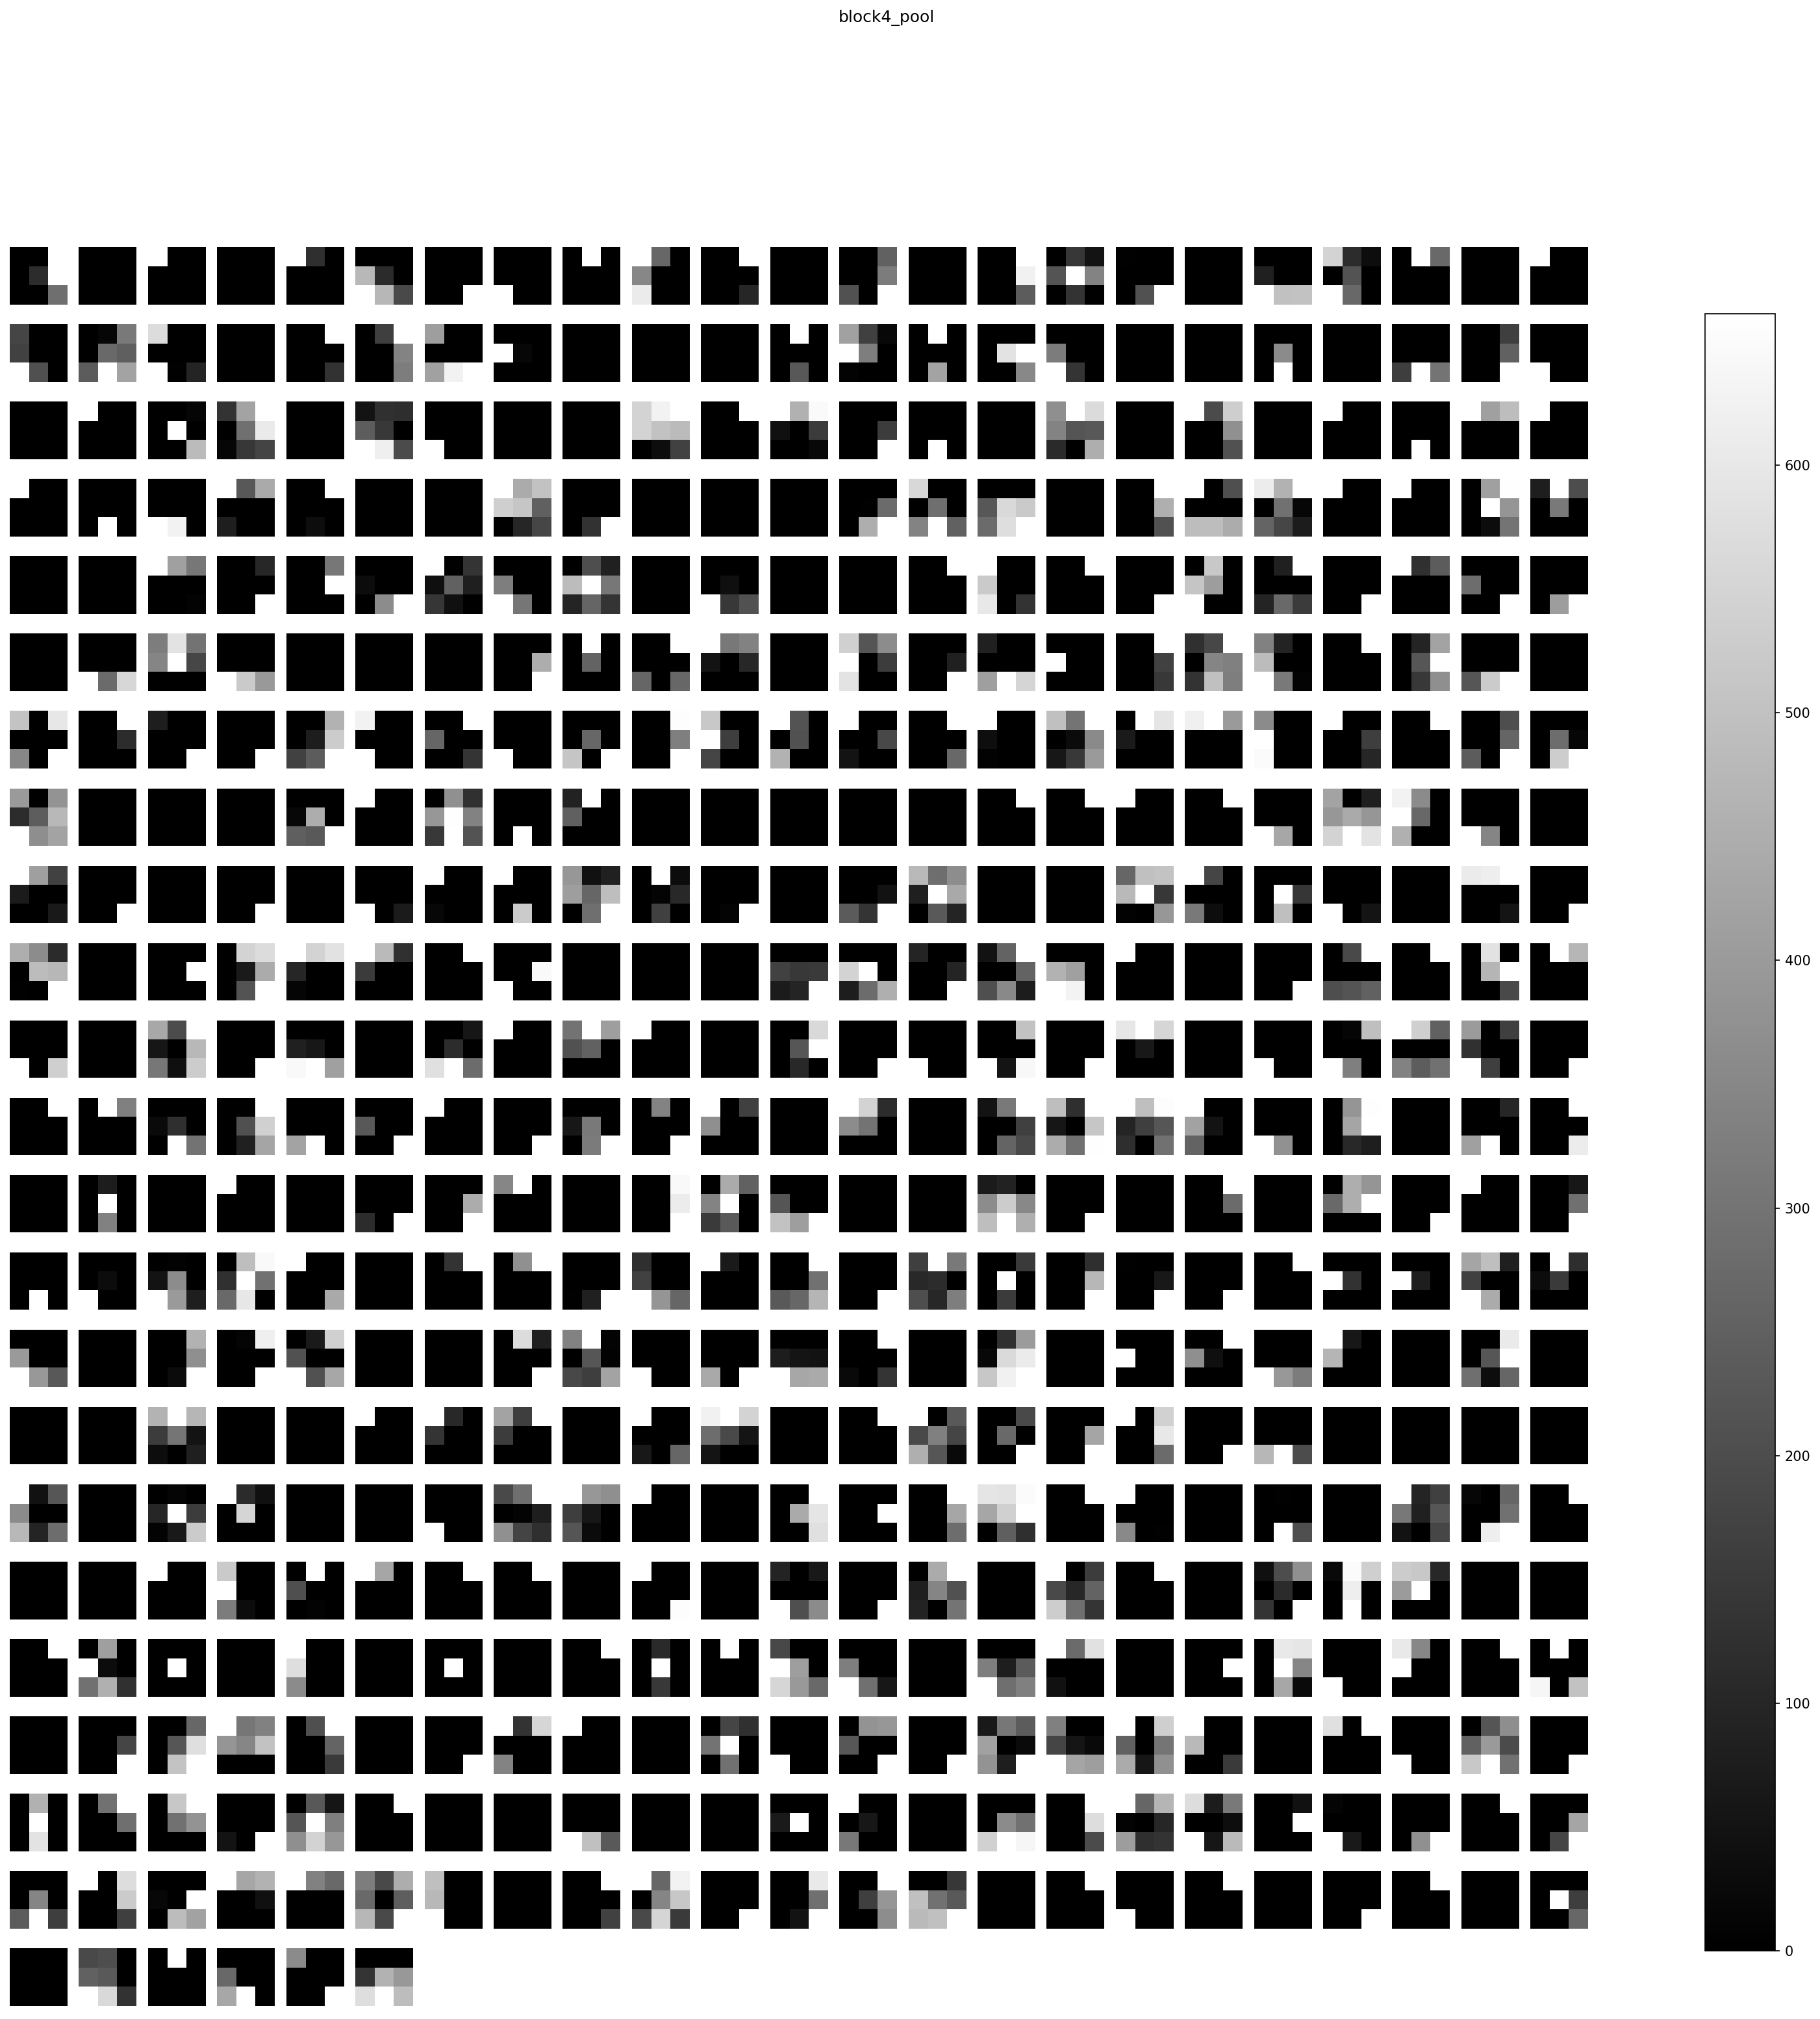

block5_conv1 (1, 3, 3, 512) 


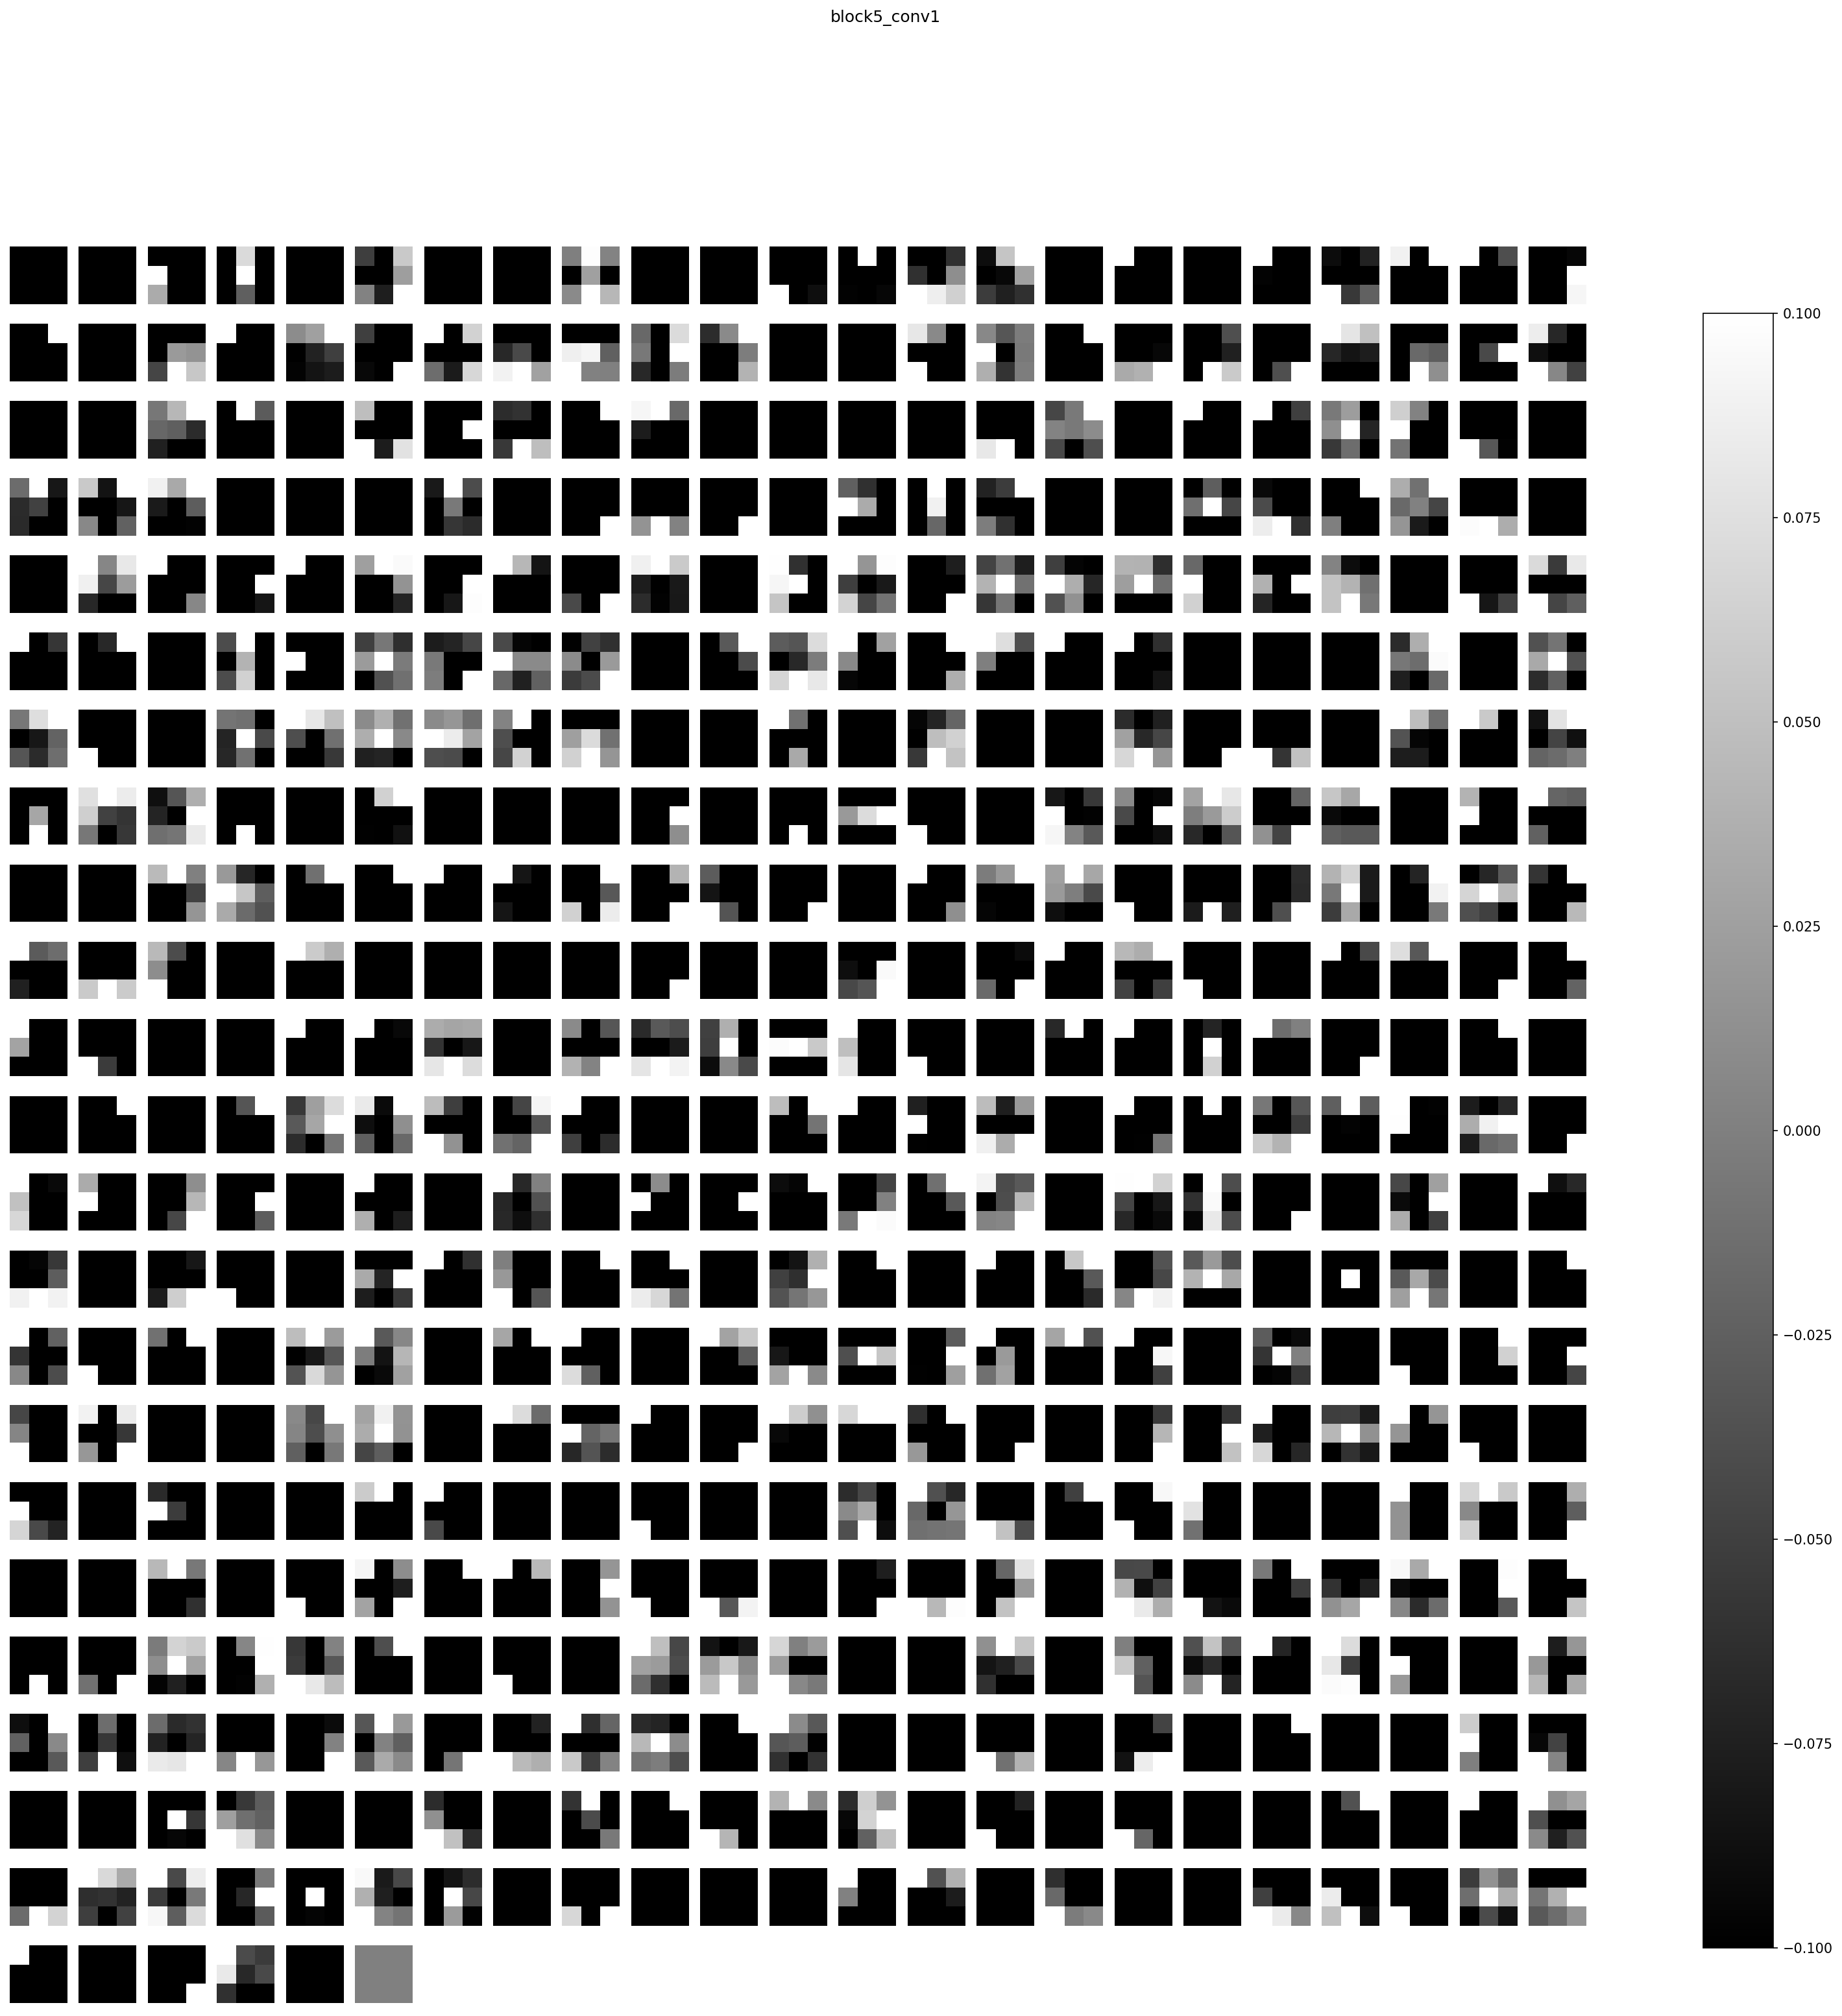

block5_conv2 (1, 3, 3, 512) 


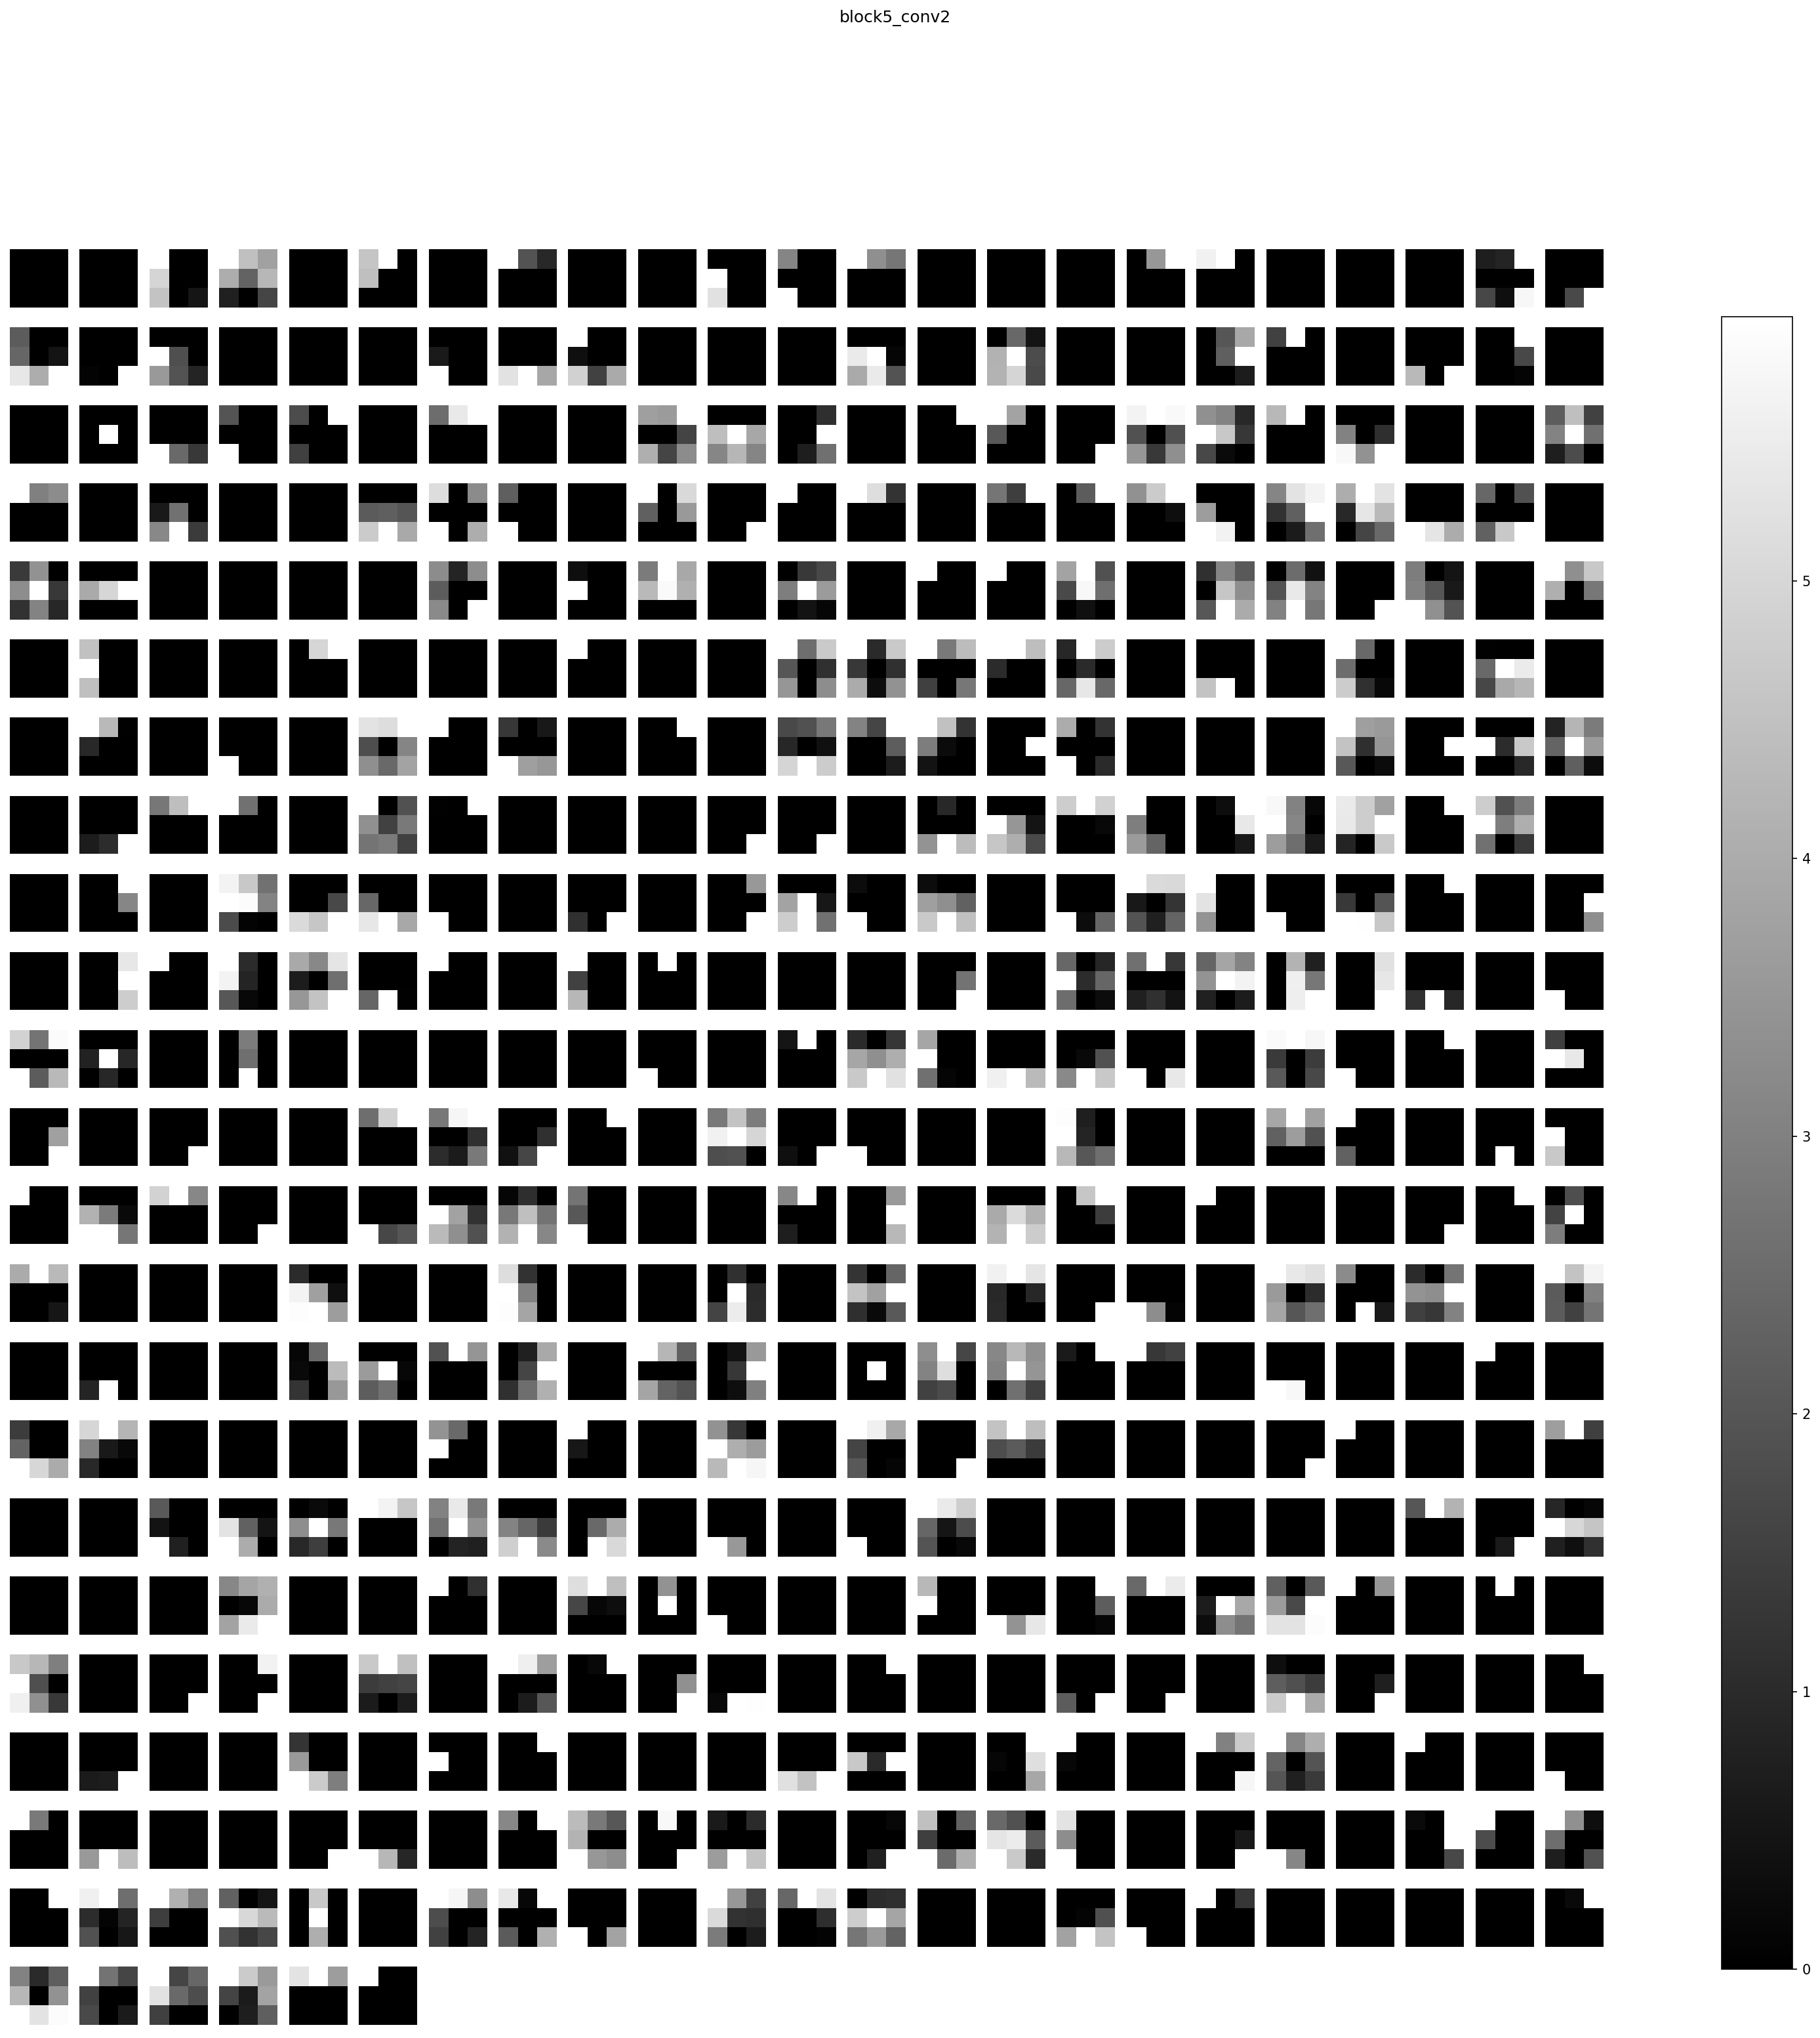

block5_conv3 (1, 3, 3, 512) 


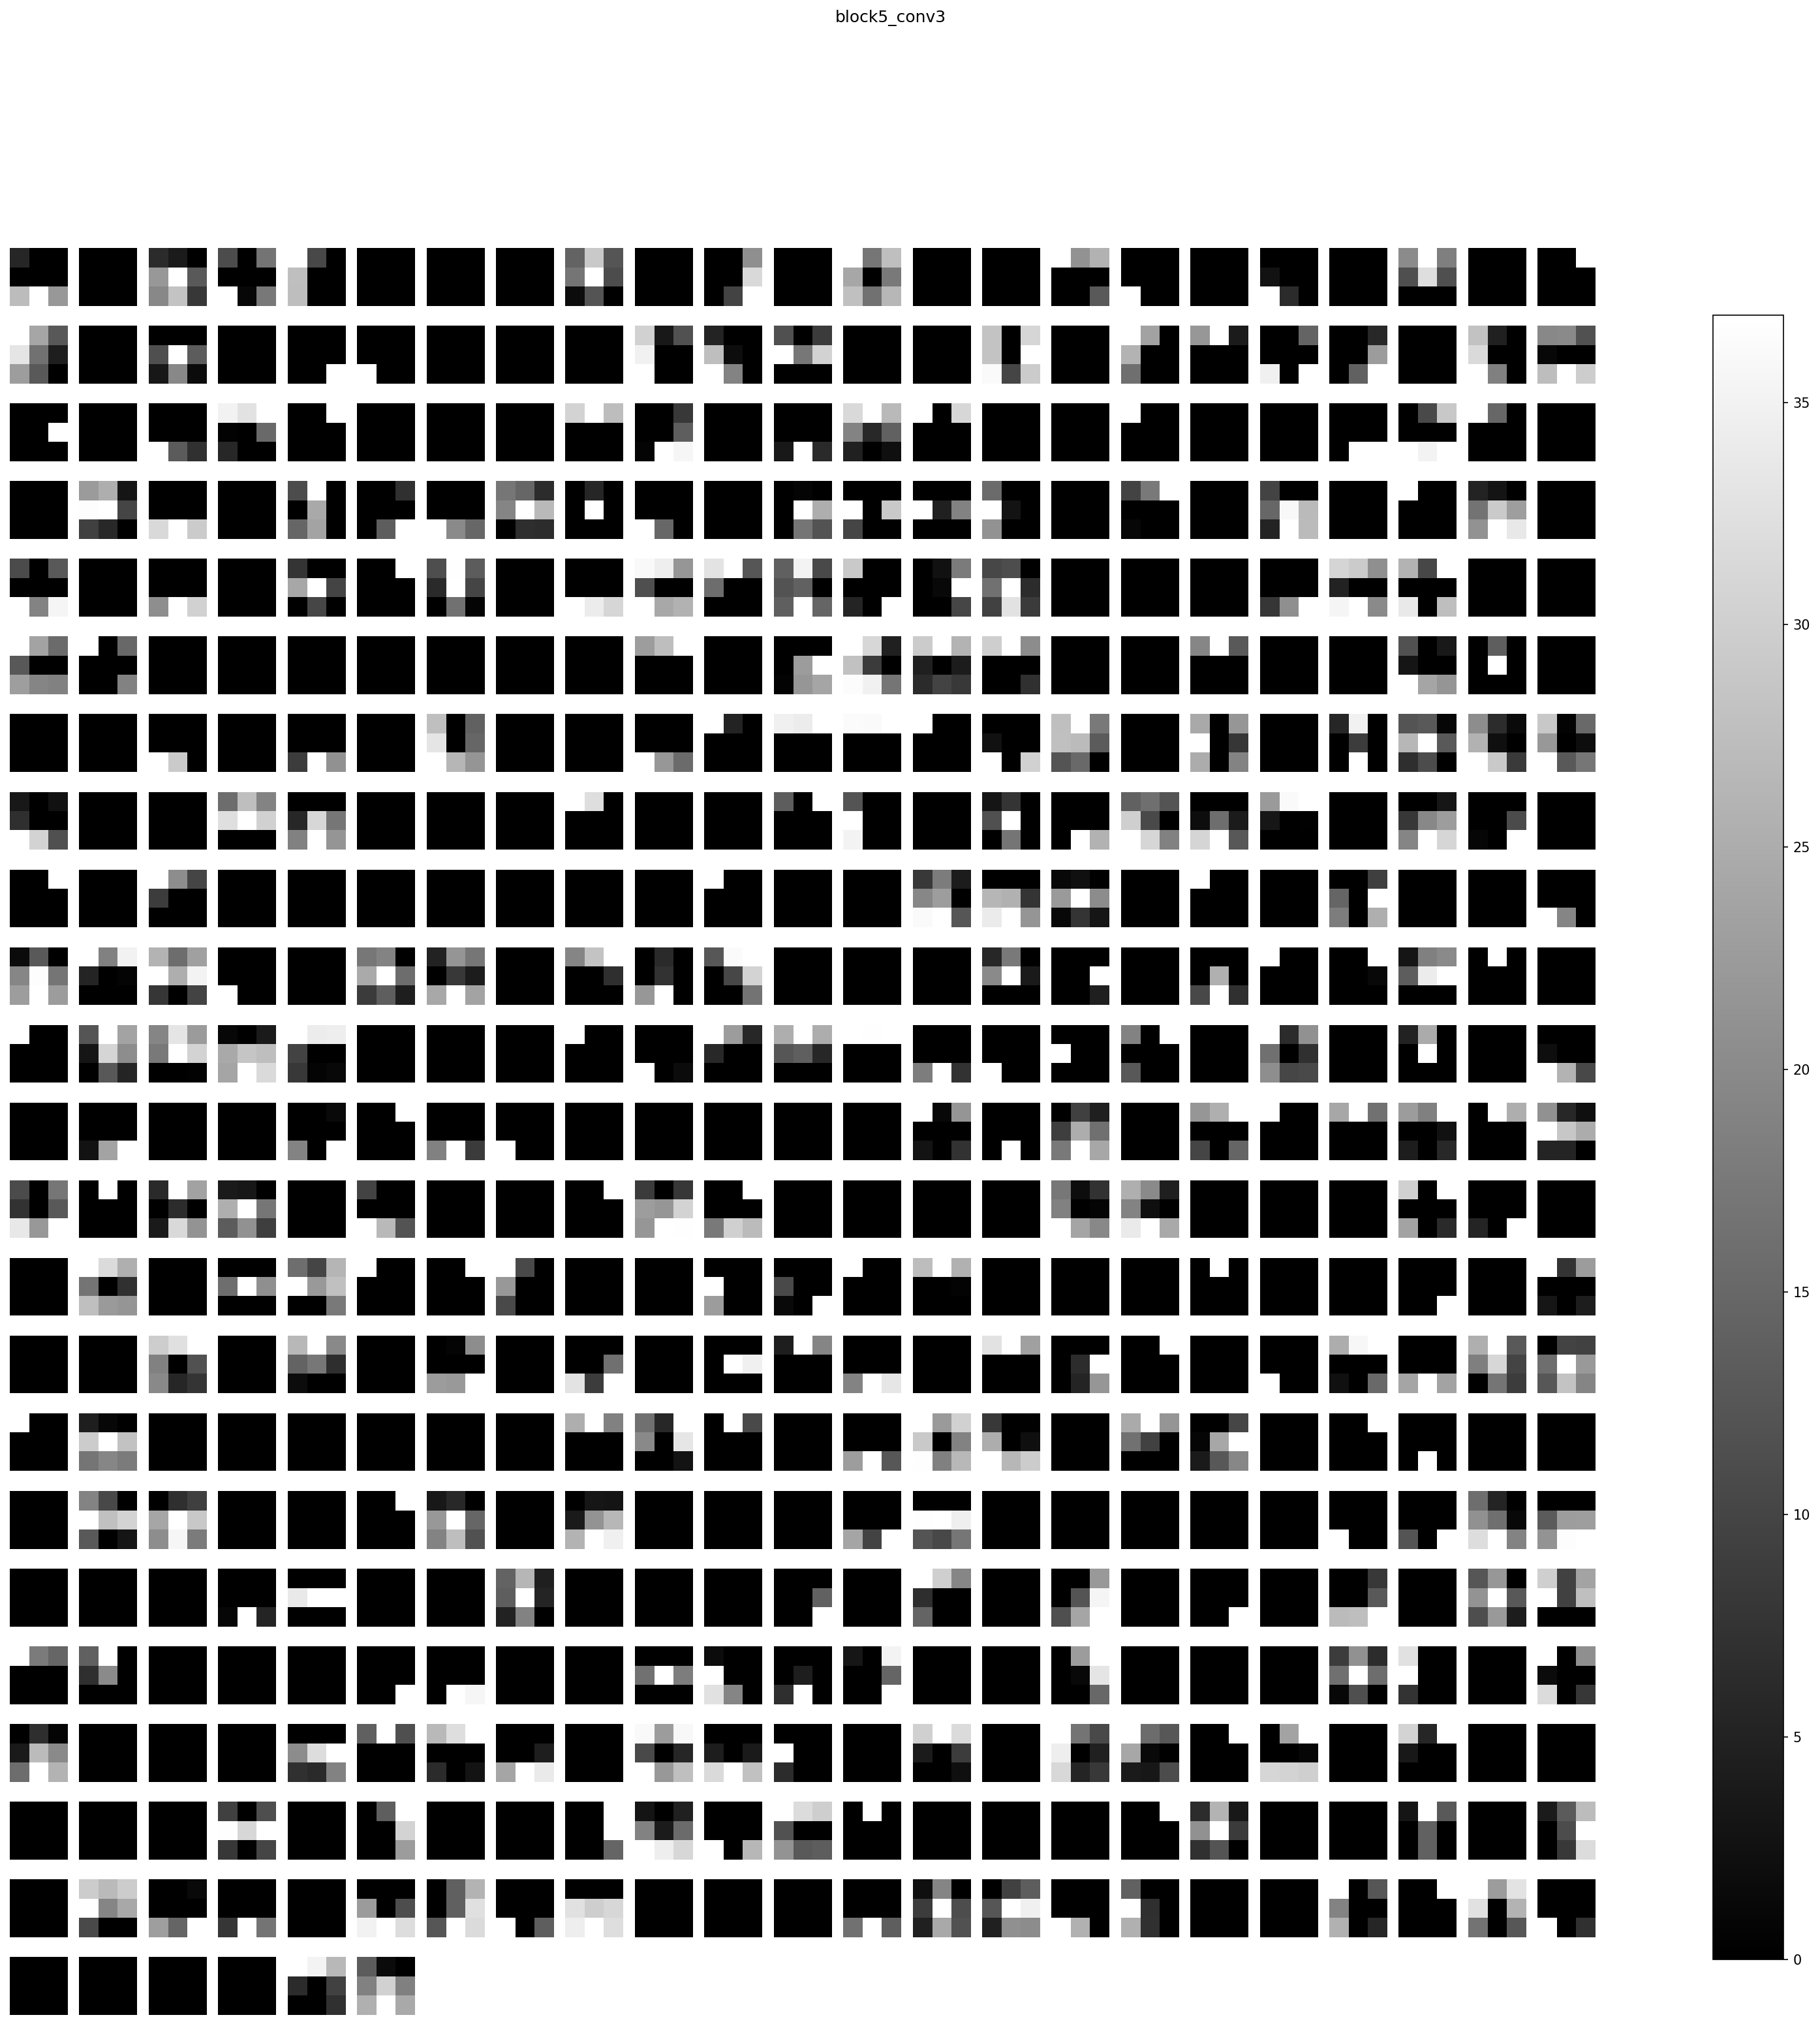

block5_conv4 (1, 3, 3, 512) 


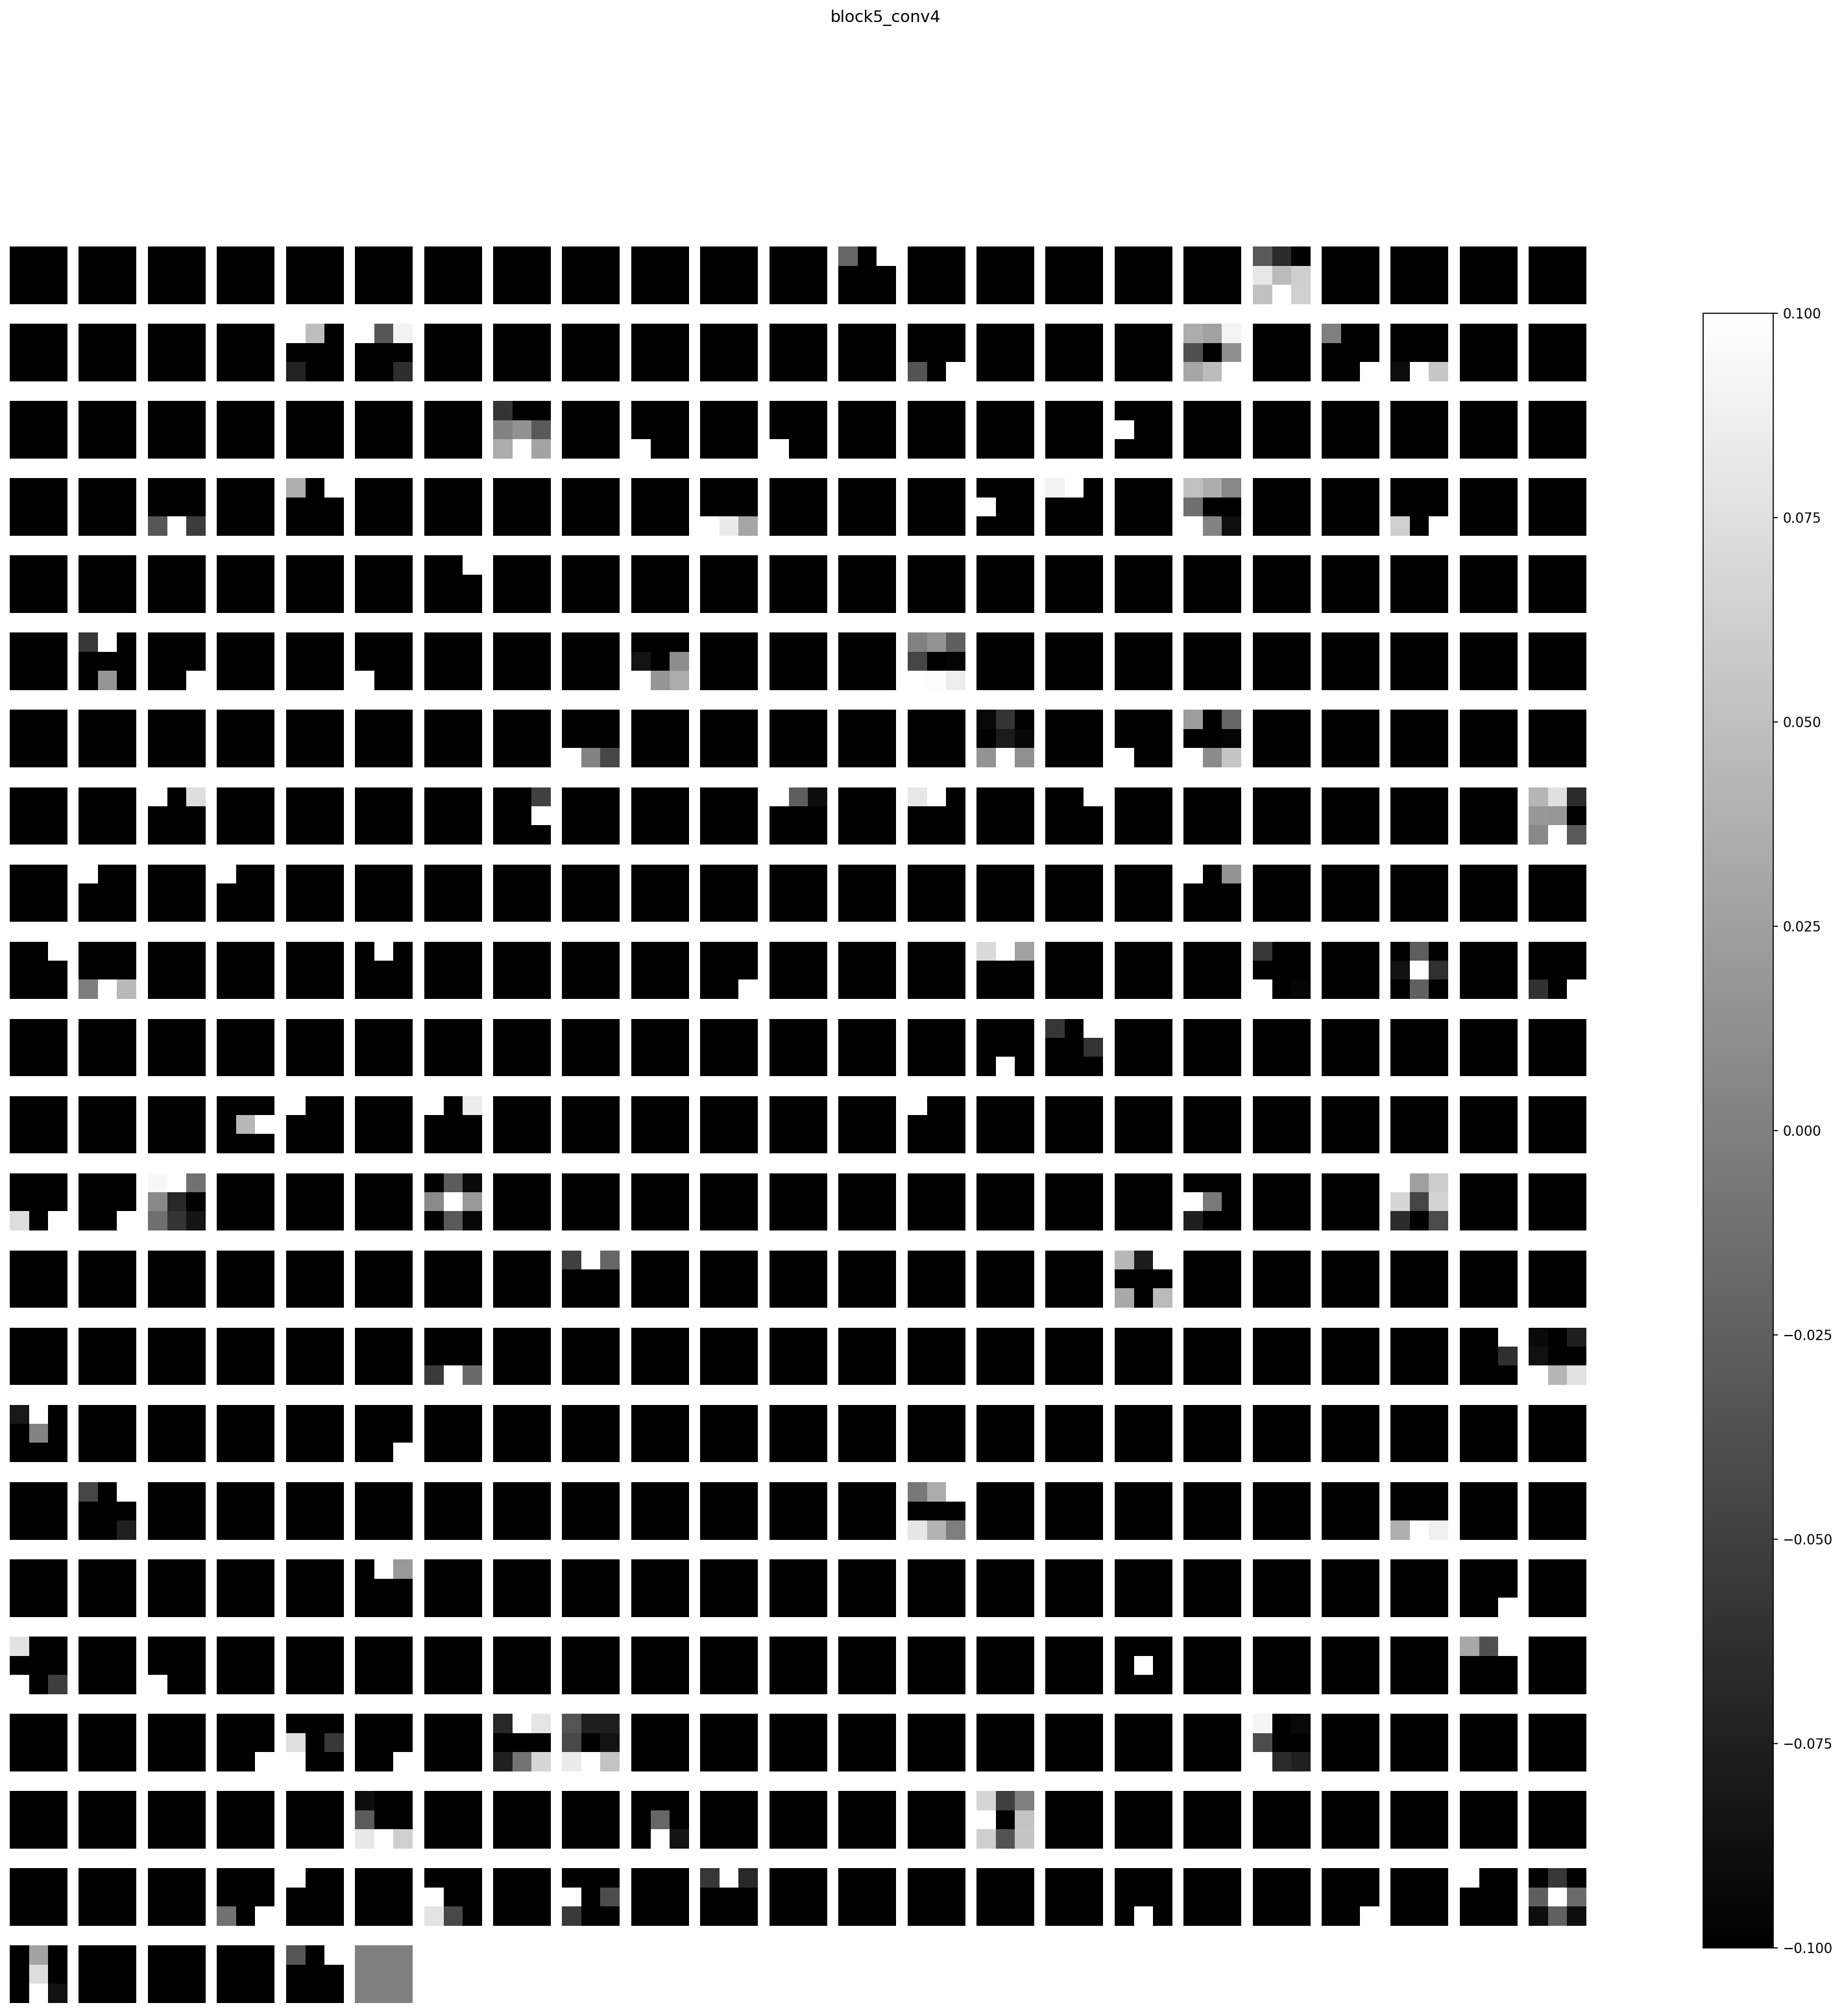

block5_pool (1, 1, 1, 512) 


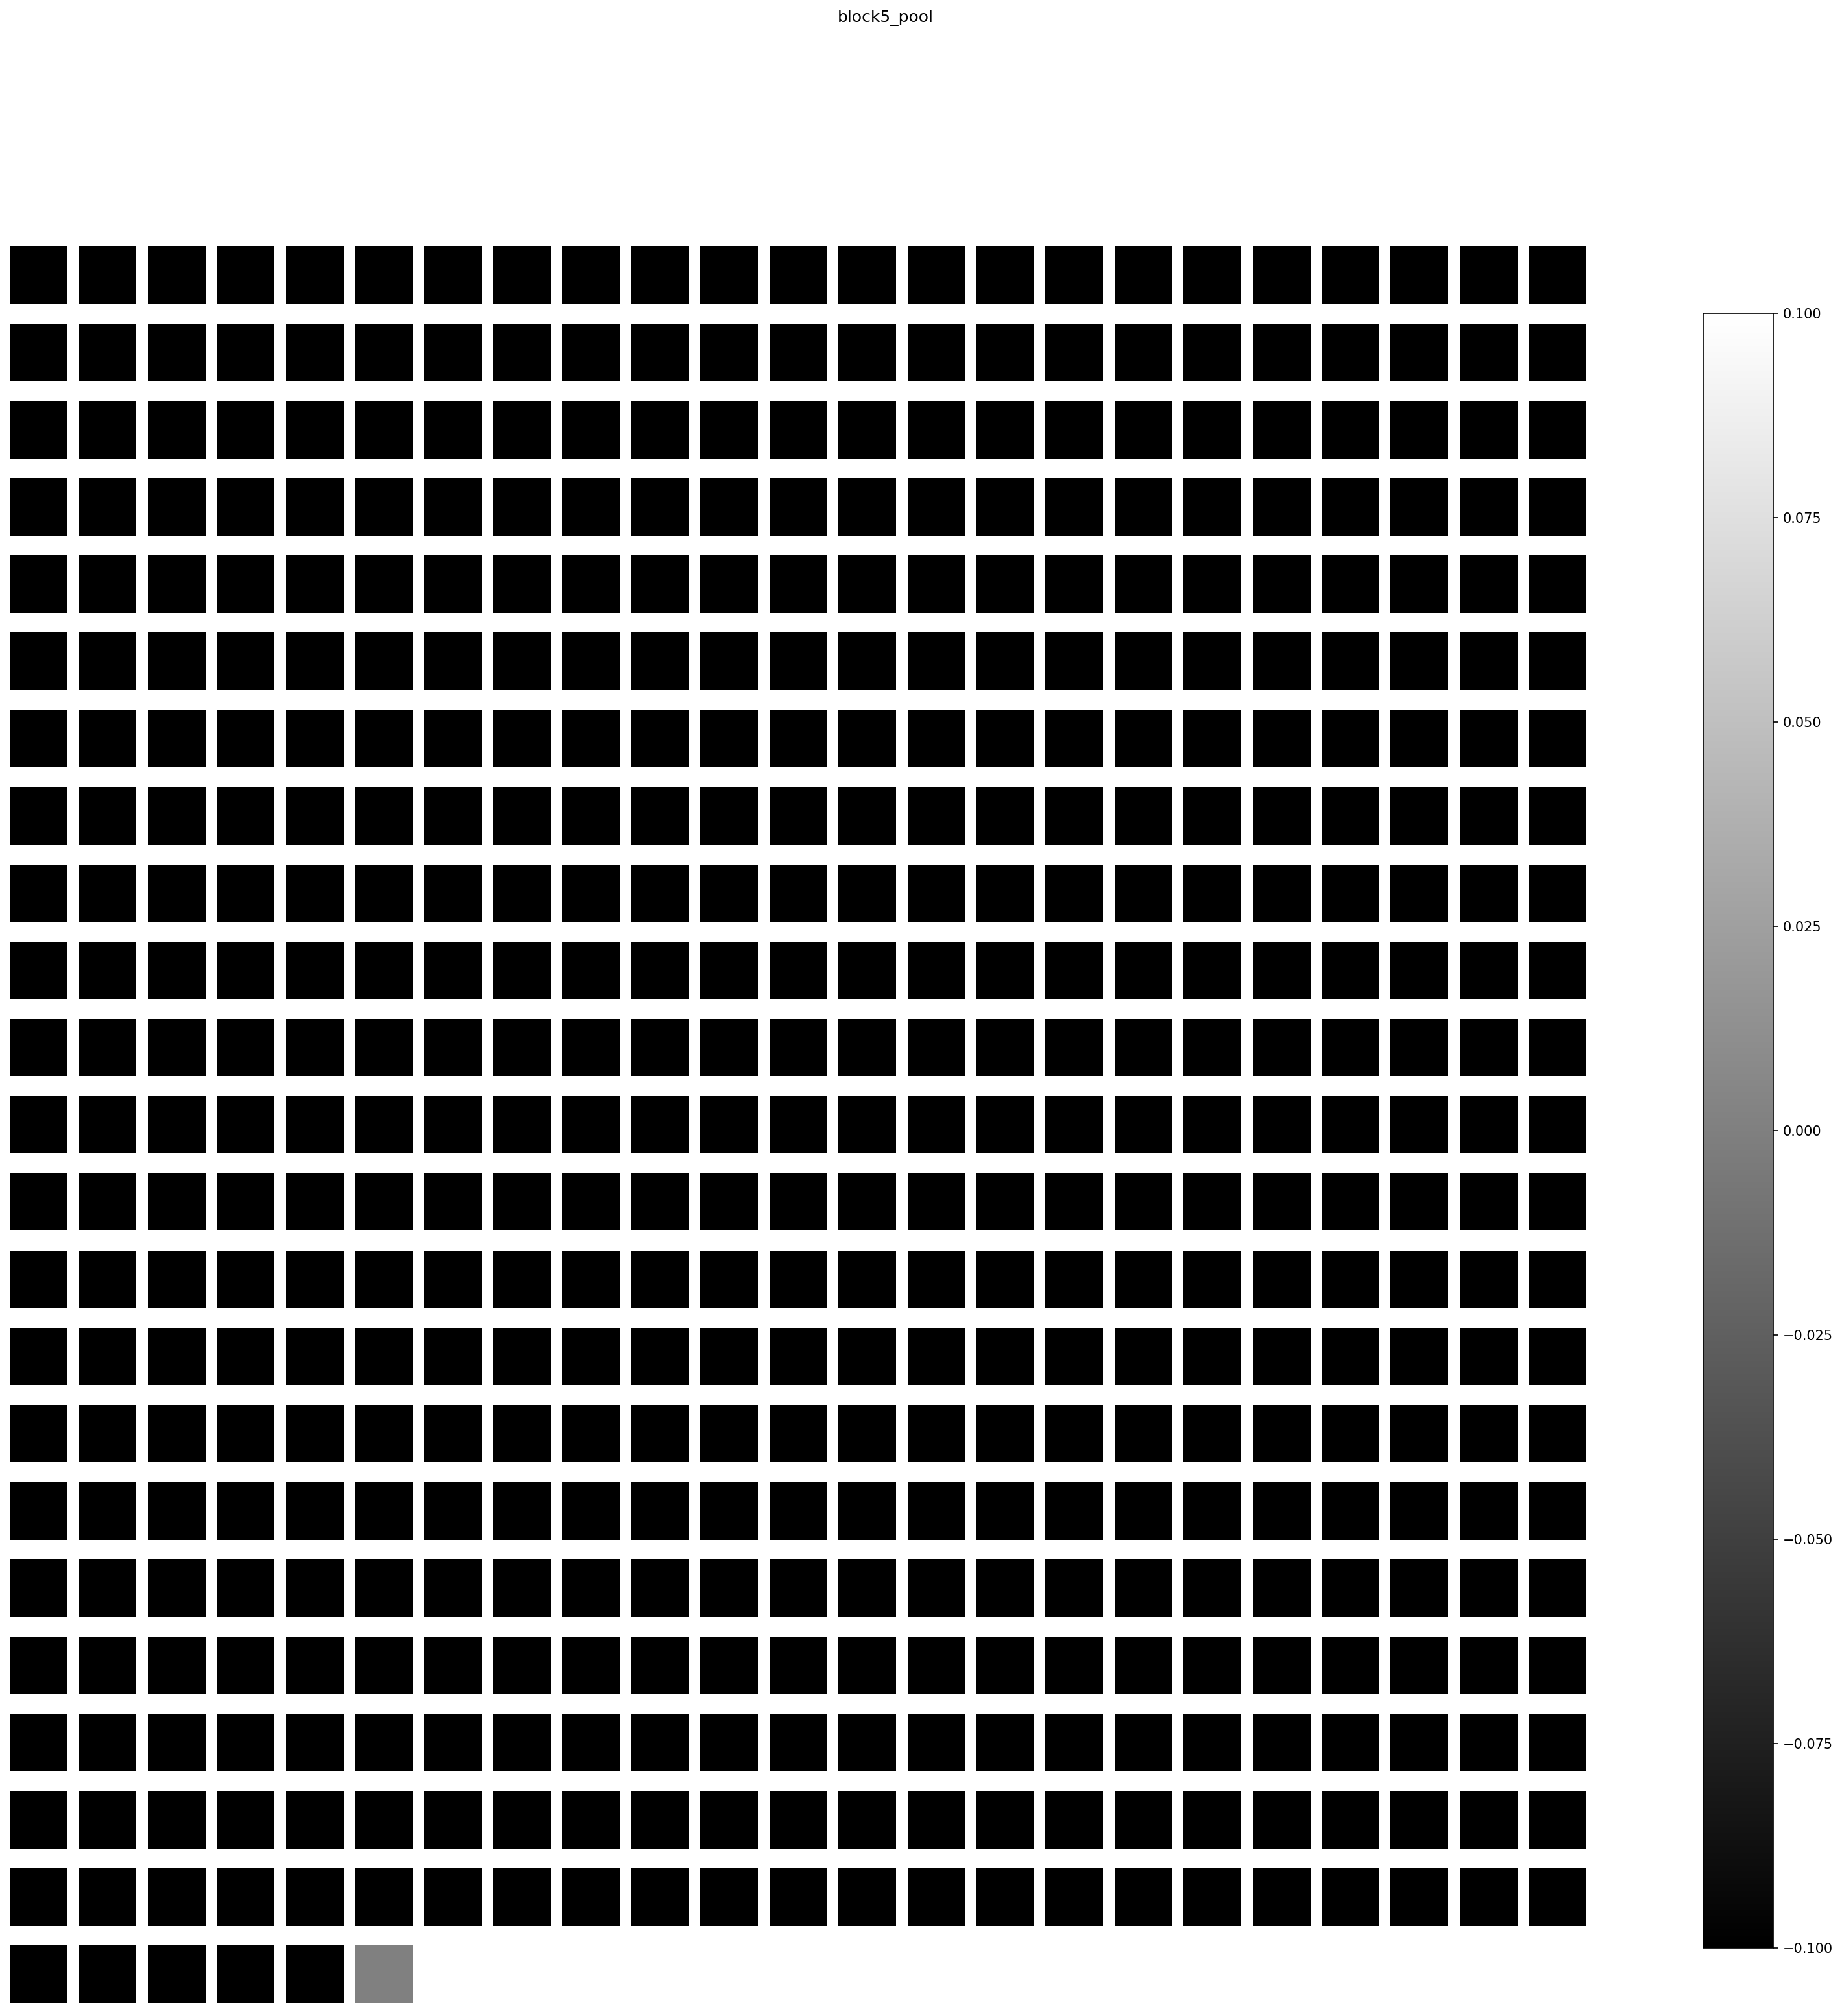

flatten_2 (1, 512) 


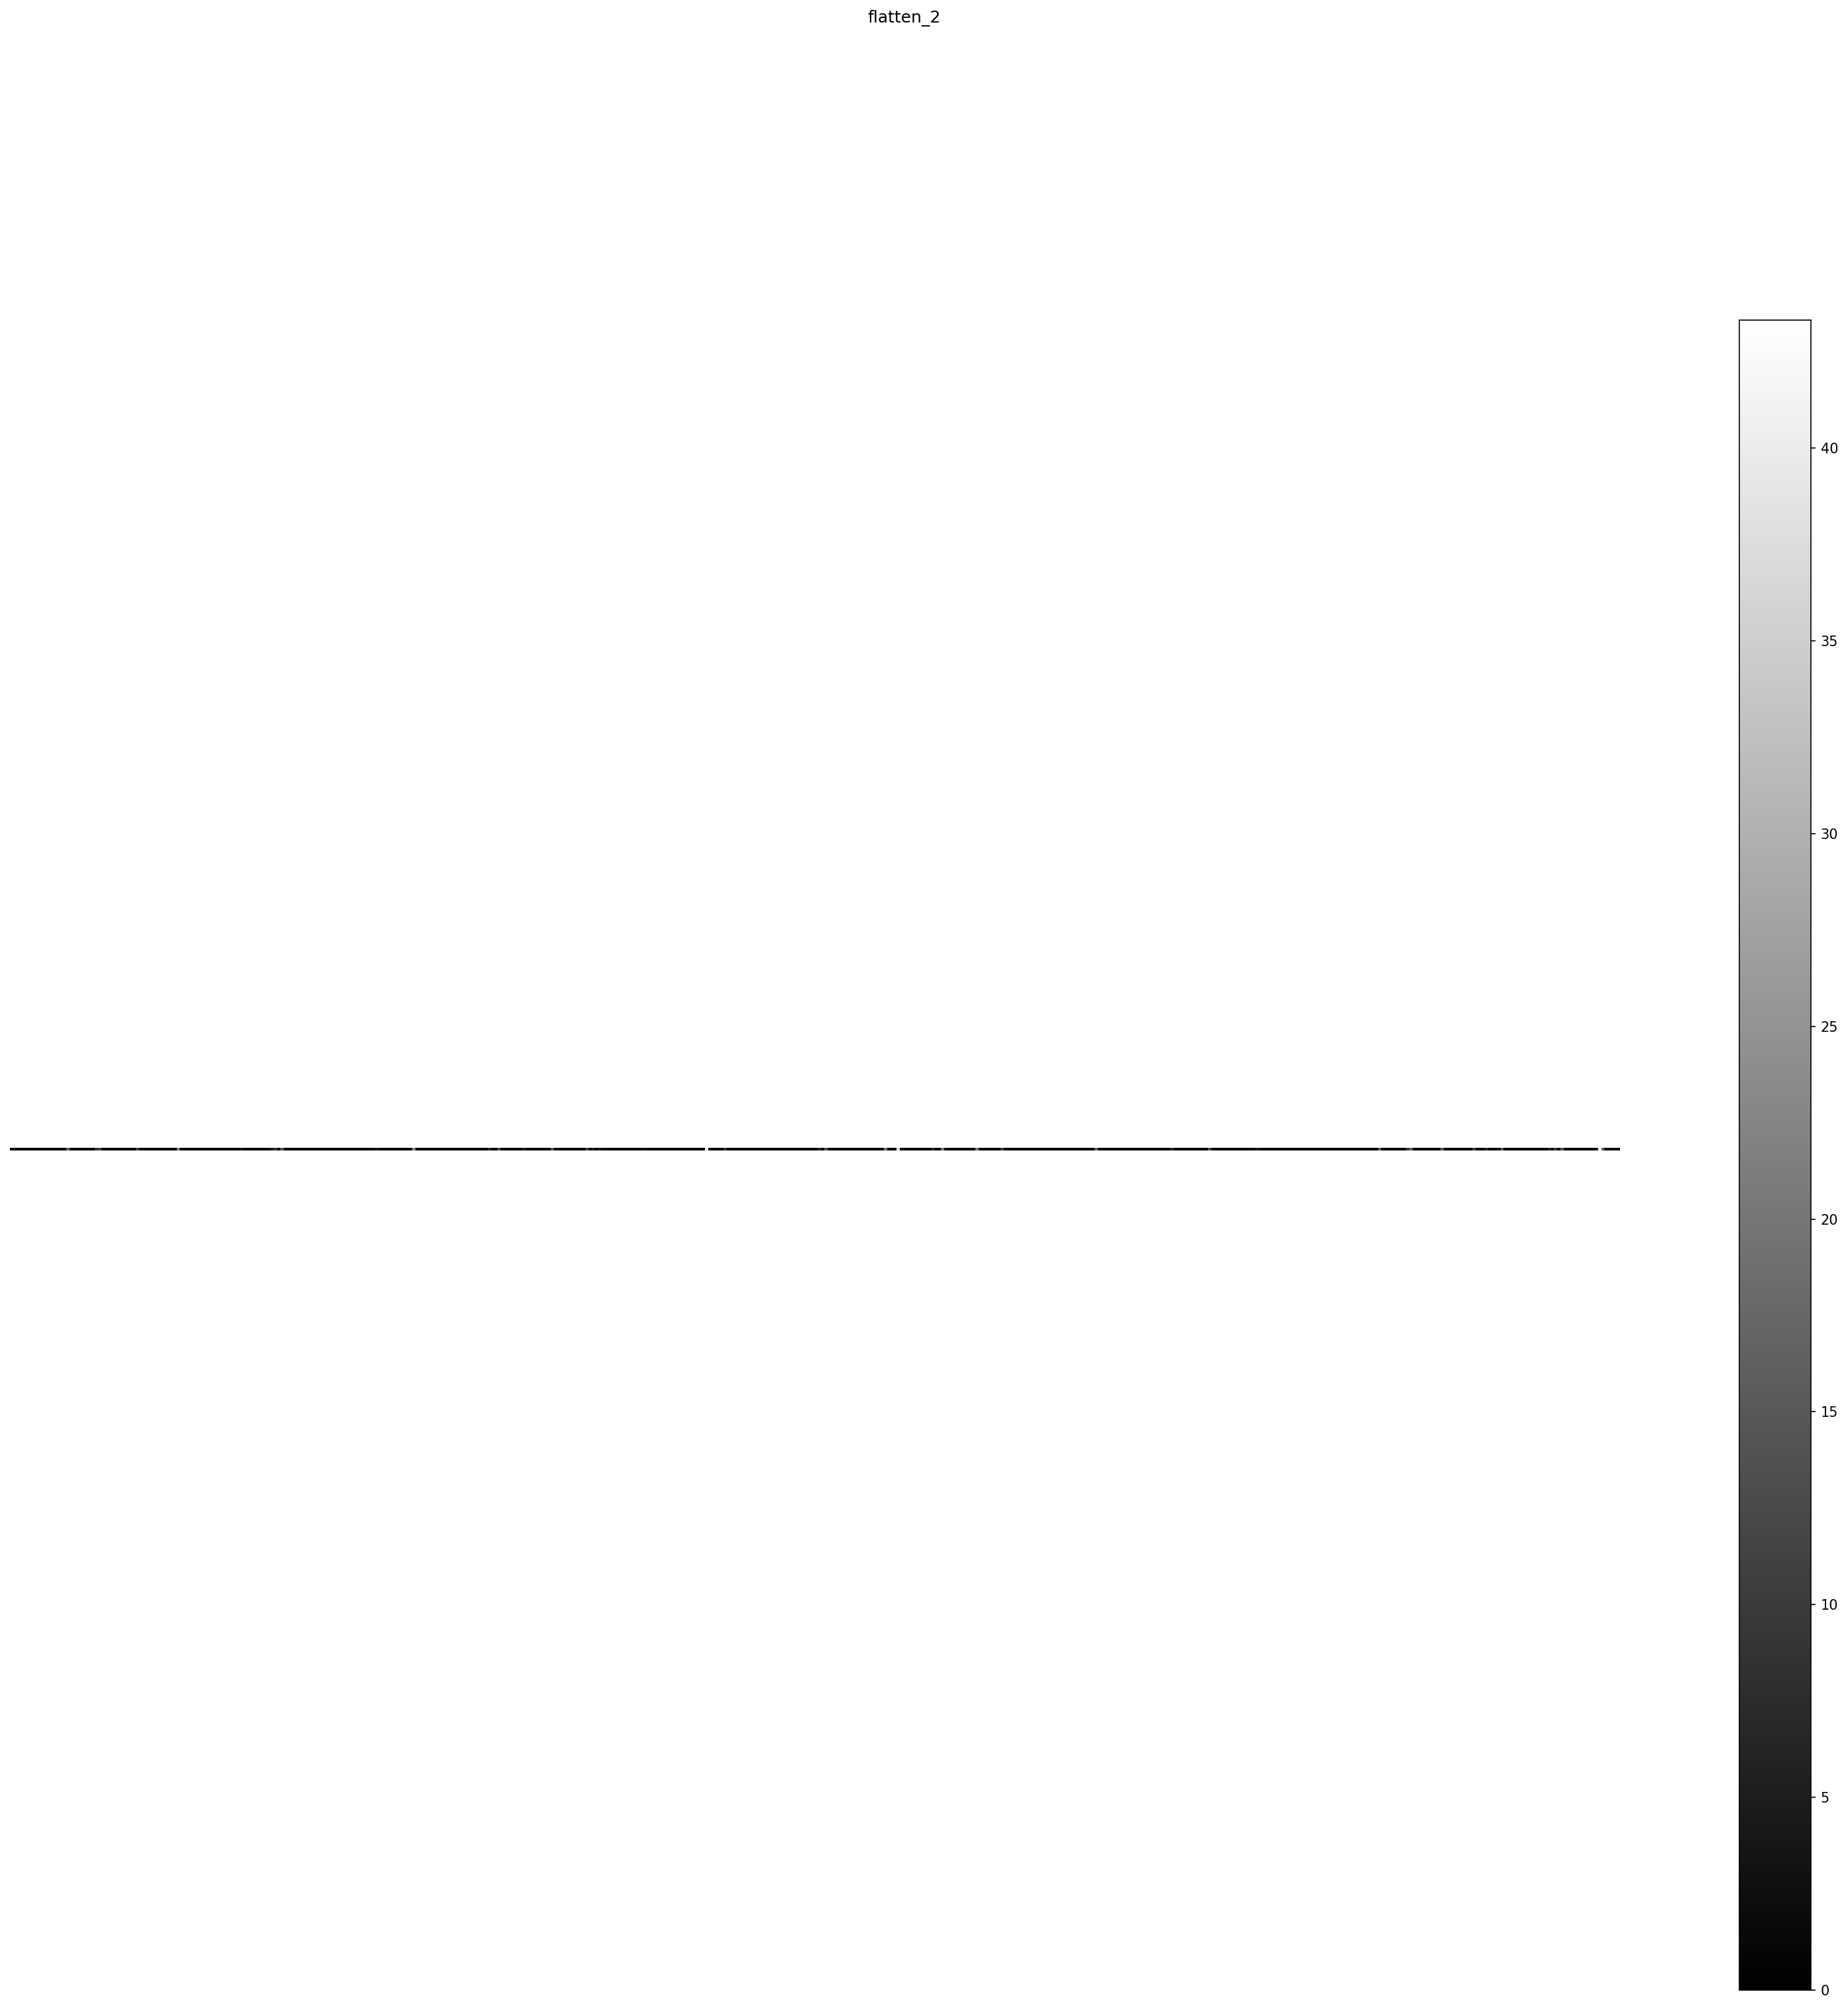

dense_2 (1, 128) 


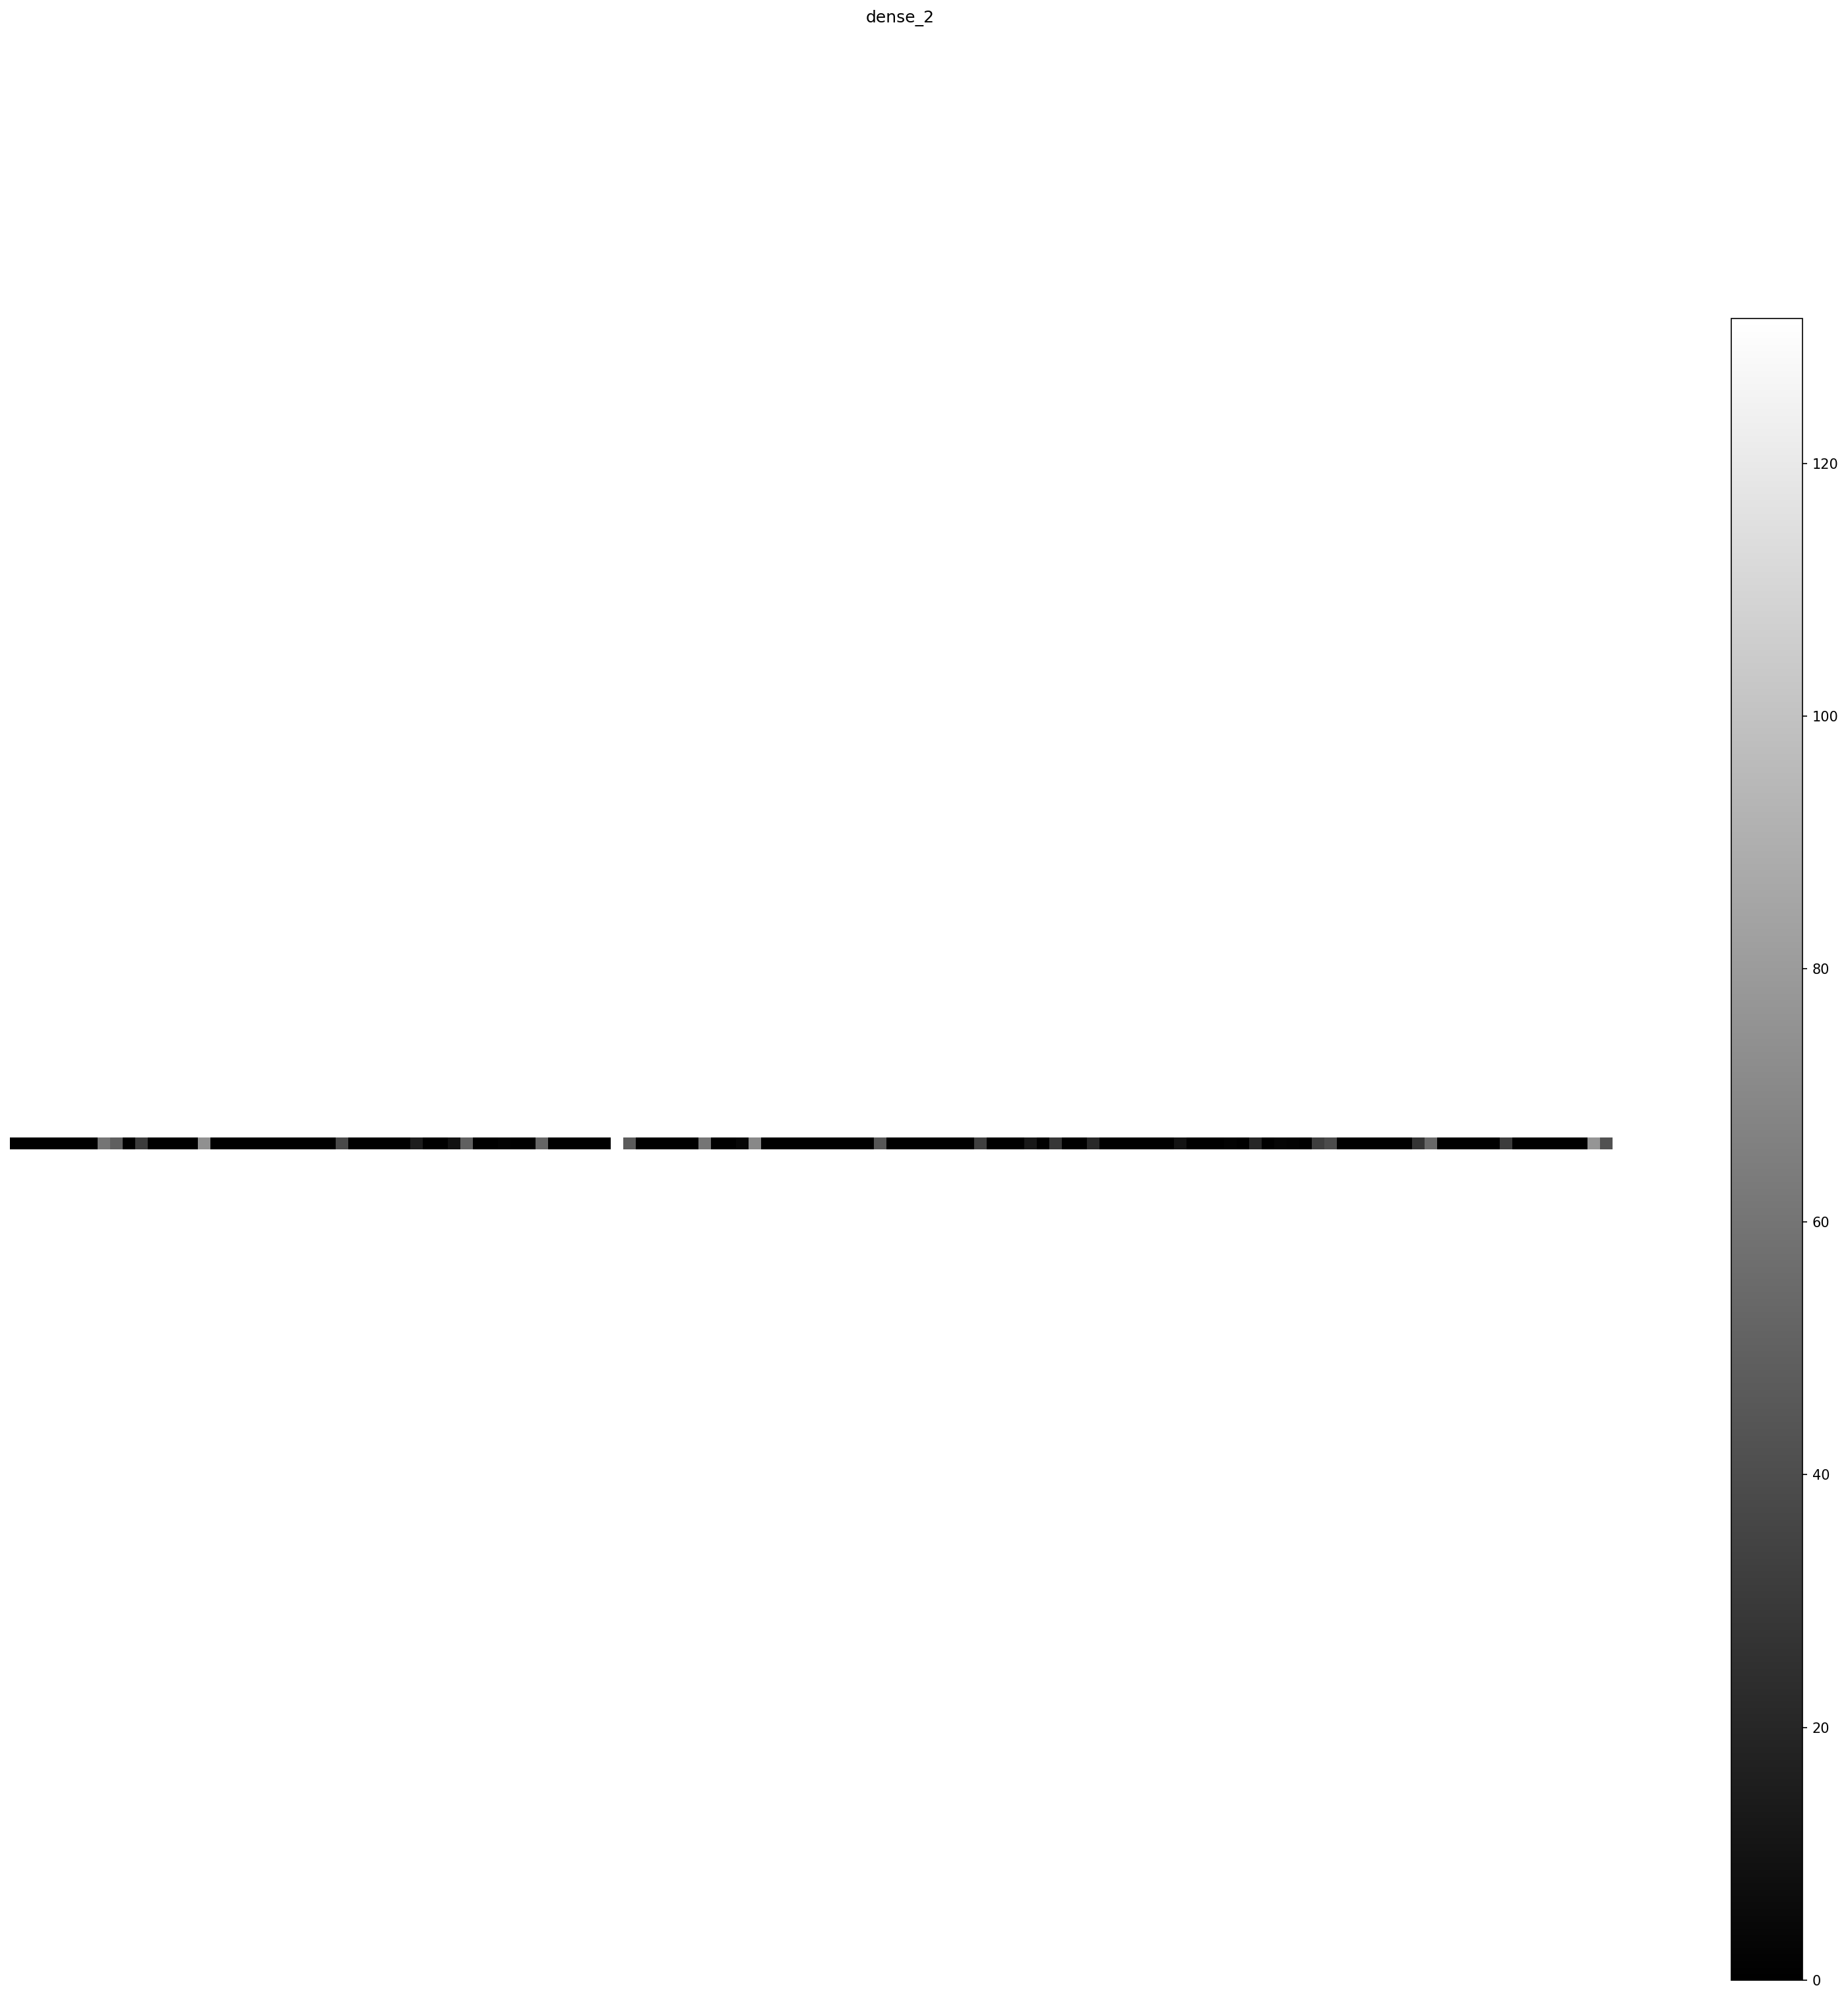

predictions (1, 1) 


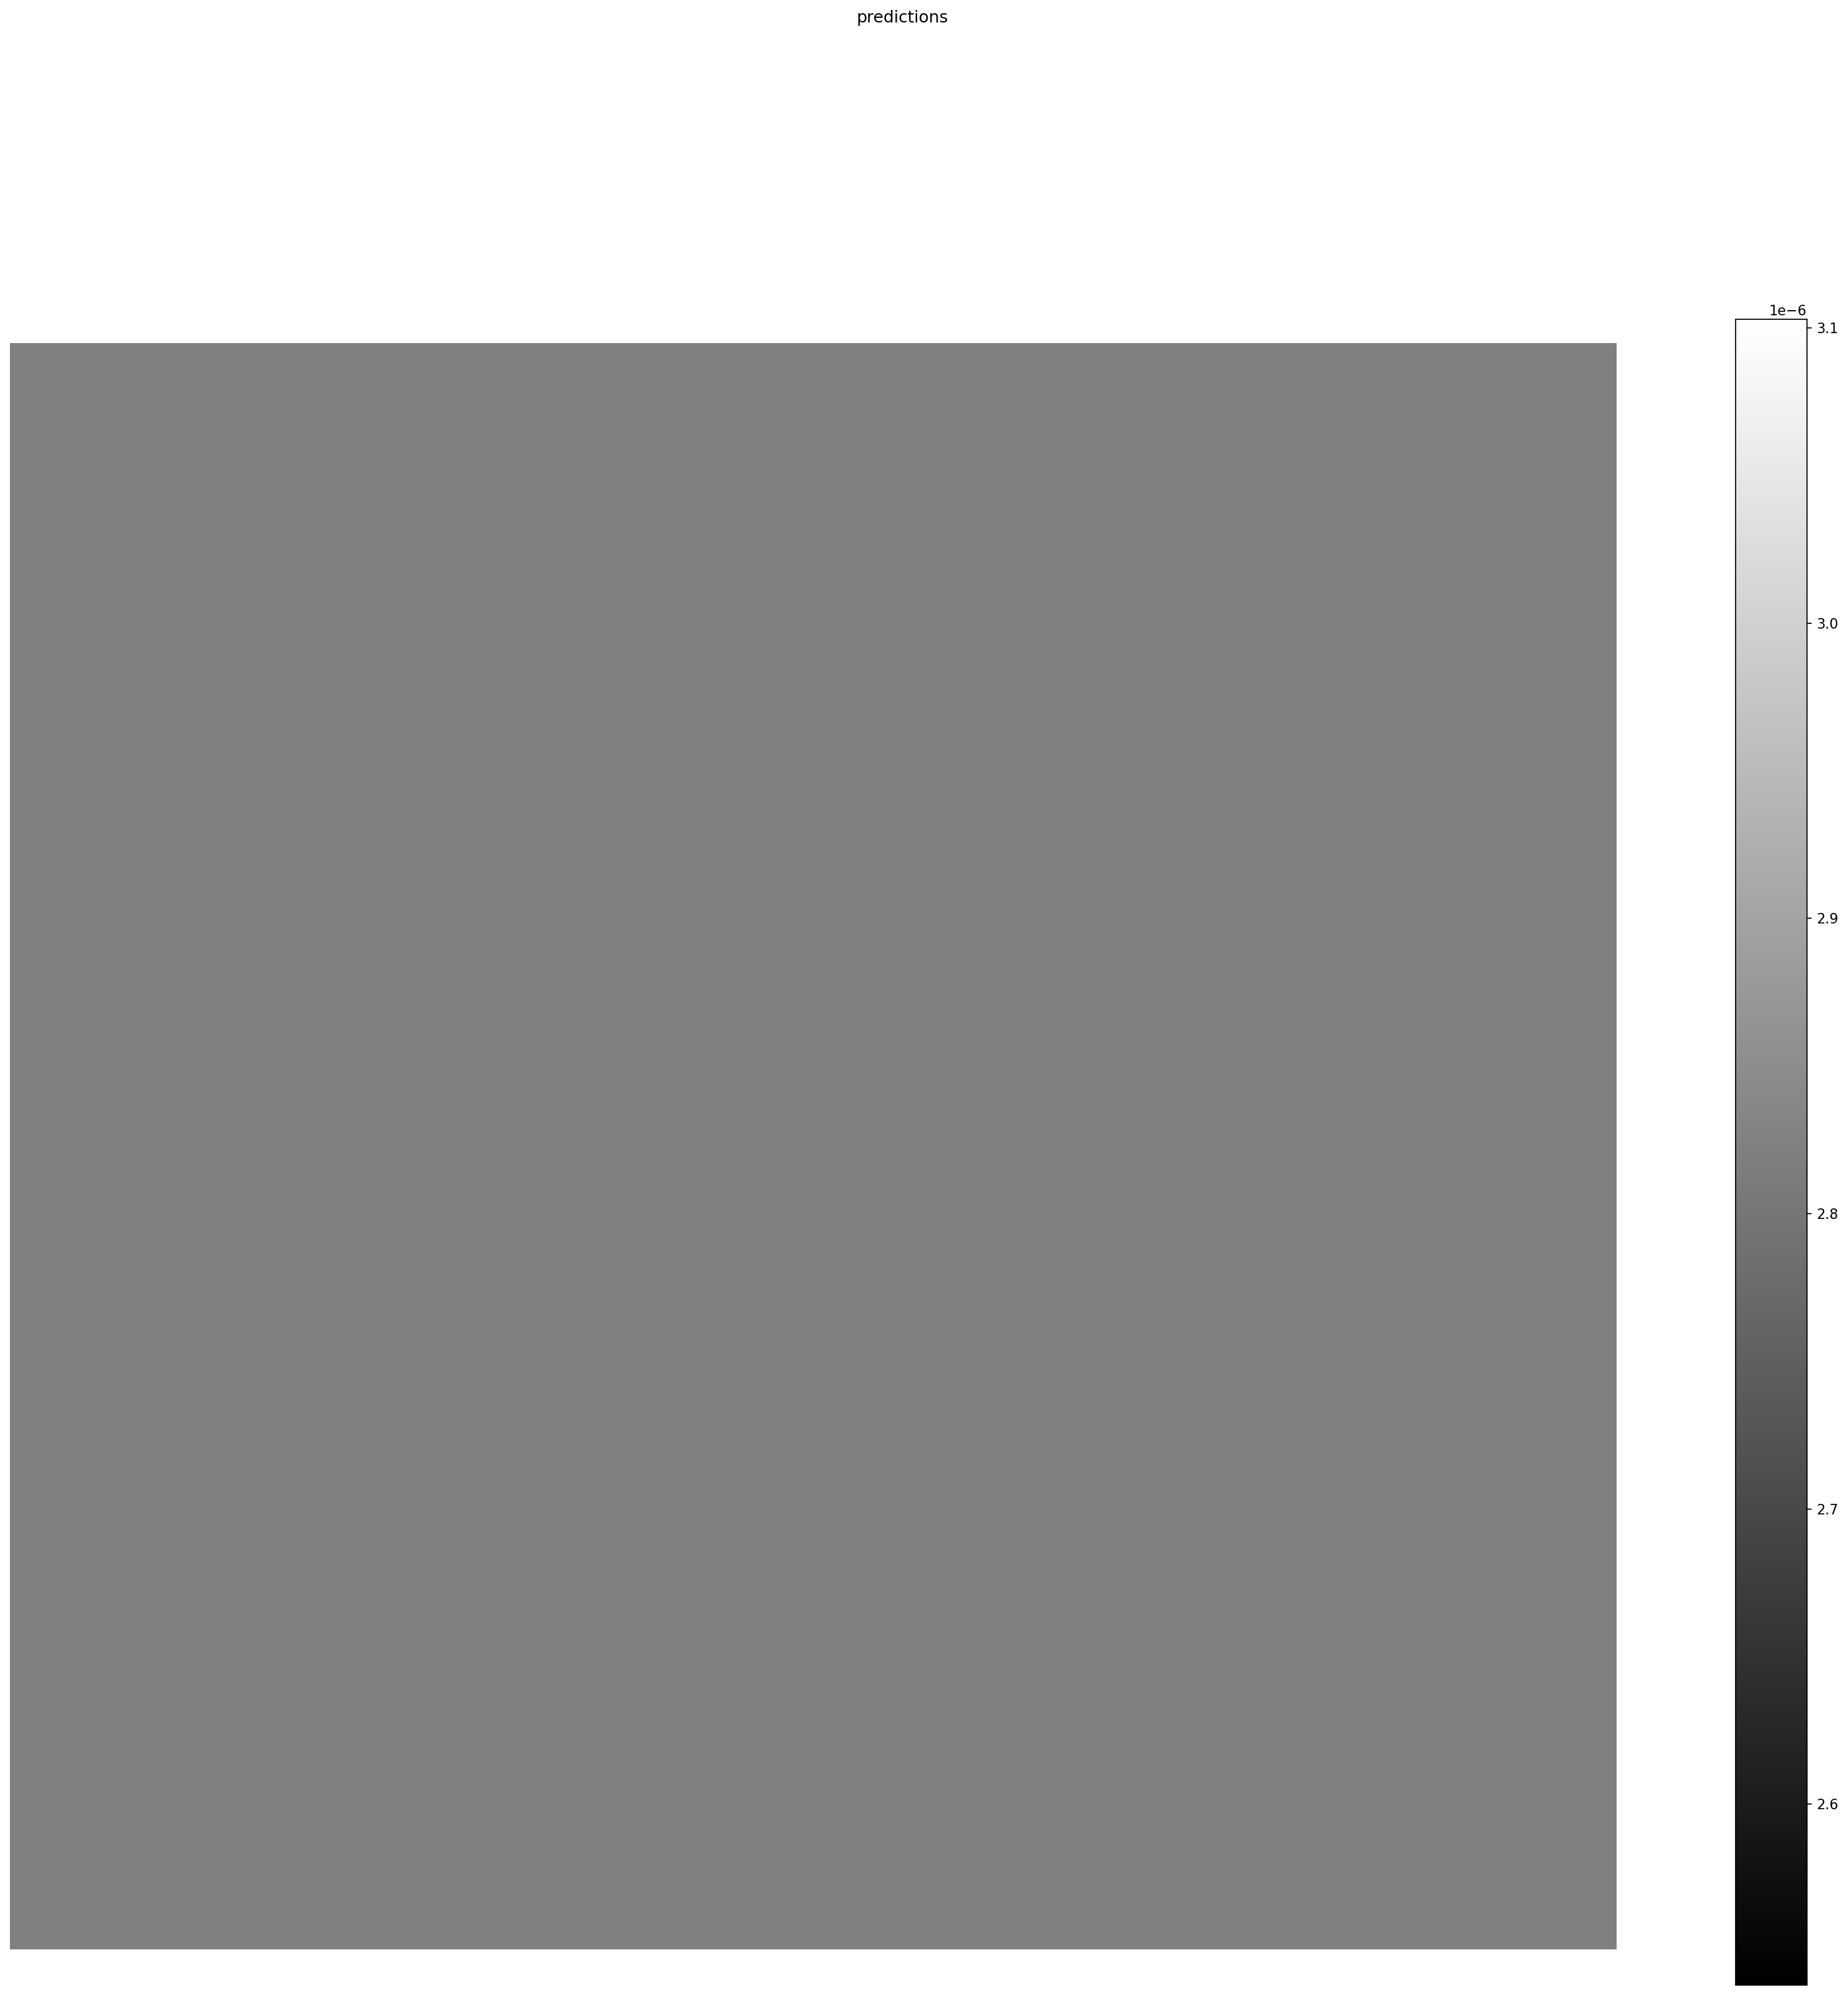

In [44]:
from keract import get_activations, display_activations
v_index= 4
x_valid = X_train[:5]
a = get_activations(my_model, x_valid[v_index:v_index+1])
display_activations(a)